In [1]:
%pylab inline
from scipy import stats
import os,pickle
np.set_printoptions(suppress=True)
set_printoptions(suppress=True)
from scipy.special import digamma
from analysis import printCI
DPATH=os.getcwd()+os.path.sep+'standata'+os.path.sep
from matusplotlib import errorbar
import pandas as pd
import statsmodels.api as st
import statsmodels.formula.api as sf

Populating the interactive namespace from numpy and matplotlib


In [2]:
%pylab inline
from analysis import printCI,getMetadata,LBLS,plotSample,getData,plotSmResults

info,Dres=getMetadata()
#plotSample(info,Dres)
yLT,xAll=getData(info,Dres)

Populating the interactive namespace from numpy and matplotlib
Check if all data files present
Checking for surplus files missing from vpinfo
Checking format of .res files
Check format of .log files


# Lognormal markov model no-pooling

e0 (1500, 301)


/home/matus/Desktop/K018funLT/code/analysis.py:230: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.median(z,0),normed=True,bins=bns)
/home/matus/Desktop/K018funLT/code/analysis.py:237: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.median(z[:,x[:,0]==k],0),normed=True,bins=bns)
/home/matus/Desktop/K018funLT/code/analysis.py:247: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.median(z[:,x[:,1]==k],0),normed=True,bins=bns)
/home/matus/Desktop/K018funLT/code/analysis.py:258: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.median(temp,0),bins=bns,normed=True)


ed (1500, 301)
z0 (1500, 301)
zd (1500, 301)


/home/matus/Desktop/K018funLT/code/analysis.py:243: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(8,12))
/home/matus/Desktop/K018funLT/code/analysis.py:253: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16,12))
/home/matus/Desktop/K018funLT/code/analysis.py:264: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `f

zh (1500, 301)
sigma (1500, 301)


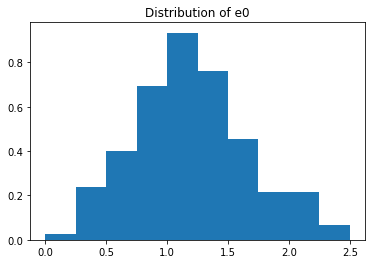

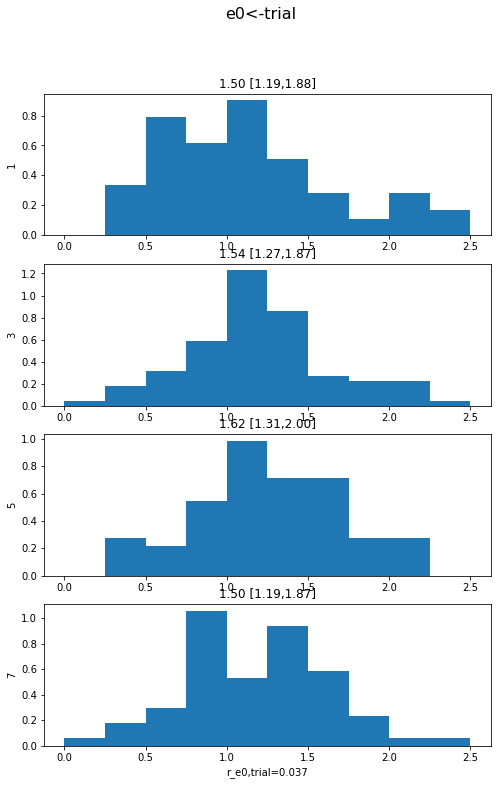

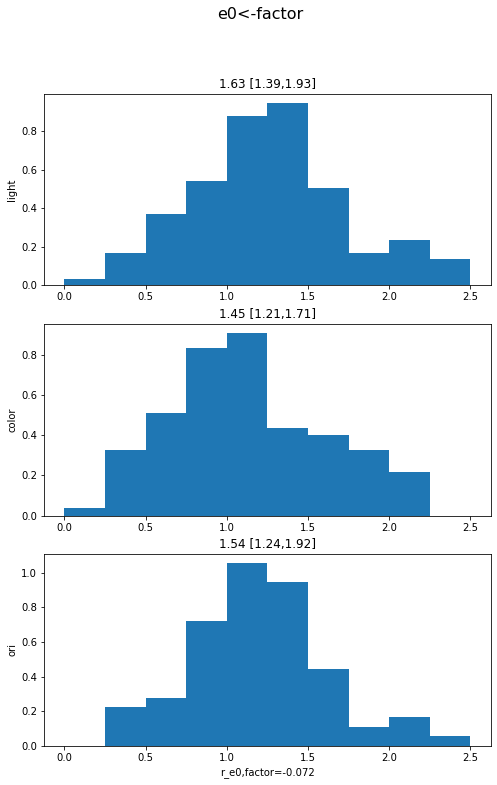

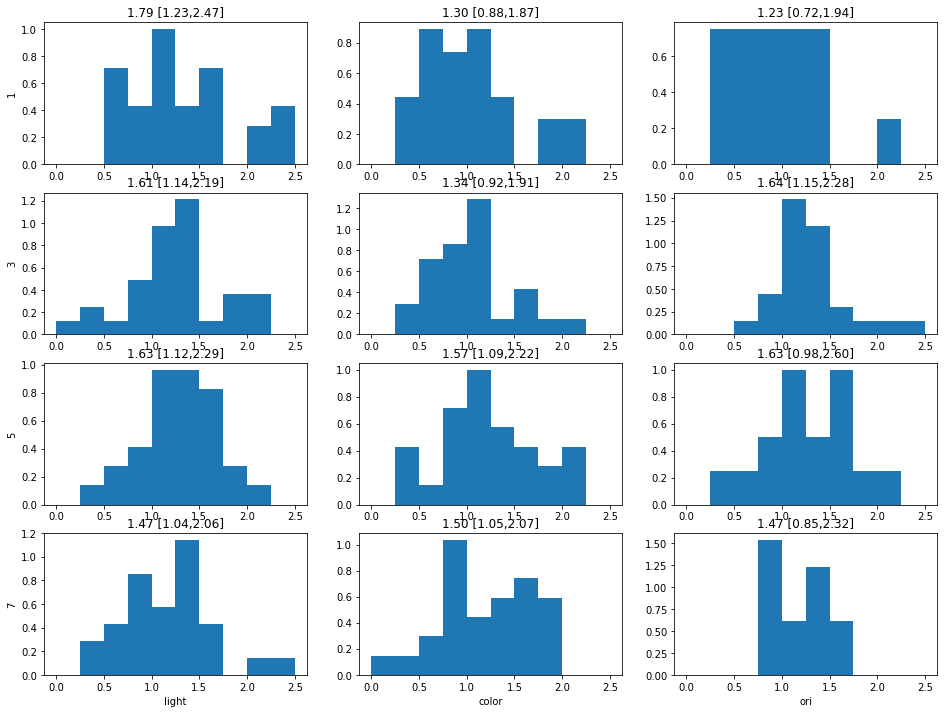

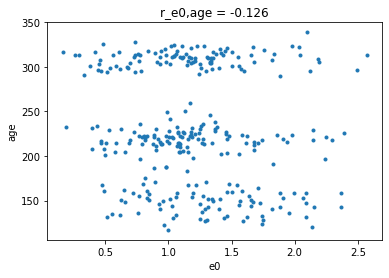

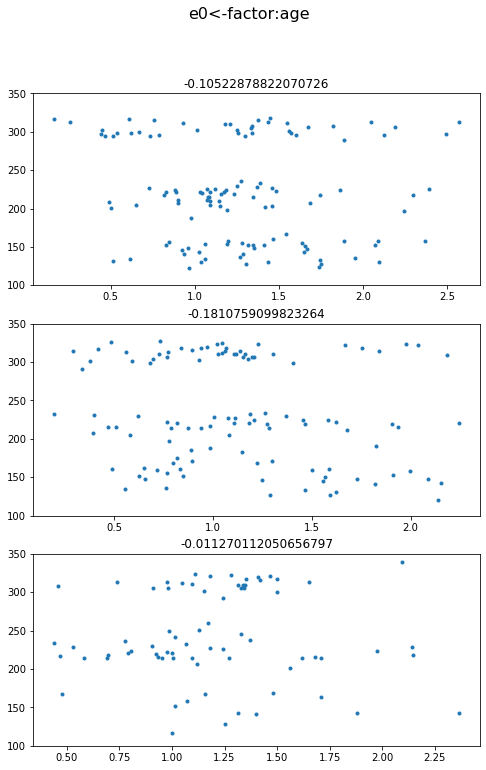

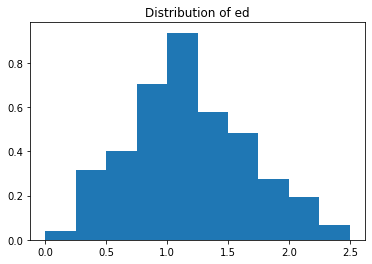

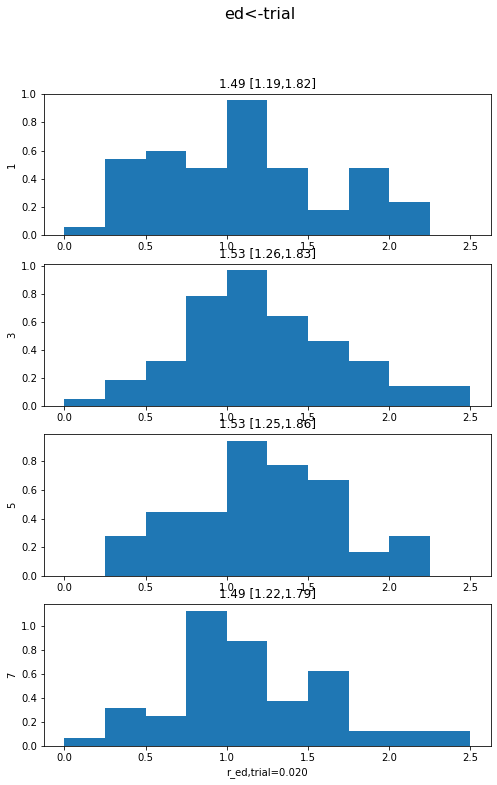

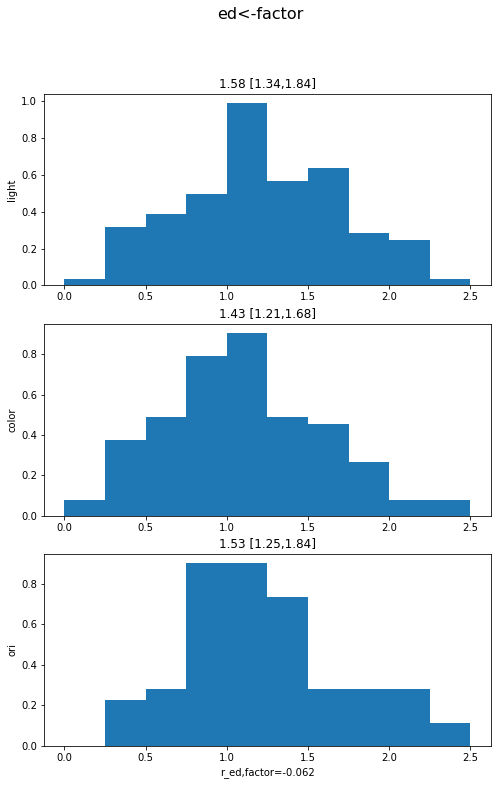

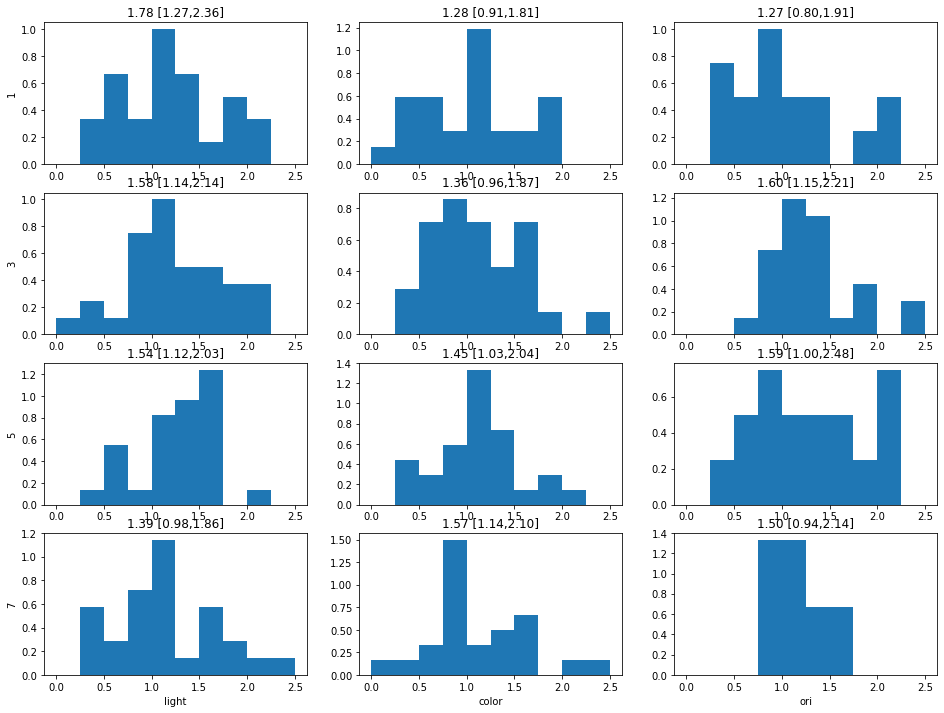

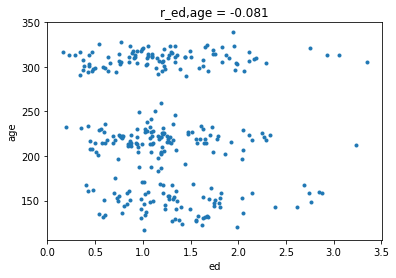

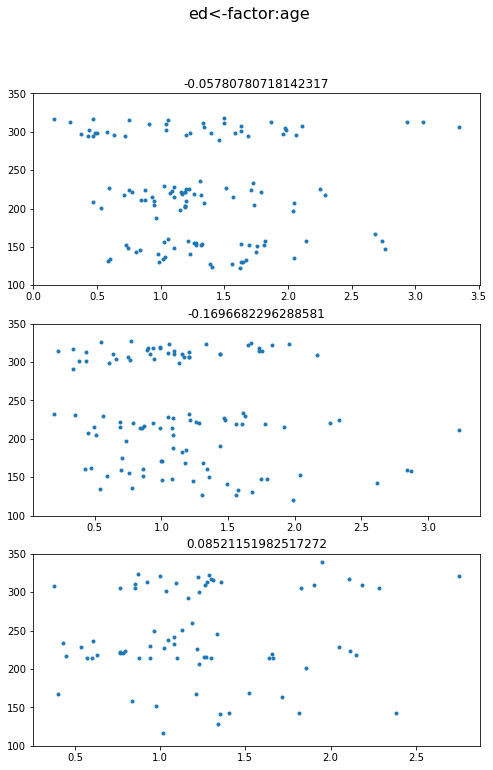

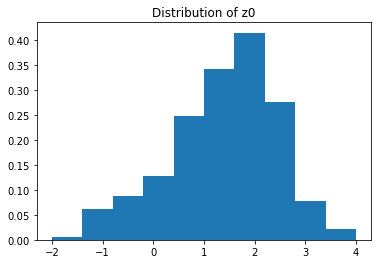

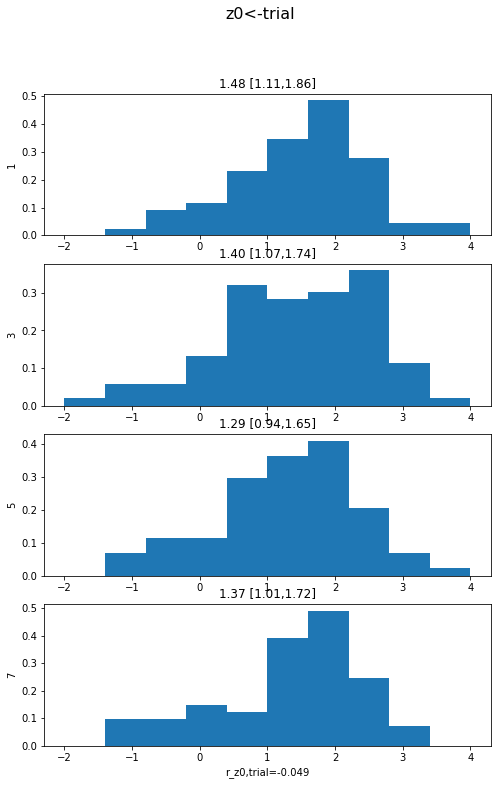

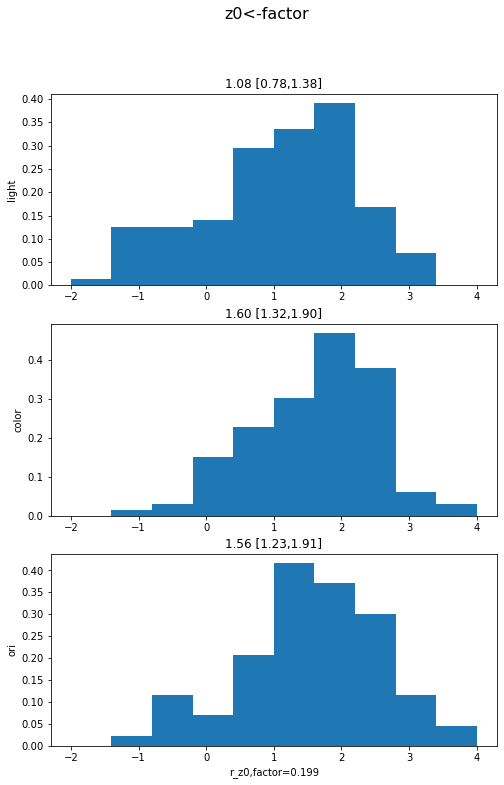

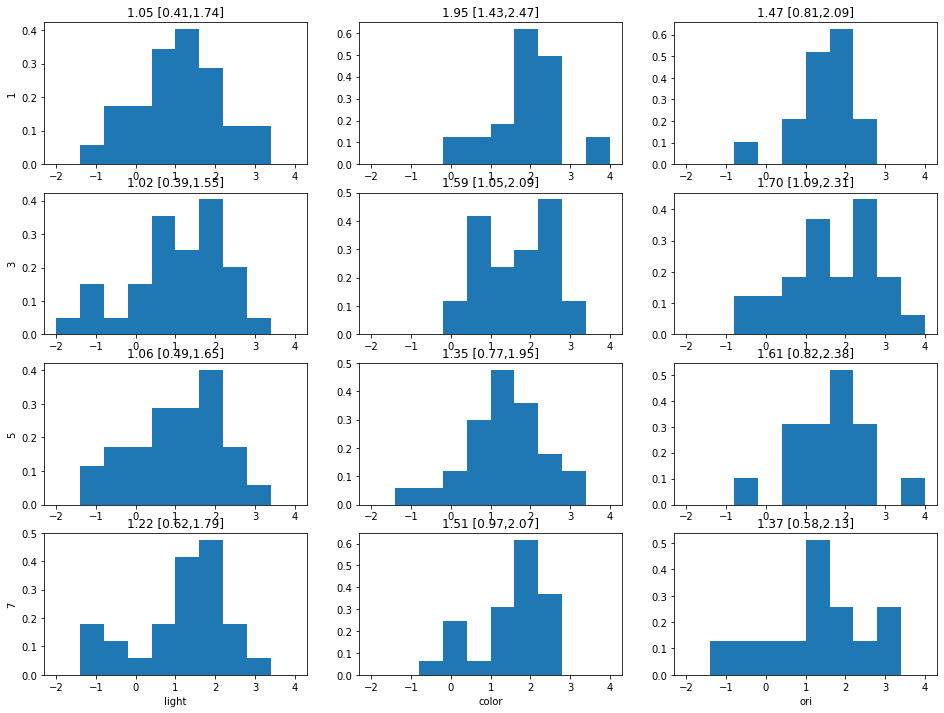

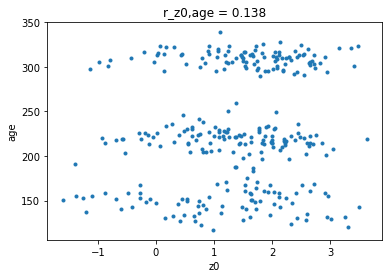

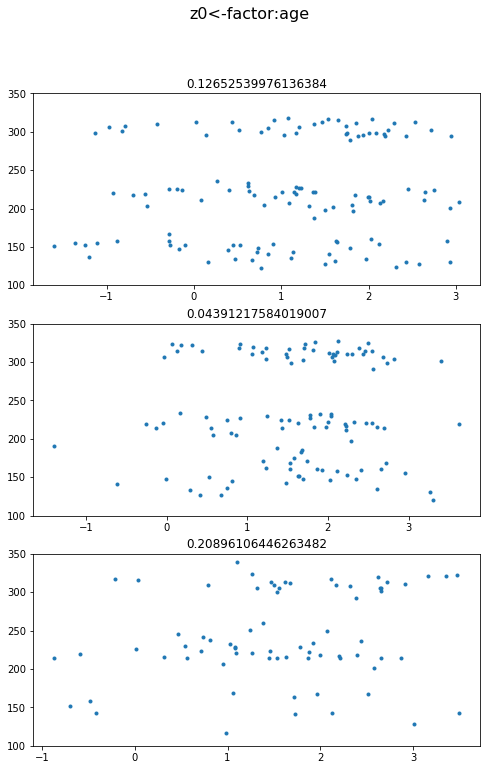

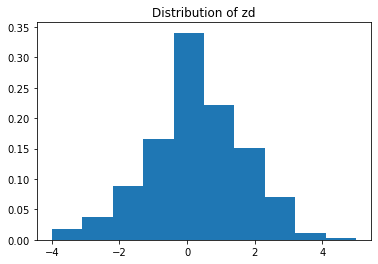

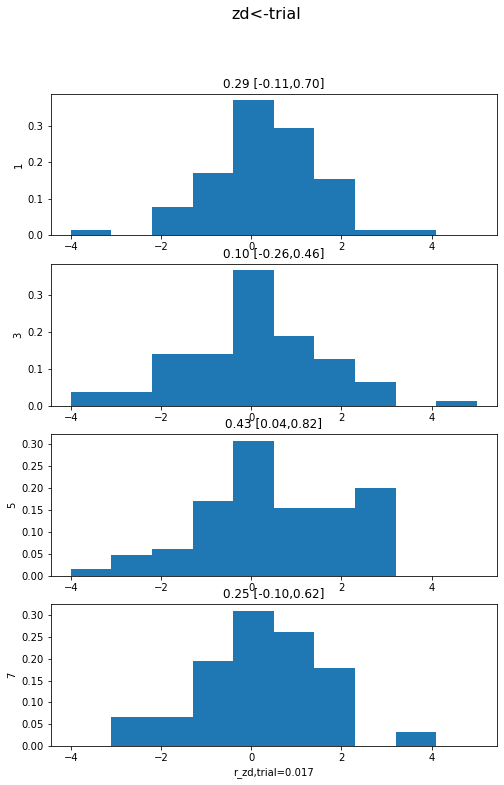

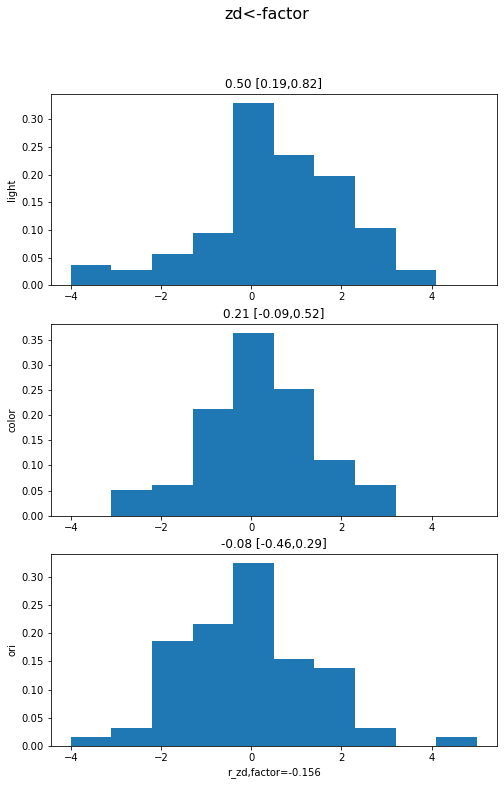

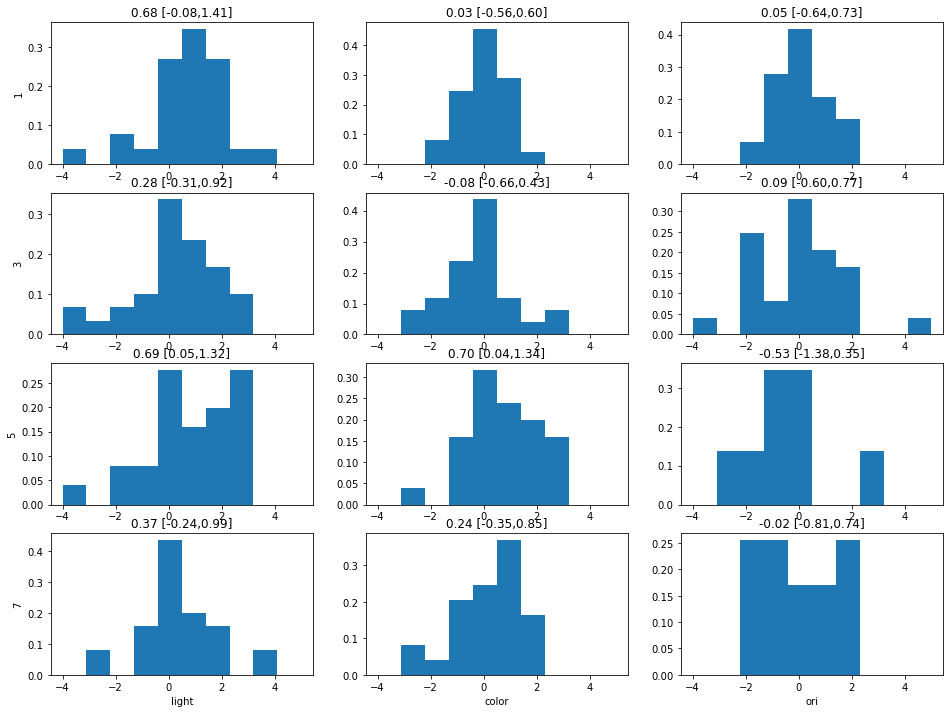

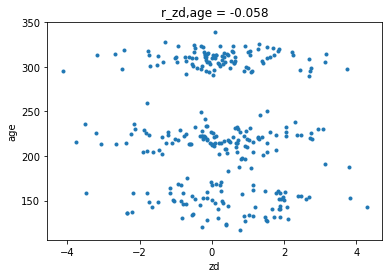

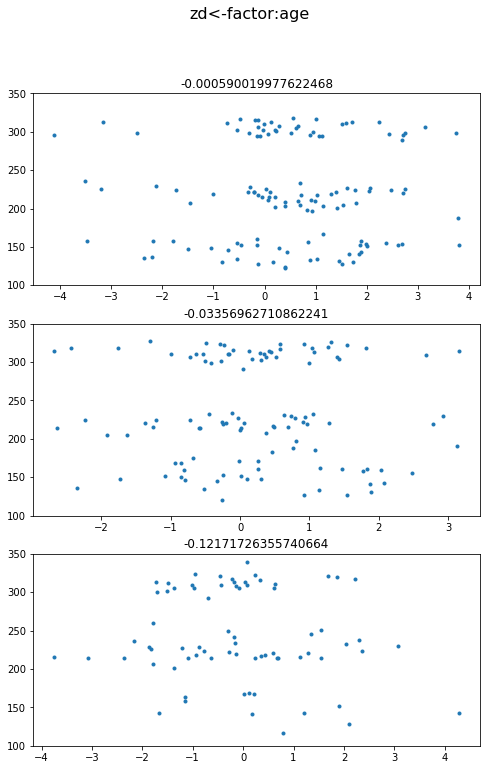

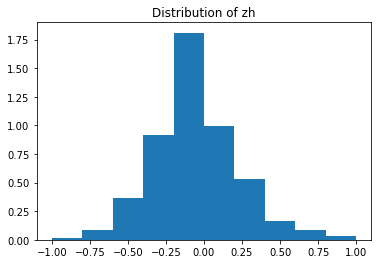

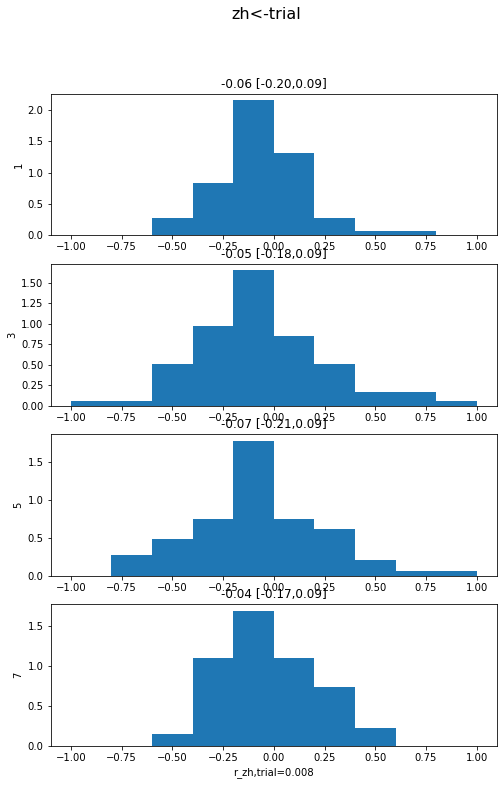

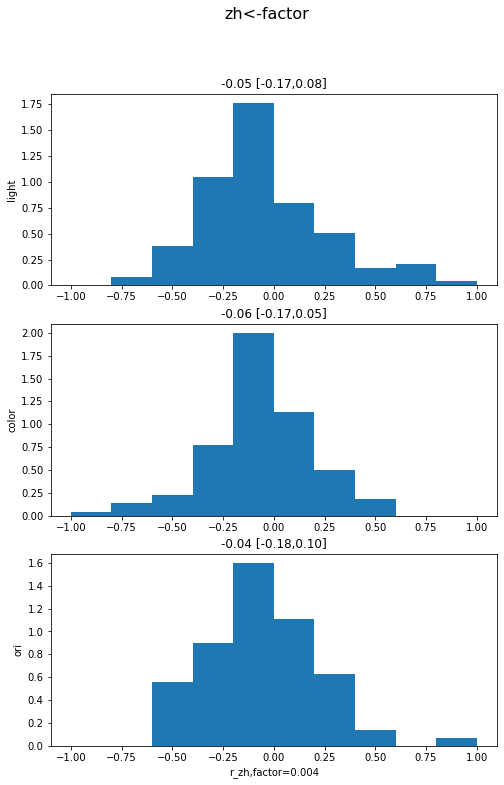

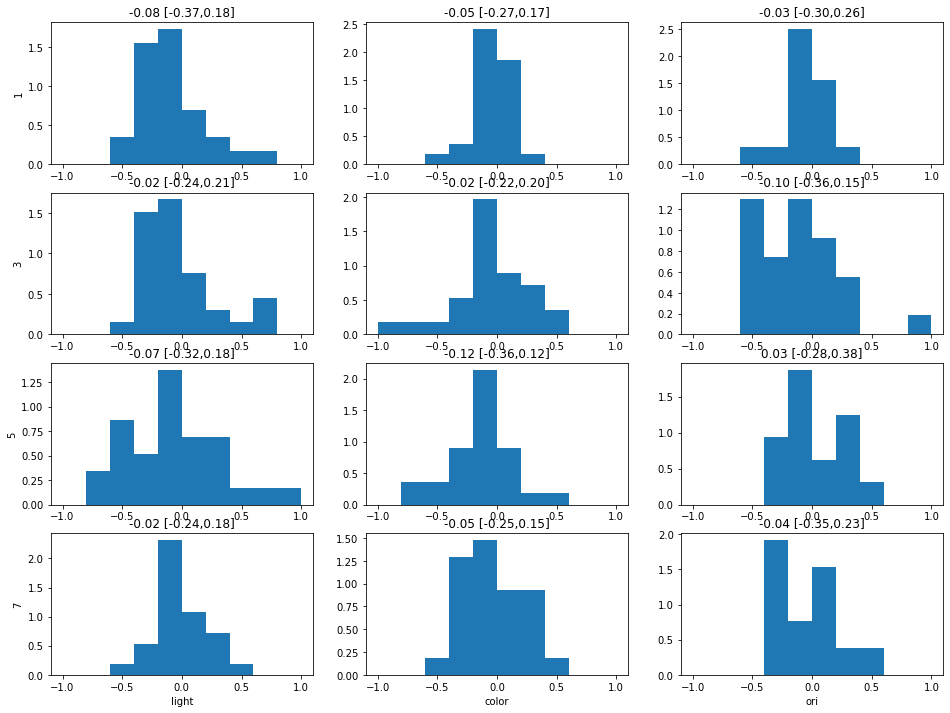

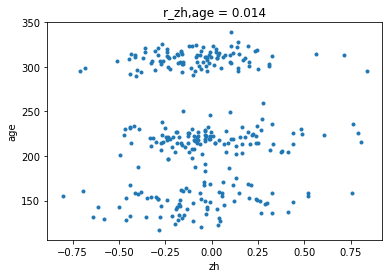

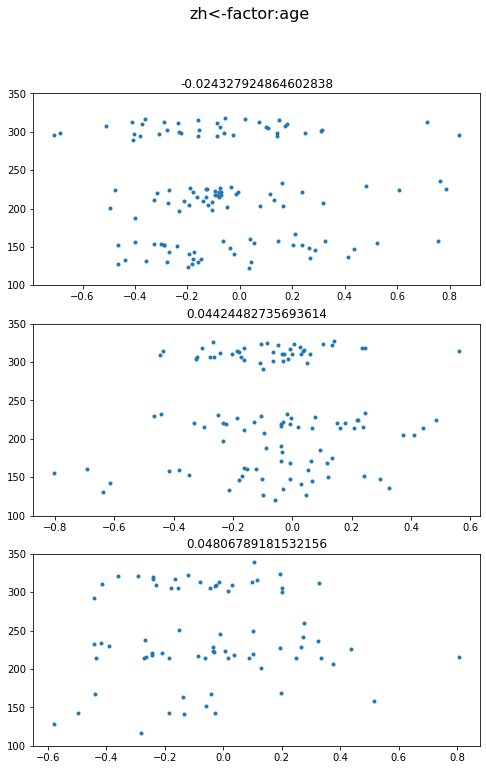

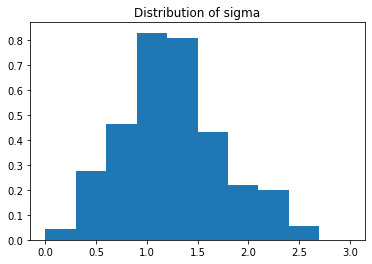

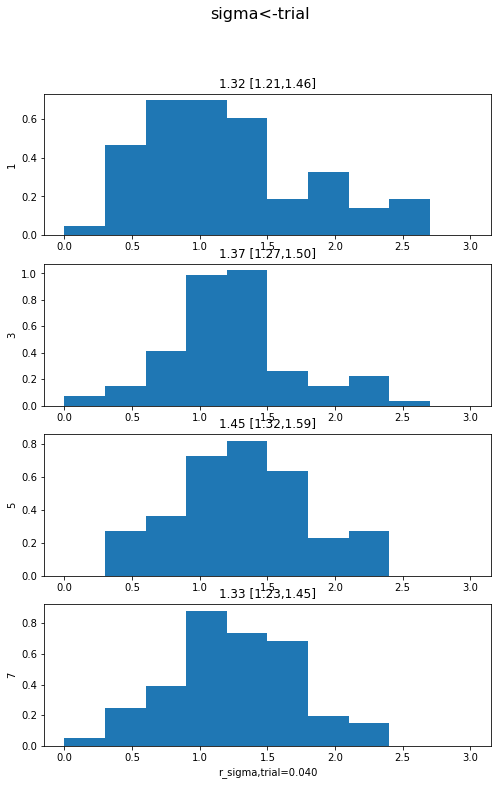

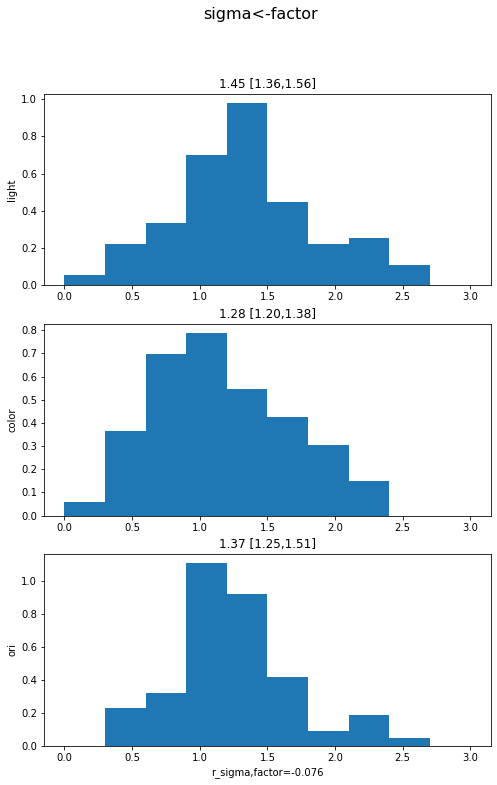

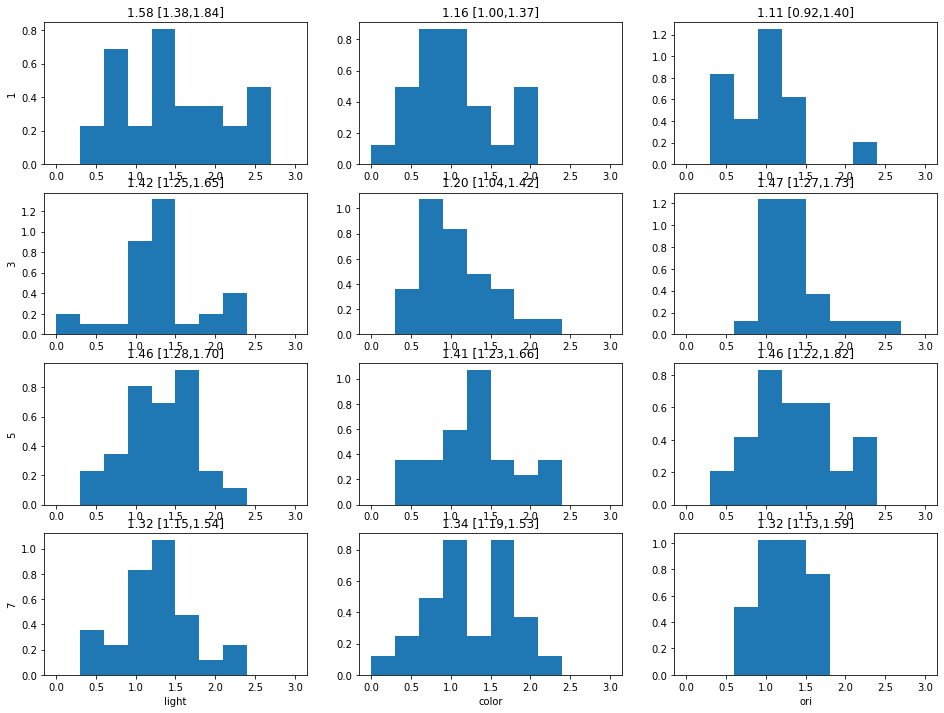

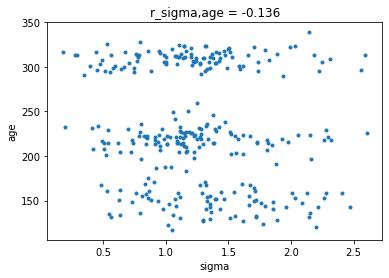

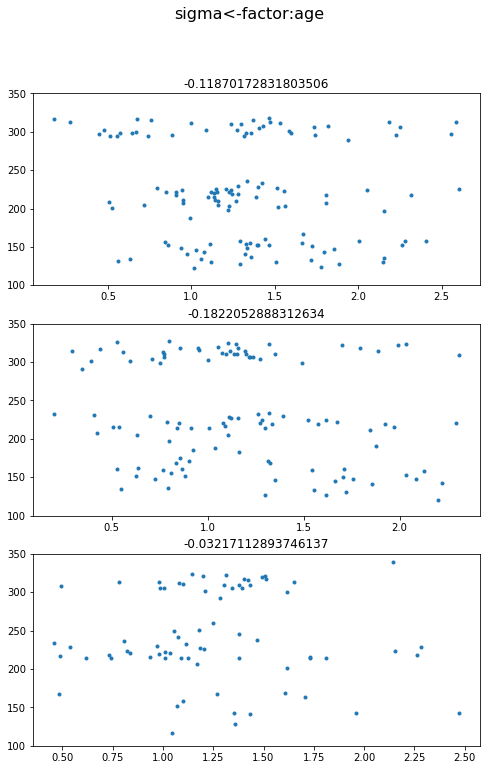

In [3]:
plotSmResults('LNNP',yLT,xAll,zlu=[[0,2.5],[0,2.5],[-2,4],[-4,5],[-1,1],[0,3],[0,3],[0,3]])

# Lognormal markov model partial-pooling

e0 (1200, 301)
ed (1200, 301)
z0 (1200, 301)
zd (1200, 301)
zh (1200, 301)
sigma (1200, 301)


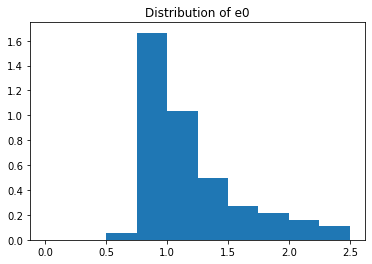

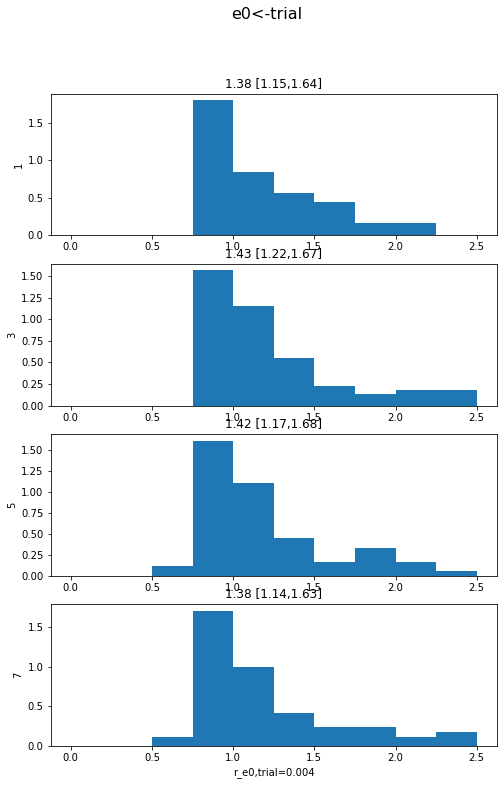

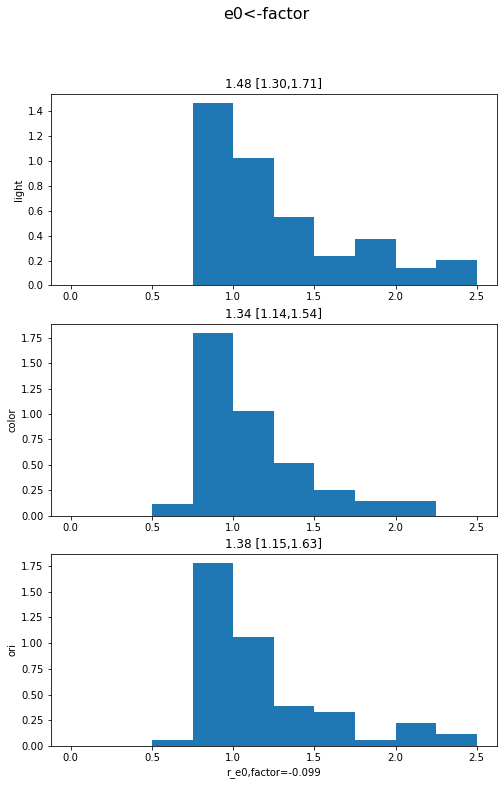

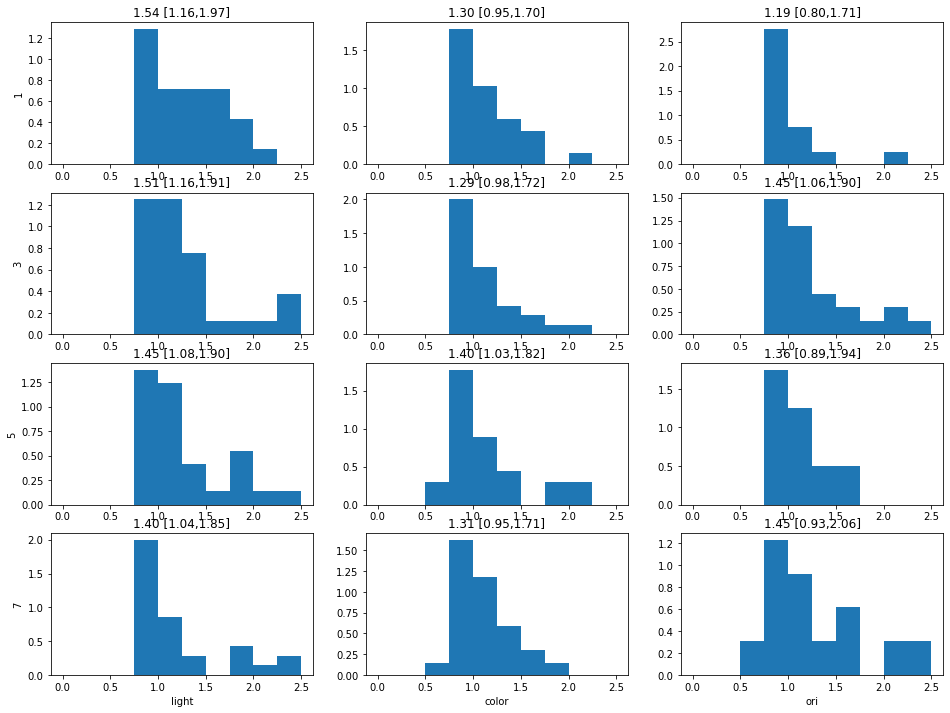

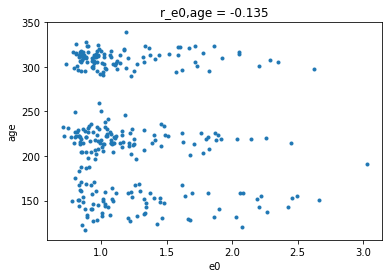

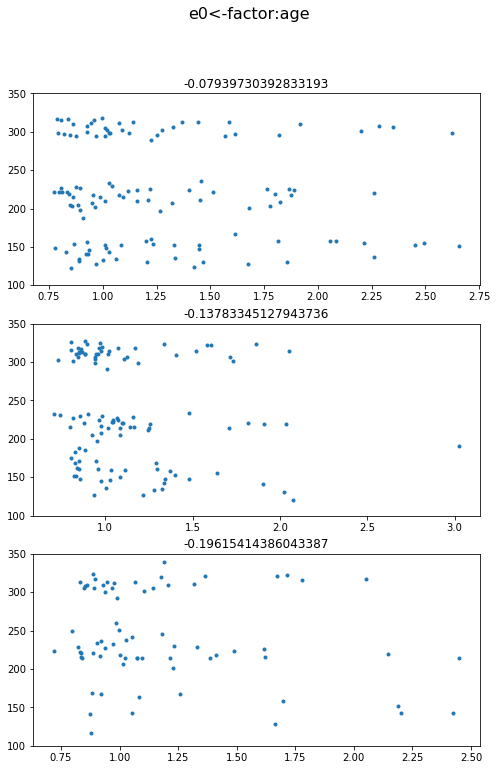

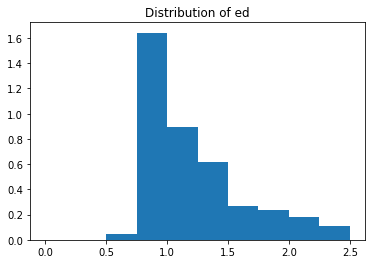

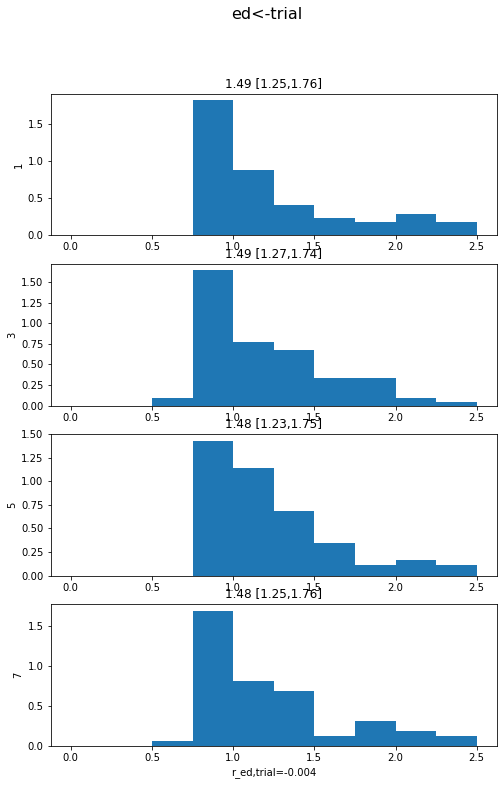

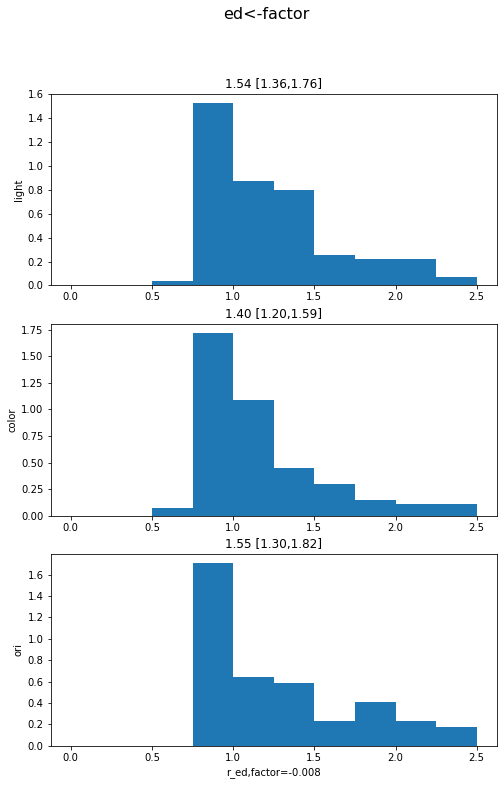

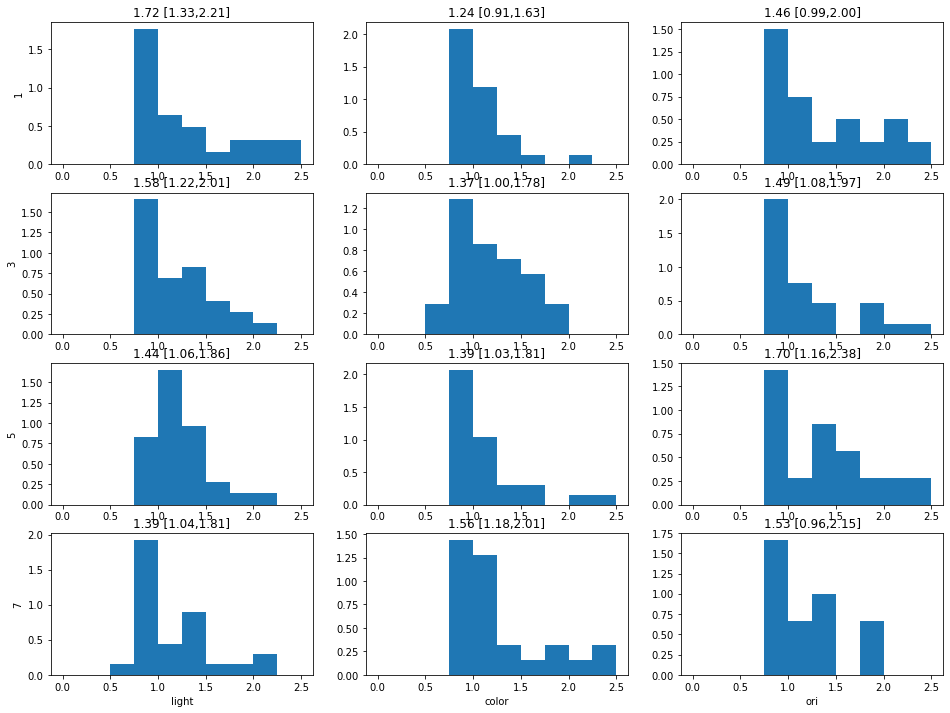

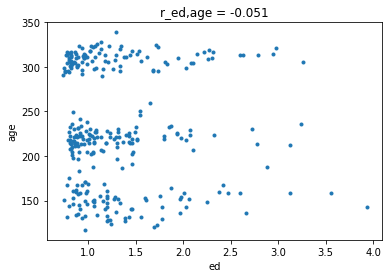

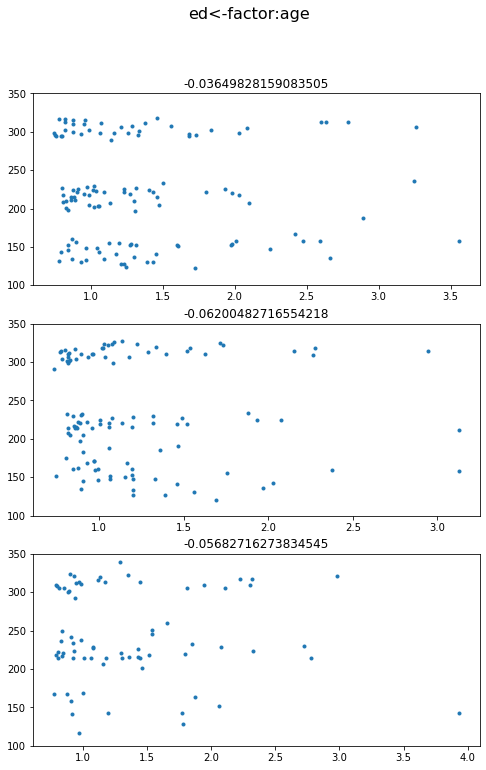

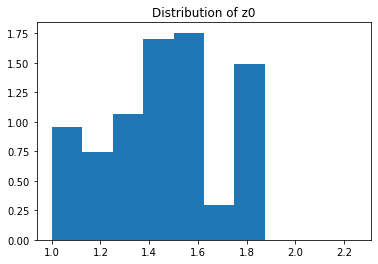

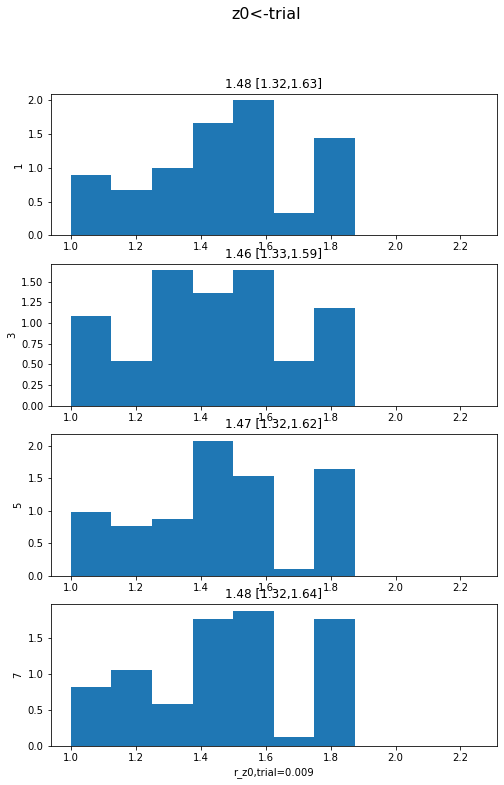

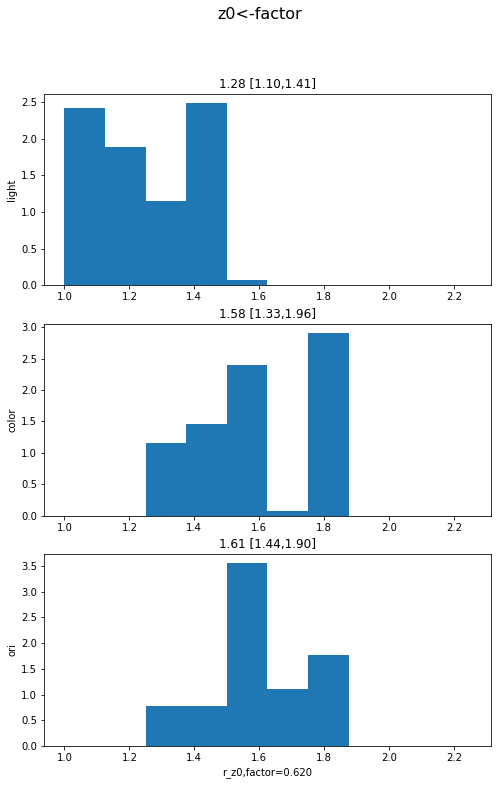

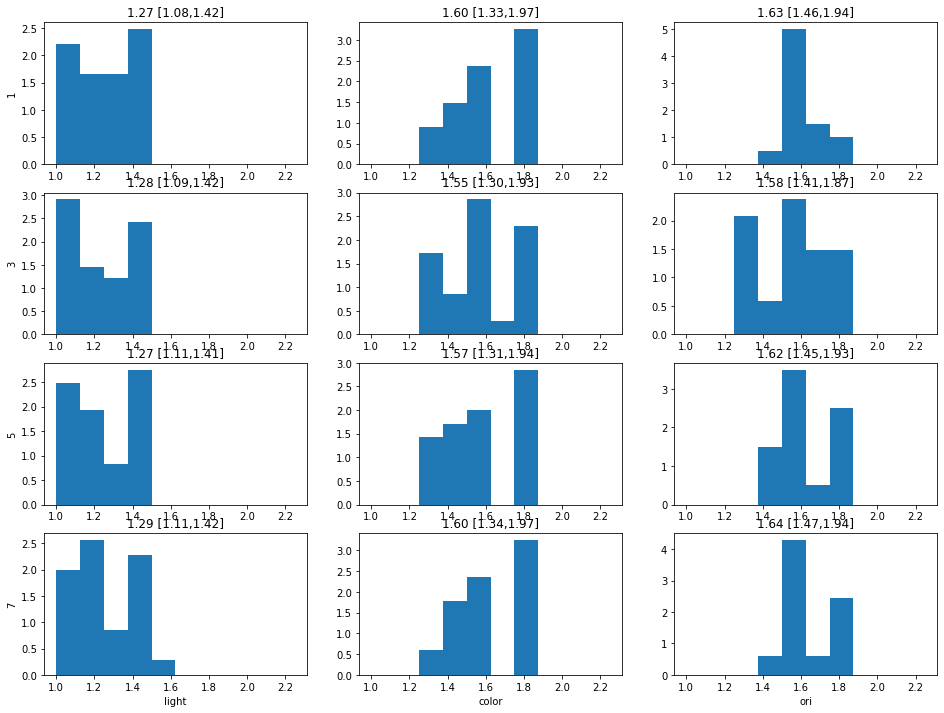

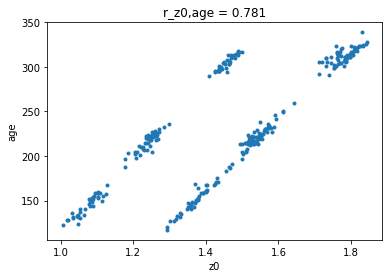

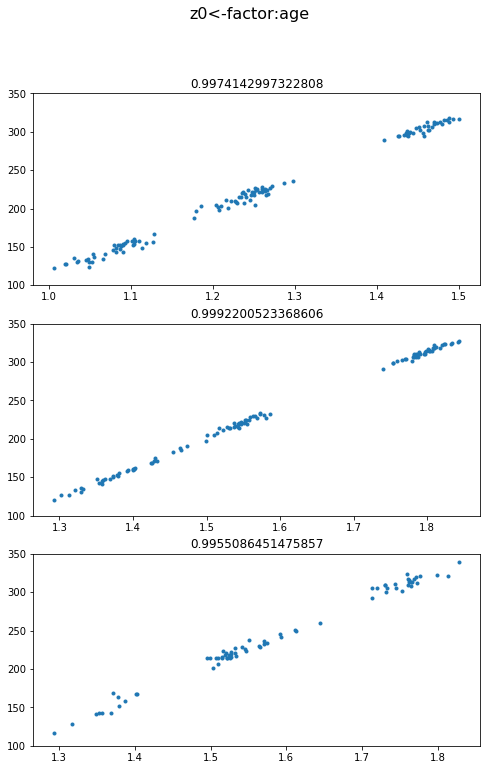

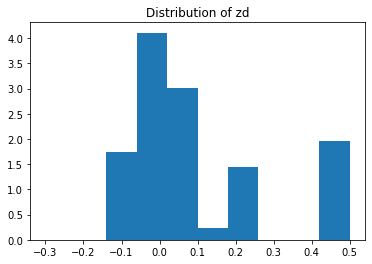

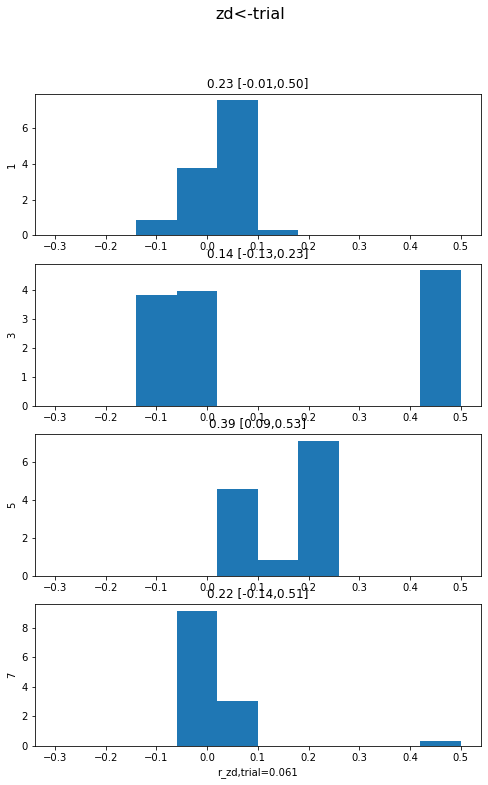

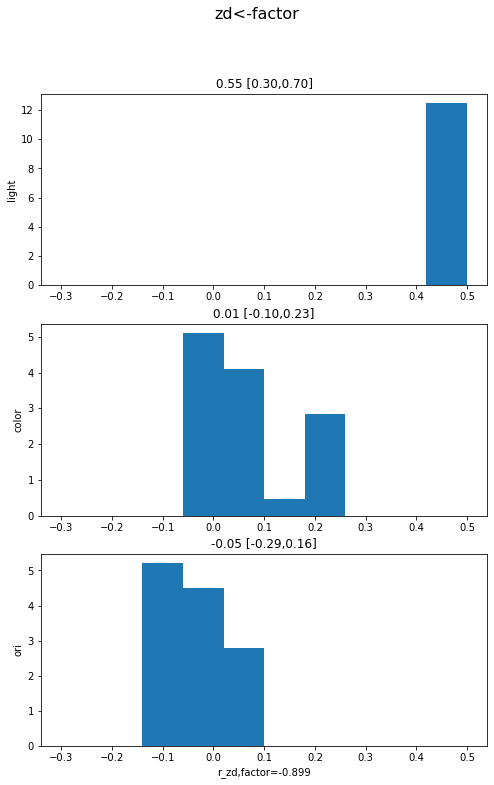

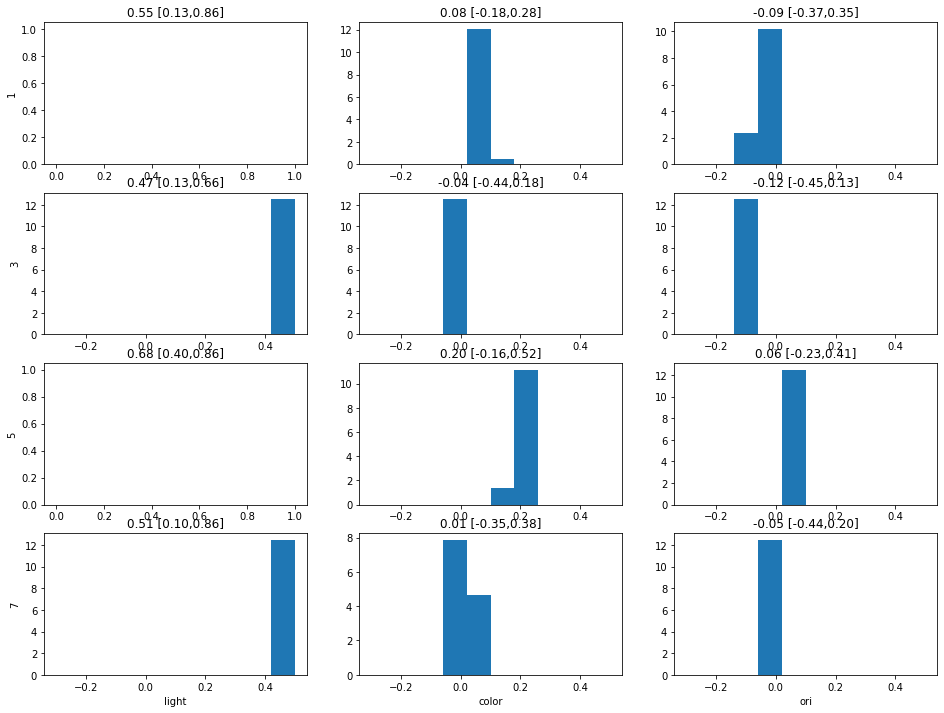

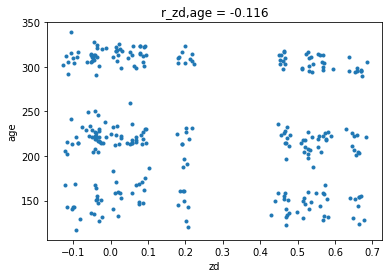

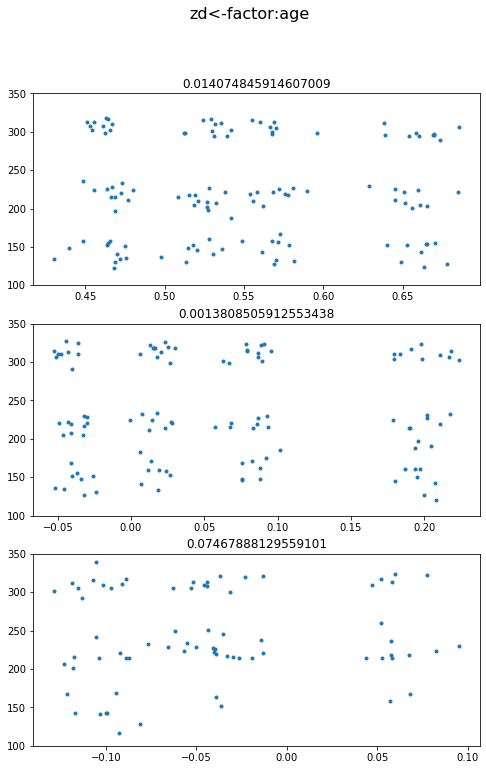

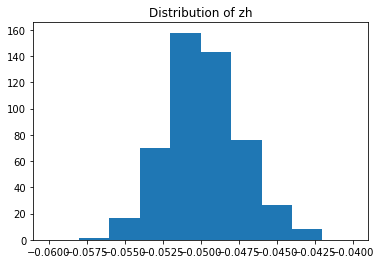

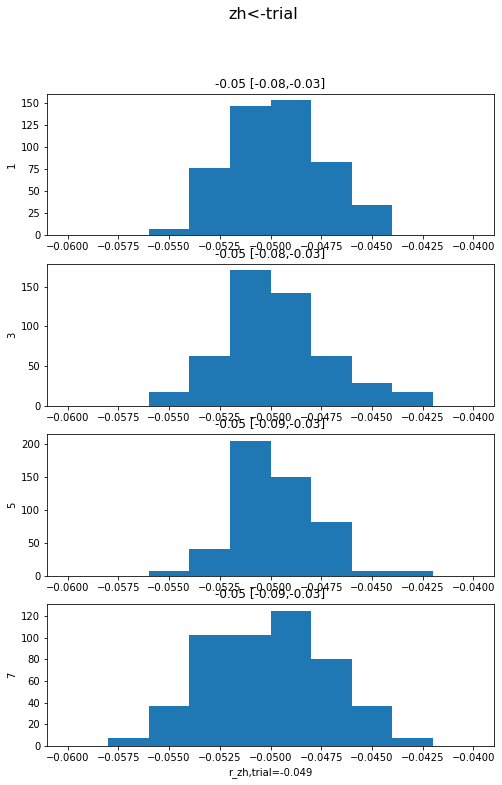

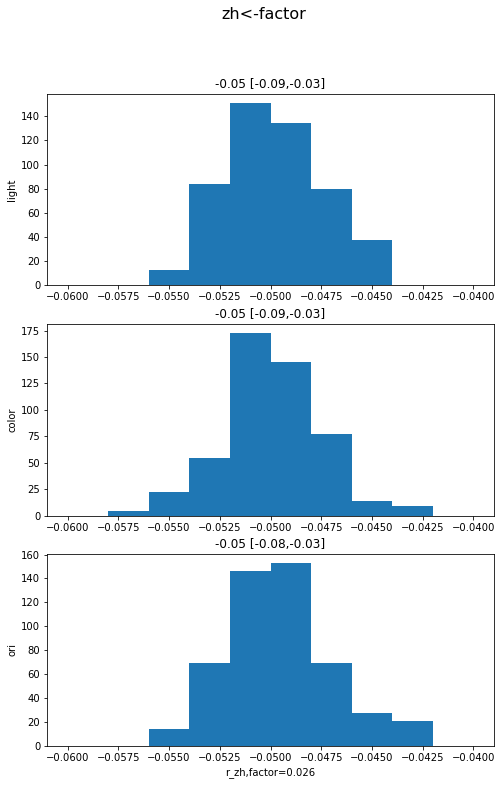

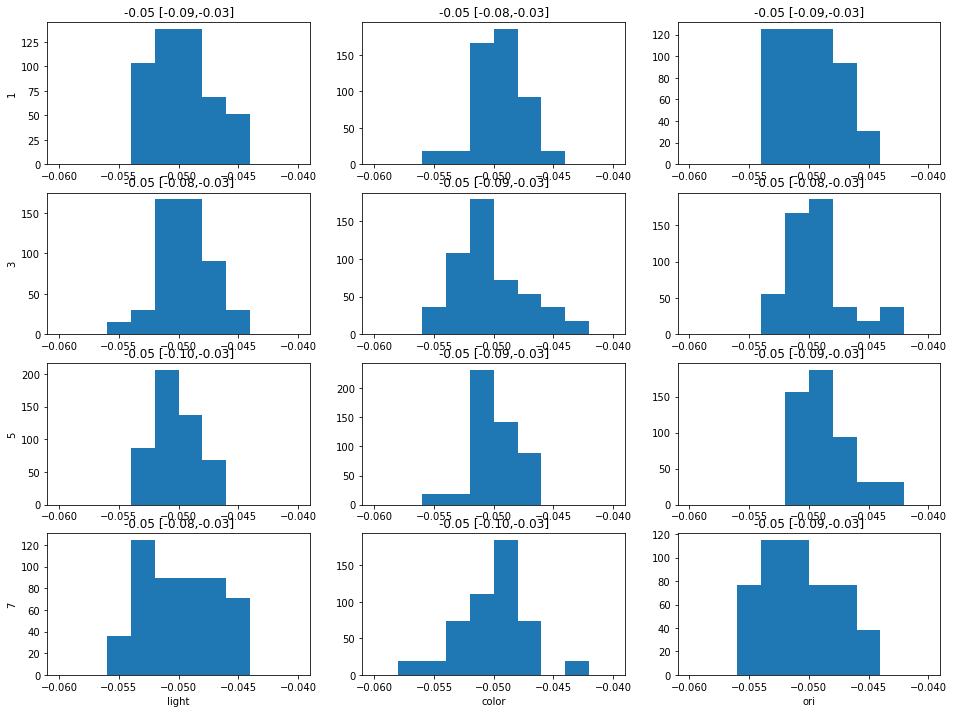

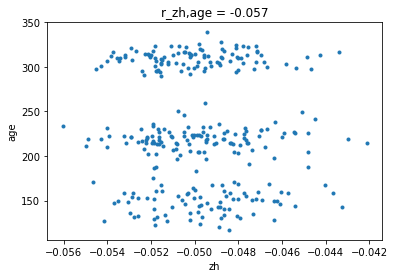

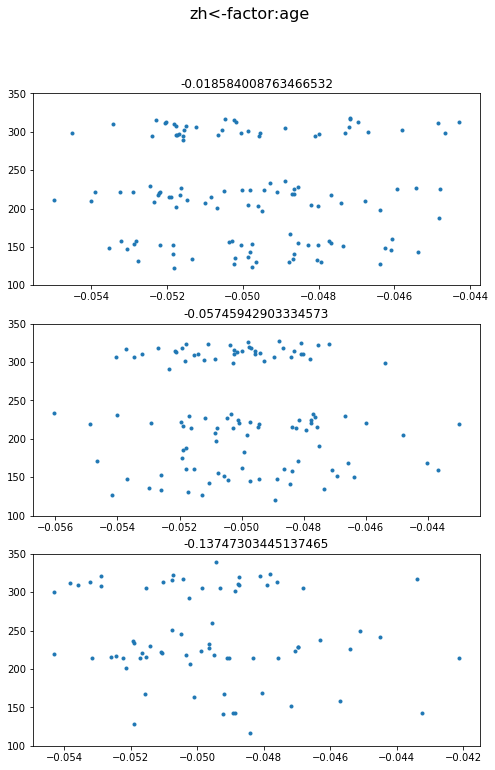

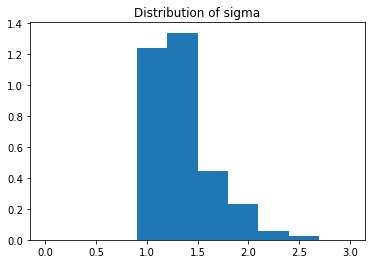

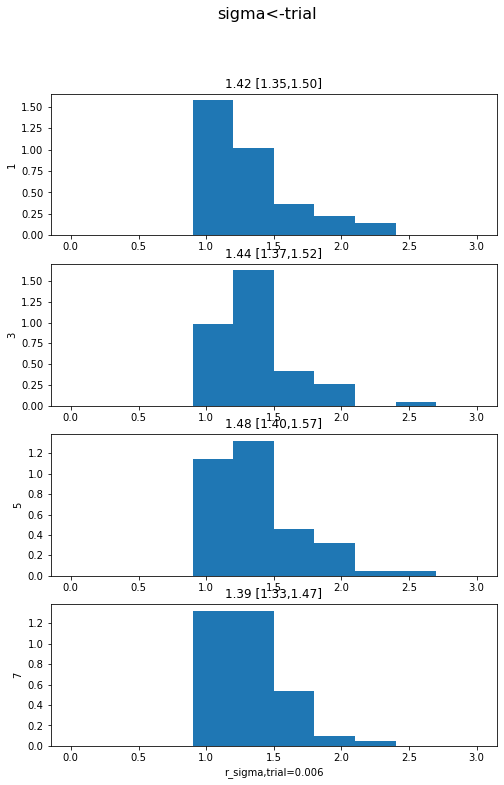

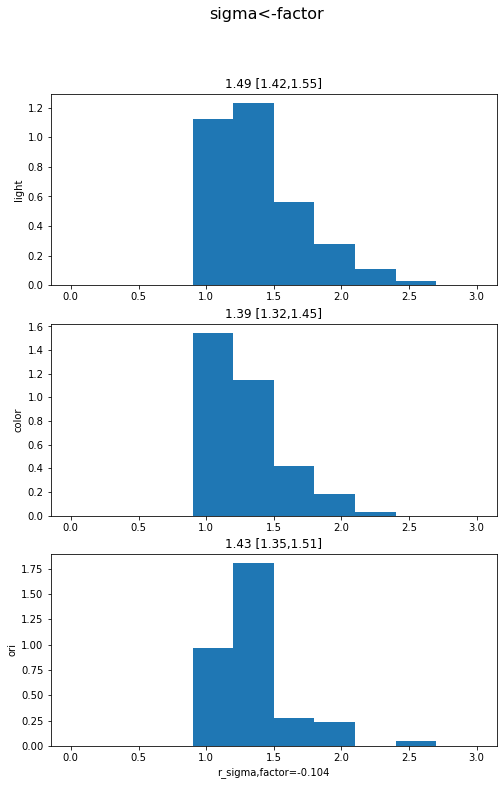

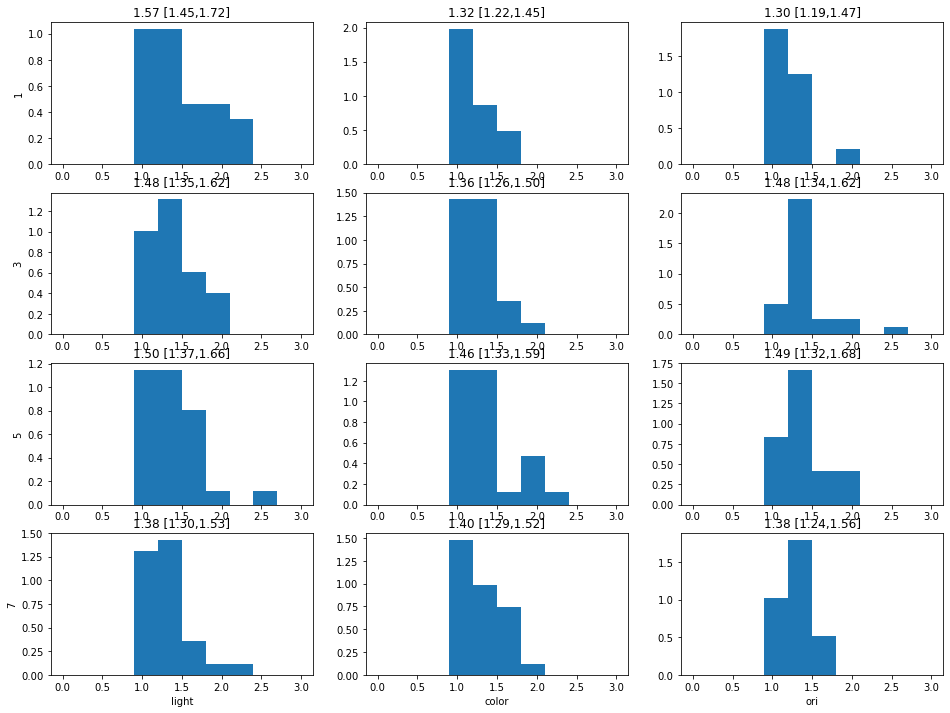

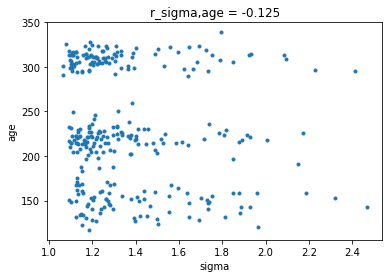

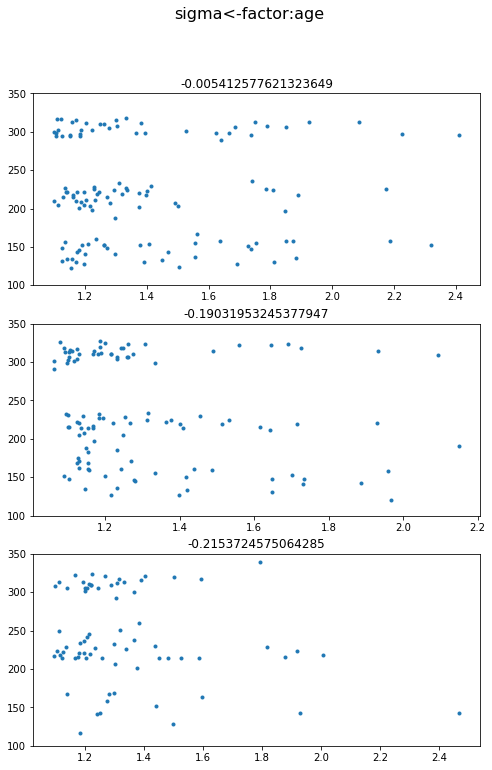

In [7]:
plotSmResults('LNMP',yLT,xAll,
    zlu=[[0,2.5],[0,2.5],[1,2.25],[-0.3,0.5],[-0.06,-0.04],[0,3],[0,3],[0,3]])

# Lognormal hidden markov model partial-pooling

e0 (1200, 301)
ed (1200, 301)
z0 (1200, 301)
zd (1200, 301)
zh (1200, 301)
sigmaY (1200, 301)
sigmaZ (1200, 301)


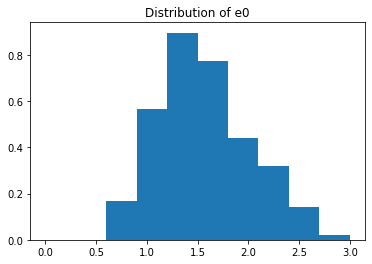

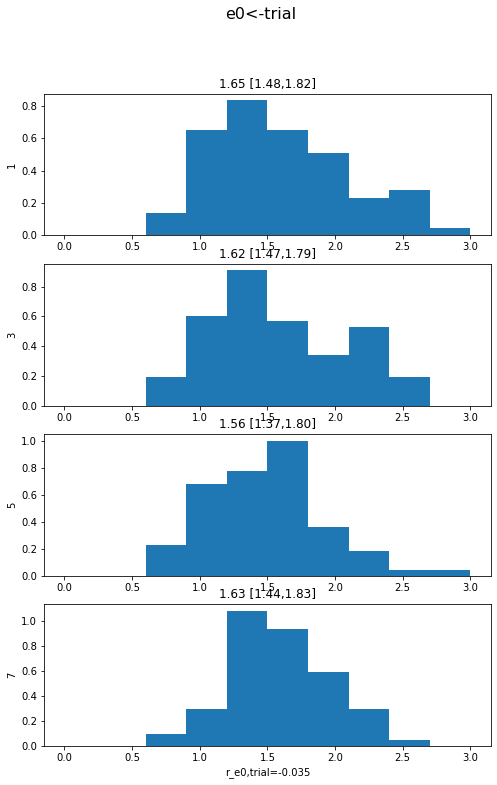

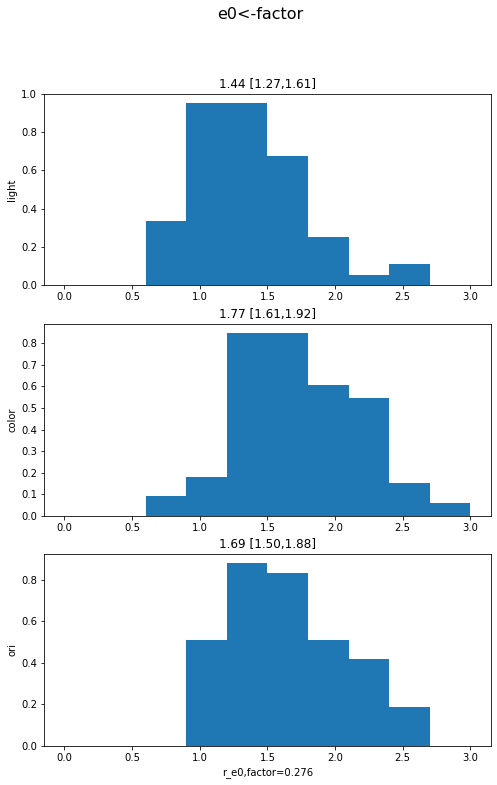

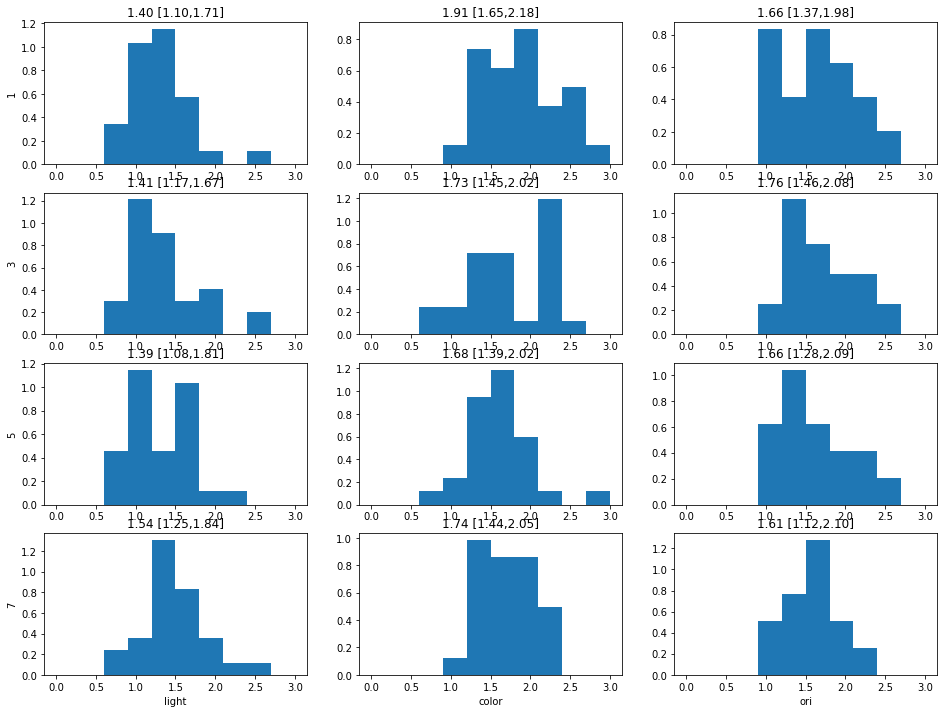

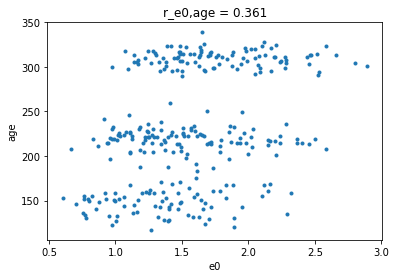

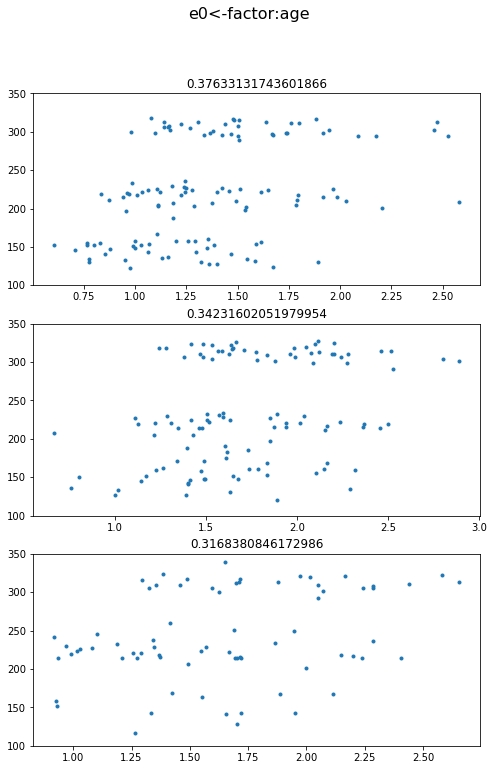

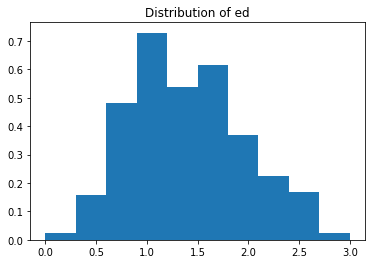

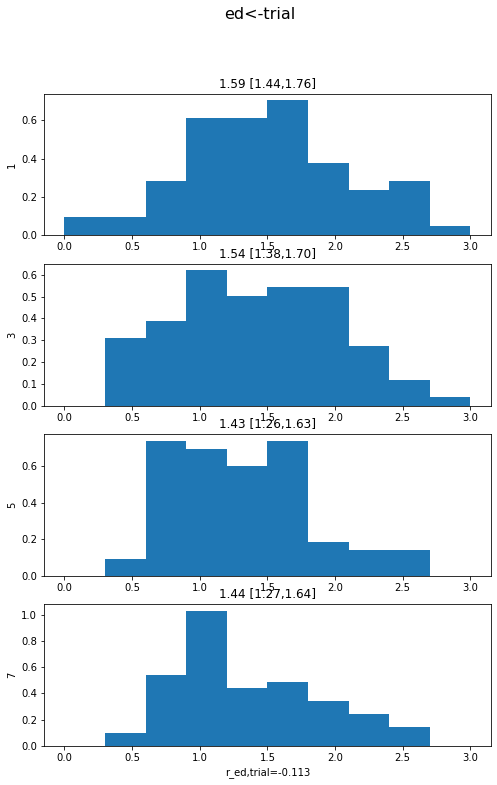

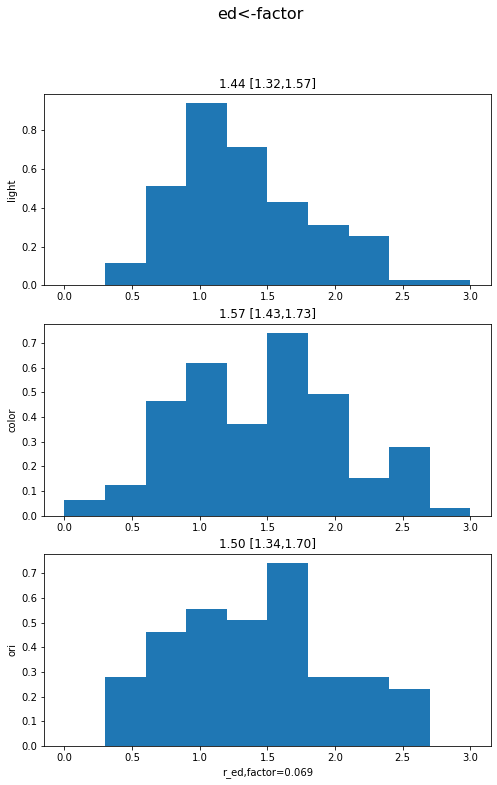

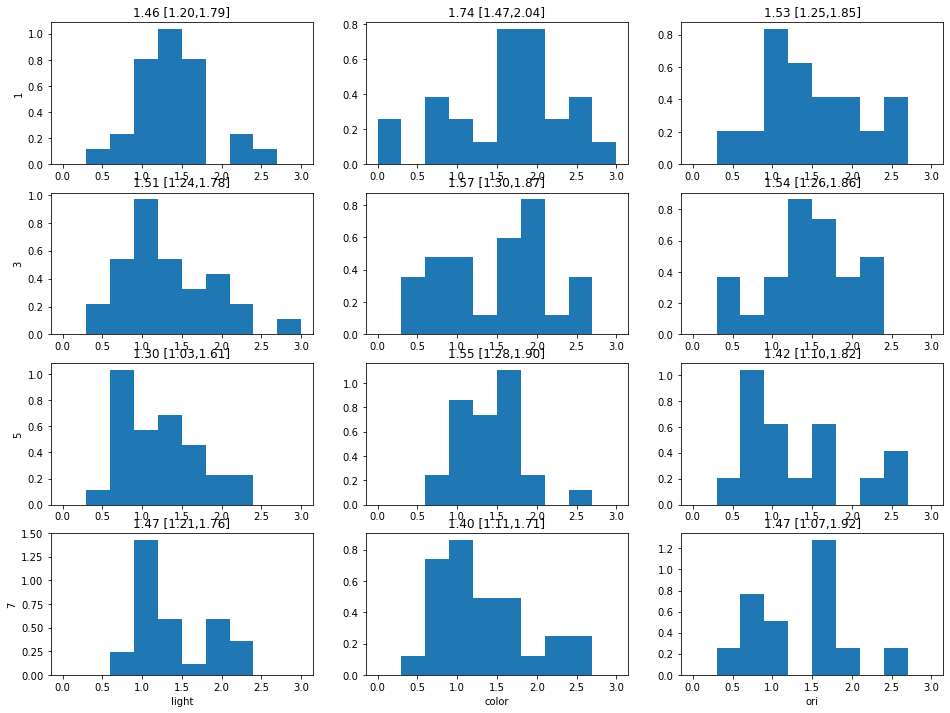

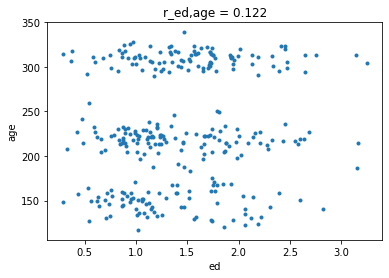

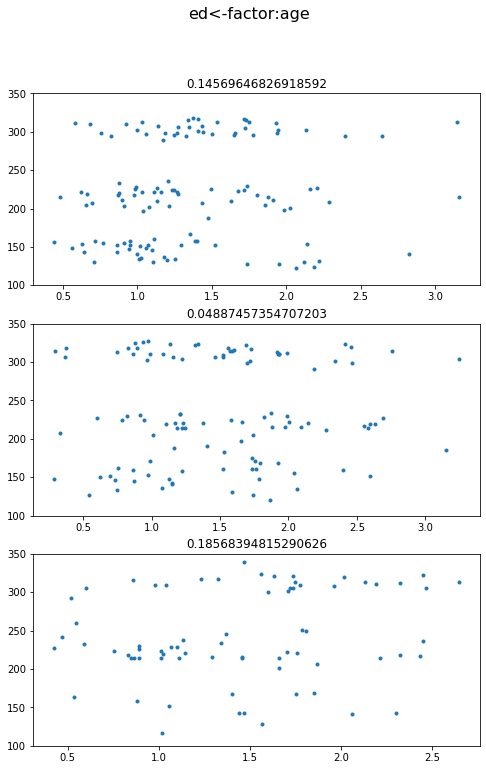

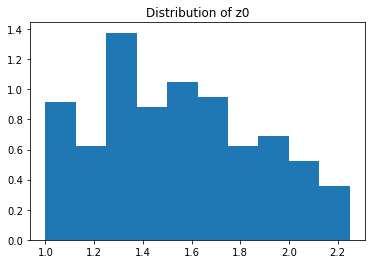

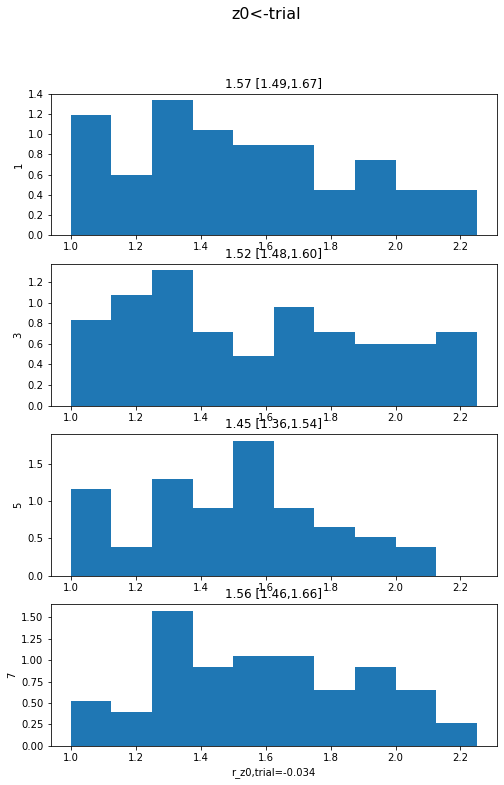

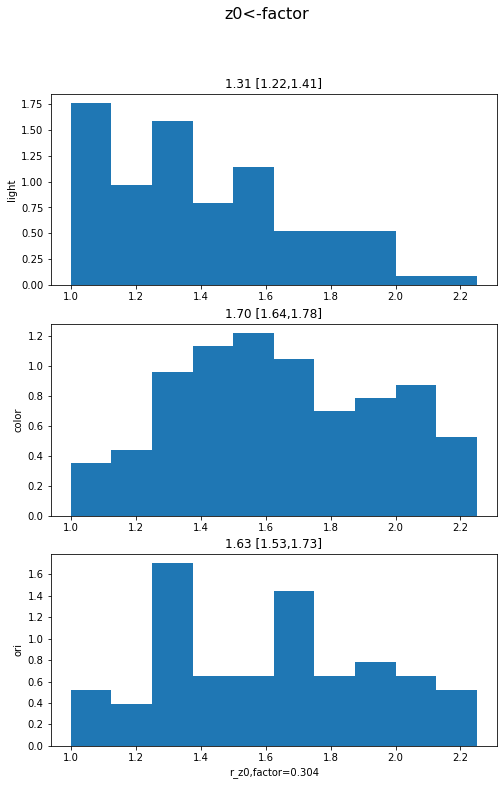

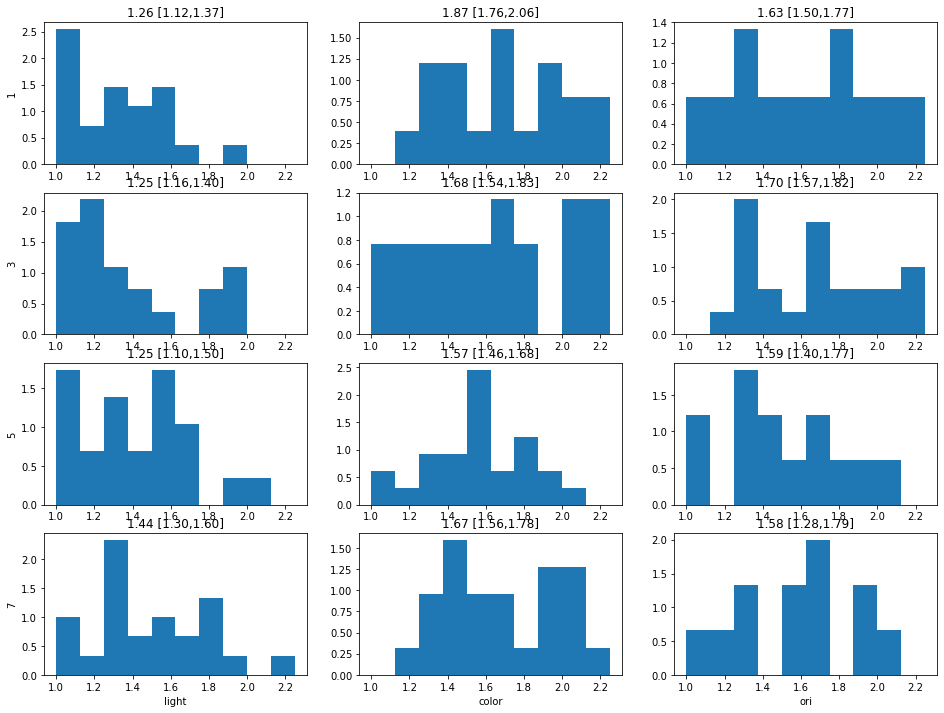

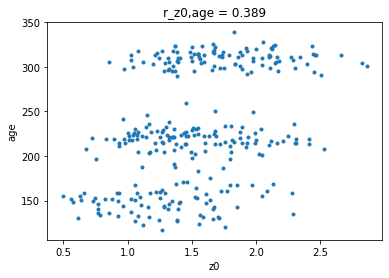

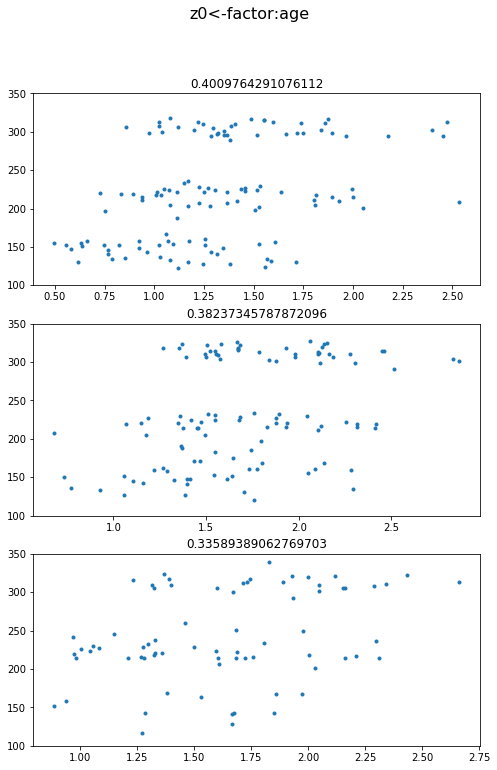

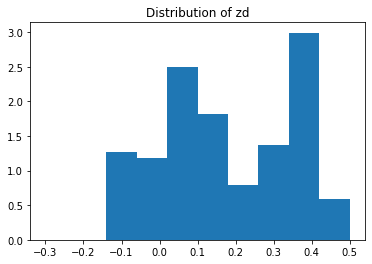

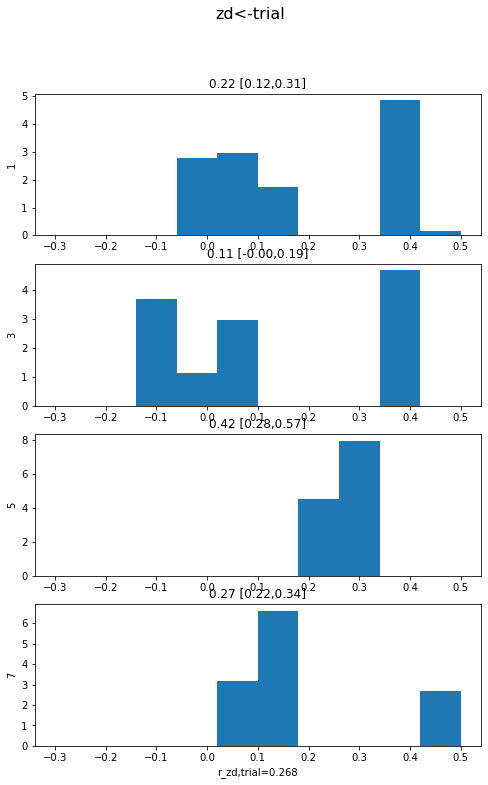

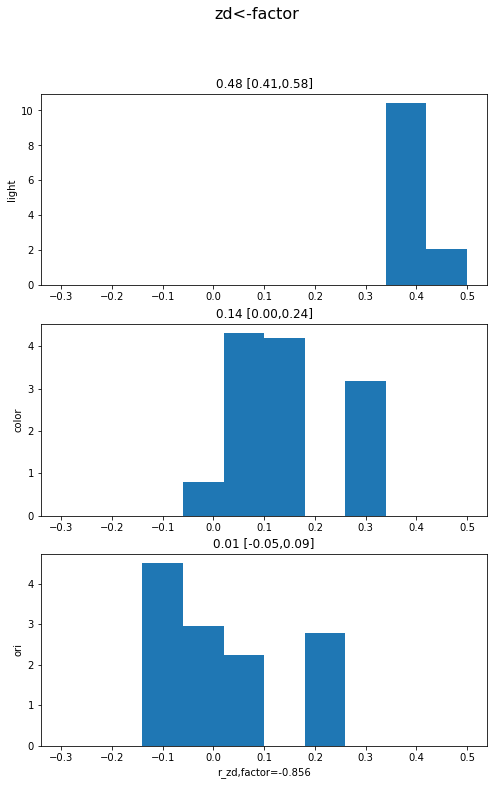

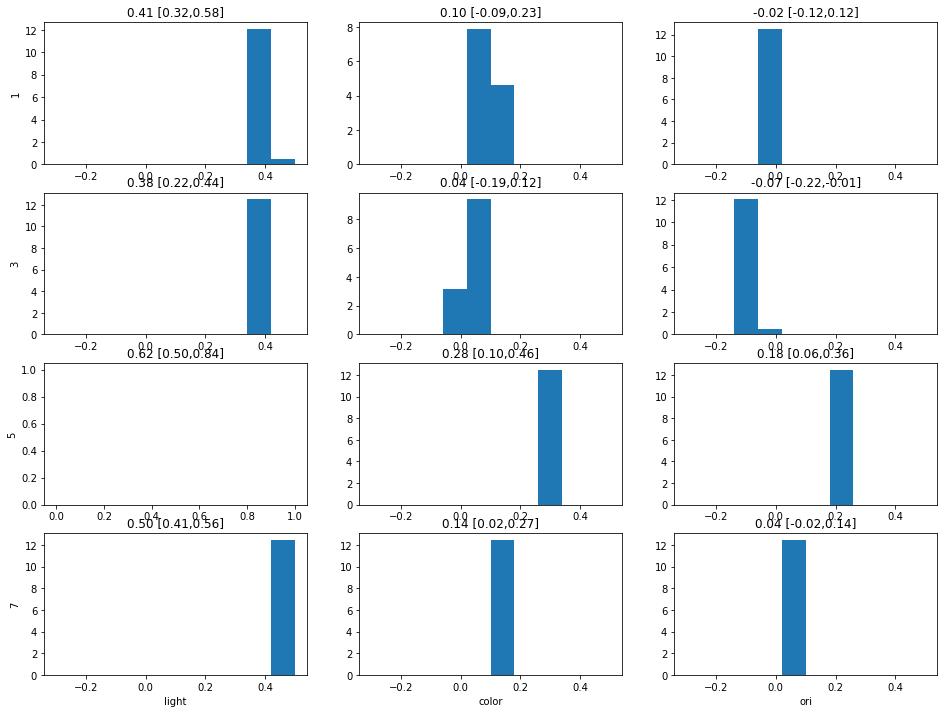

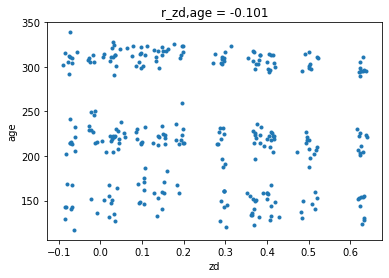

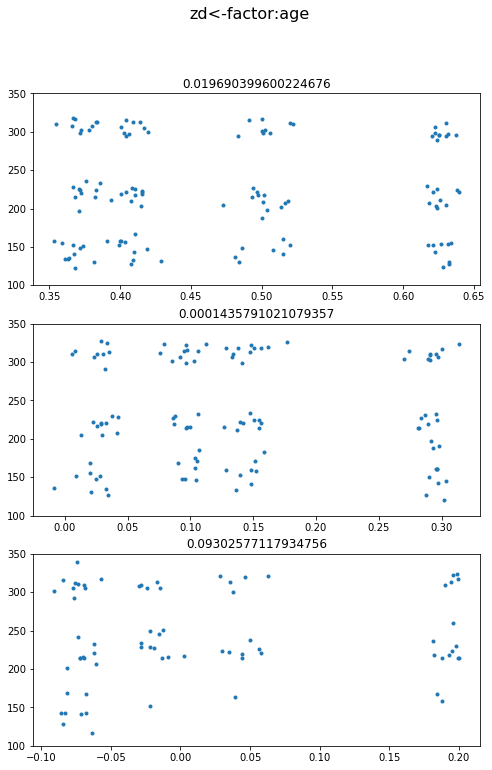

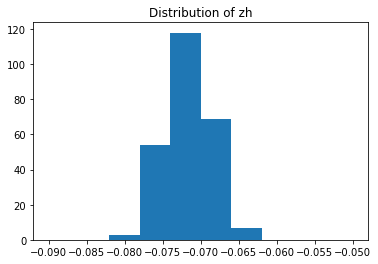

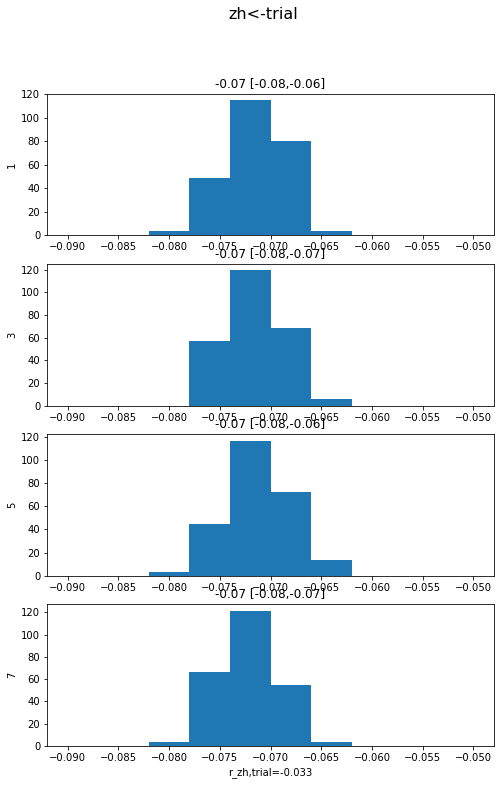

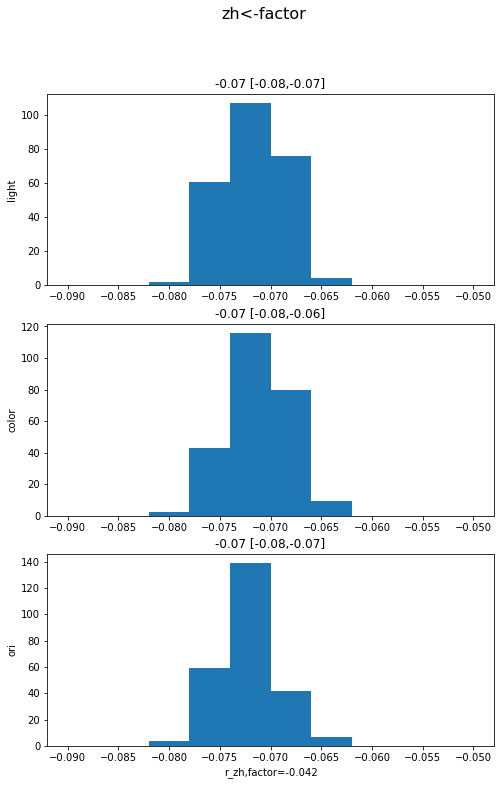

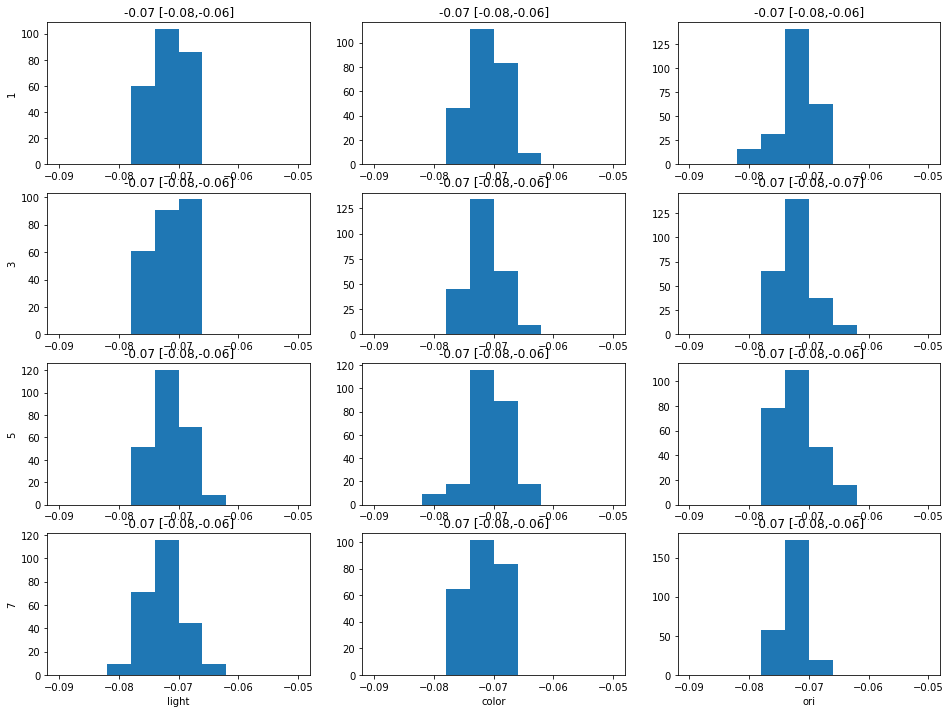

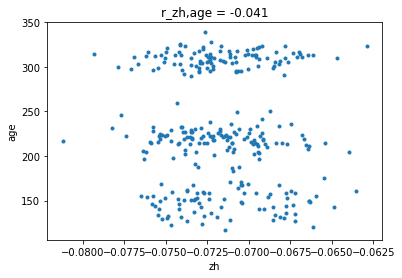

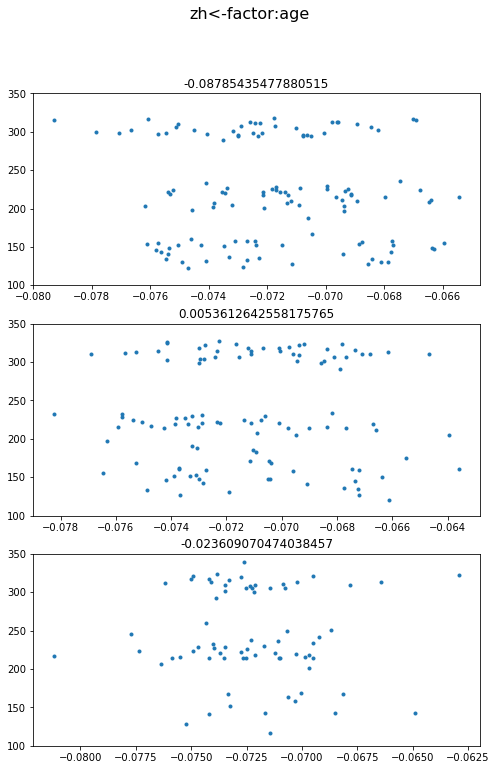

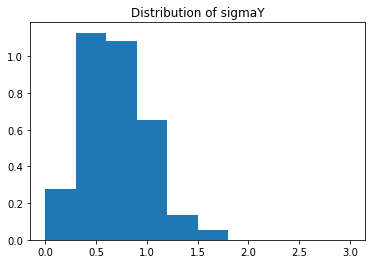

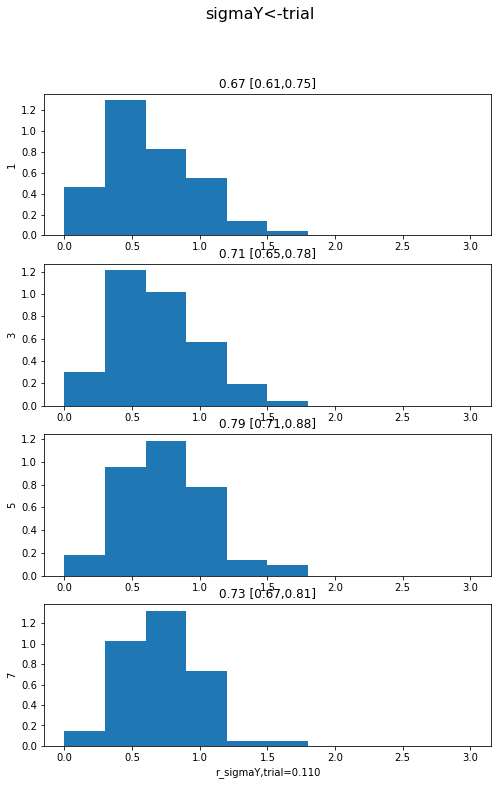

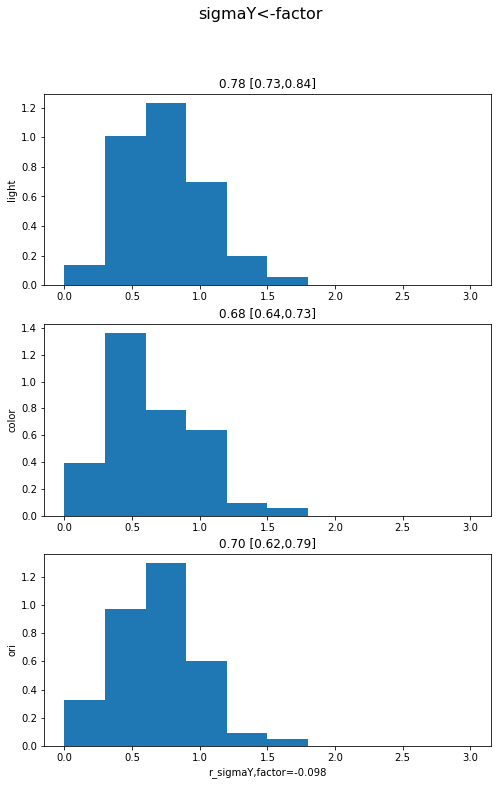

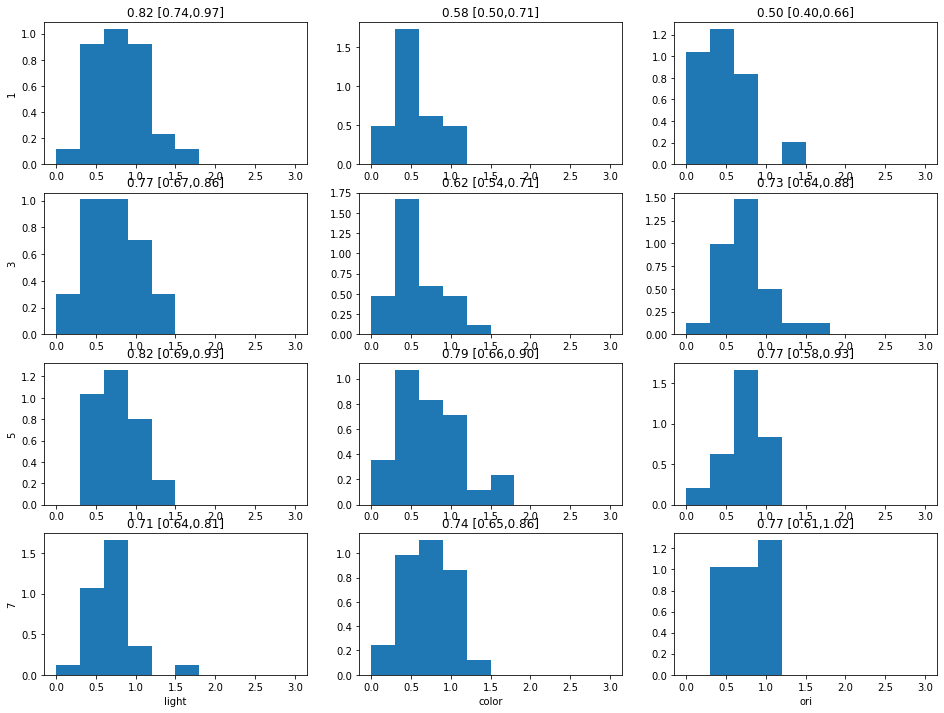

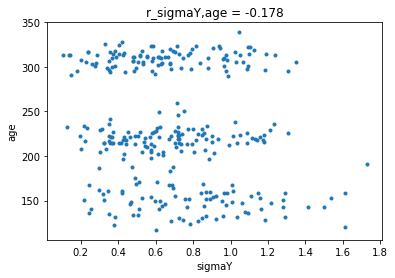

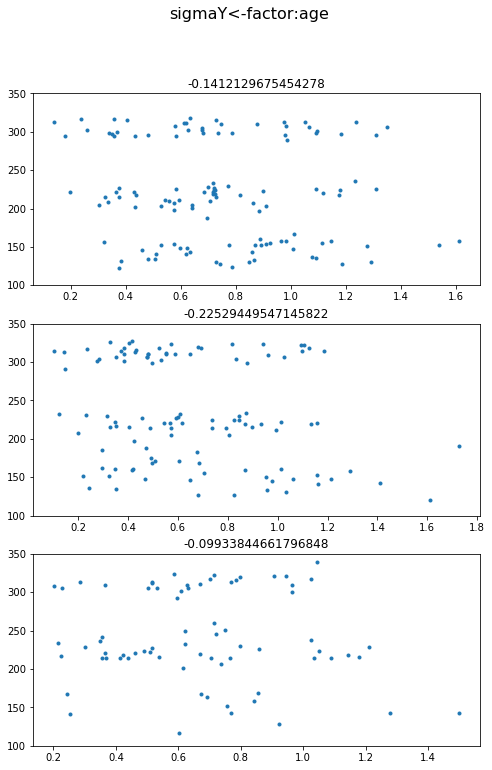

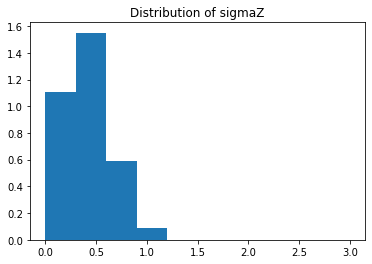

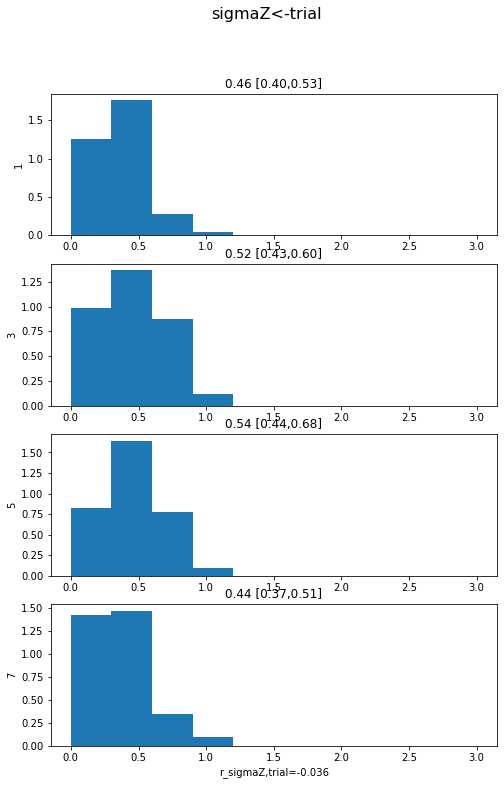

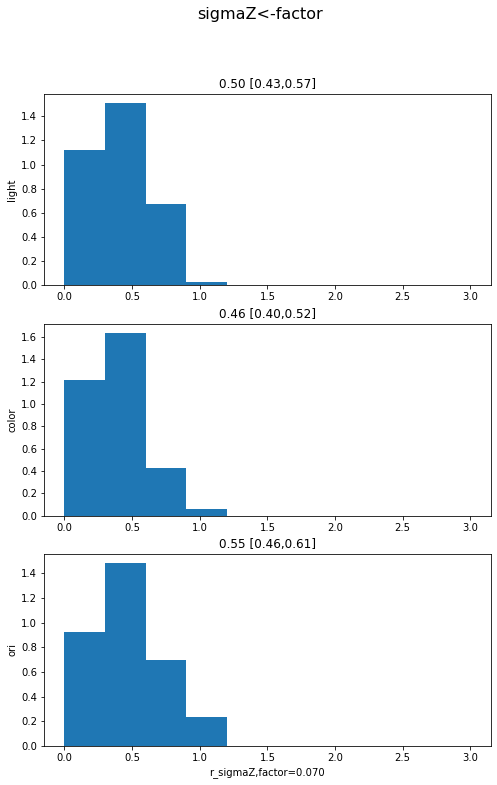

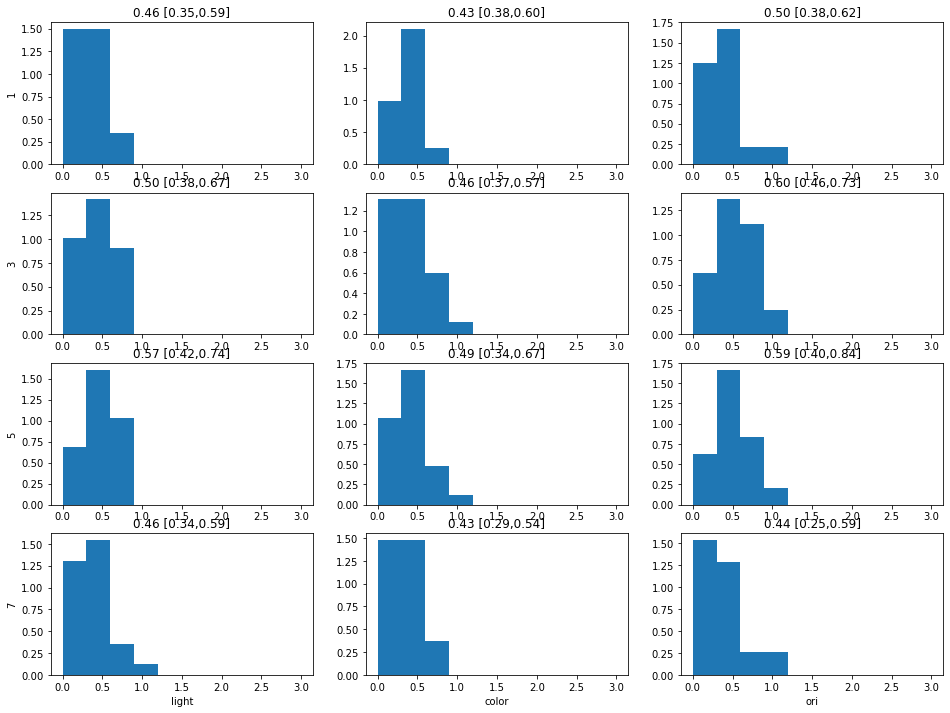

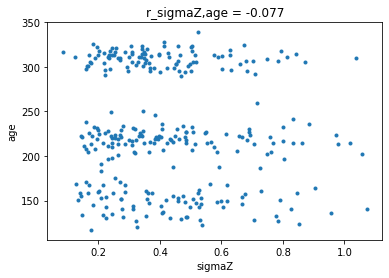

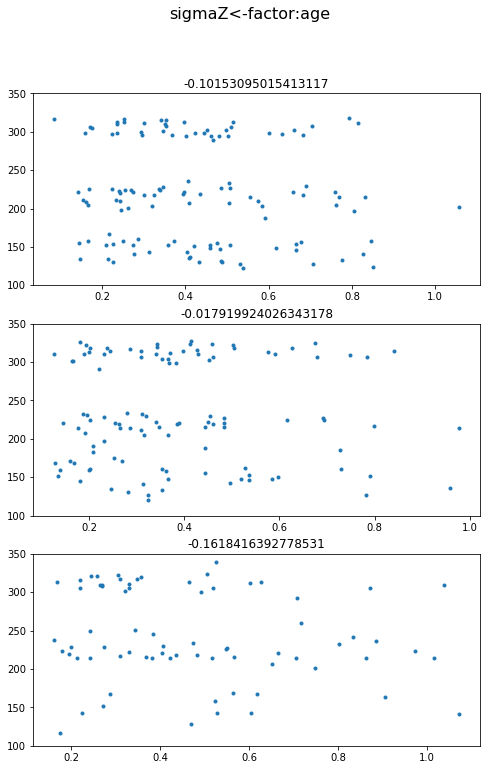

In [5]:
plotSmResults('LNHP',yLT,xAll,
    zlu=[[0,3],[0,3],[1,2.25],[-0.3,0.5],[-0.09,-0.05],[0,3],[0,3],[0,3]])

# Gamma distribution markov model partial-pooling

In [5]:
import pystan
invgammafun='''functions{
    vector invdigamma(vector x){
        vector[num_elements(x)] y; vector[num_elements(x)] L;
        for (i in 1:num_elements(x)){
            if (x[i]==digamma(1)){ 
                y[i]=1;
            }else{ if (x[i]>=-2.22){
                y[i]=(exp(x[i])+0.5);
            }else{
                y[i]=1/(x[i]-digamma(1));
        }}}
        L=digamma(y)-x;
        while (min(L)>10^-12){
            y=y-L ./trigamma(y);
            L=digamma(y)-x;
        }
        return y;}
    real invdigammaR(real x){
        real y; real L; int K;
        if (x==digamma(1)){ 
            y=1;
        }else{ if (x>=-2.22){
            y=(exp(x)+0.5);
        }else{
            y=1/(x-digamma(1));
        }}
        L=digamma(y)-x;K=0;
        while (L>10^-12 && K<10000){
            y=y-L ./trigamma(y);
            L=digamma(y)-x;
            K=K+1;
        }
        return y;
    }} '''

model = """
data {
    int<lower=0> N; //nr subjects
    real<lower=0> y[N,10];
    int<lower=1,upper=10> xSC[N];
    real xA[N];
    int<lower=0,upper=4> xD[N];
}parameters {
    real<lower=1,upper=20> sigma[N];
    real z0[N];
    real zd[N];
    real zh[N];
    real<lower=0,upper=20> zhs;
    real<lower=0,upper=20> zds;
    real<lower=0,upper=20> z0s;
    real<lower=-100,upper=100> zhm;
    real<lower=-100,upper=100> zdmd[3];
    real<lower=-100,upper=100> zdt[4];
    real<lower=-100,upper=100> z0m[3];
    real<lower=-100,upper=100> z0a;
} transformed parameters {
    real<lower=-100,upper=100> zdm[3];
    zdm[1]=0;
    zdm[2]=zdmd[2]-zdmd[1];
    zdm[3]=zdmd[3]-zdmd[1];
}model {
for (n in 1:N){
    sigma[n]~cauchy(0,2);
    zh[n]~normal(zhm,zhs);
    zd[n]~normal(zdmd[xD[n]] +zdt[xSC[n]/2],zds);
    z0[n]~normal(z0m[xD[n]]+z0a*xA[n],z0s);
    y[n,1]~gamma(invdigamma(z0[n]-sigma[n]),sigma[n]);
    for (t in 2:10)
        if (y[n,t]>0)
            y[n,t]~gamma(invdigamma(log(y[n,t-1])+zh[n]+(xSC[n]==t)*zd[n]-sigma[n]),sigma[n]);
}}generated quantities {
real r[N,10];
for (n in 1:N){
    r[n,1]=log(gamma_rng(invdigamma(z0[n]),sigma[n]))-log(y[n,1]);
    for (t in 2:10)
        if (y[n,t]>0)
            r[n,t]=gamma_rng(log(y[n,t-1])+zh[n]+(xSC[n]==t)*zd[n],sigma[n])-log(y[n,t]);
        else
            r[n,t]=0;
}}
"""
#smGMP = pystan.StanModel(model_code=invgammafun+model)

In [9]:
model = """
data {
    int<lower=0> N; //nr subjects
    real<lower=0> K; 
    real<lower=0> y[N,10];
    int<lower=1,upper=10> xSC[N];
}parameters{
    real z0[N];
    real zh[N];
    real zd[N];
    real z0m;
    real zhm;
    real zdm;
    real sigma;
}model{
    for (n in 1:N){
        //z0[n]~normal(z0m,1);
        zd[n]~normal(zdm,1);
        zh[n]~normal(zhm,1);
        //y[n,1]~gamma(invdigammaR(z0[n]-sigma),exp(sigma));
        for (t in 2:10){
        if (y[n,t]>0)
            y[n,t]~gamma(invdigammaR(log(y[n,t-1])+zh[n]+(xSC[n]==t)*zd[n]-sigma),exp(sigma));
}}}
"""
smGamma = pystan.StanModel(model_code=invgammafun+model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_84dc6c4c19d32557ef2e718f27ed5f98 NOW.


In [8]:
sel=yLT[:,7]>0
temp={'y':yLT[sel,:],'N':sel.sum(),'K':100,'xSC':np.int32(xAll[sel,0])+1}
fit=smGamma.sampling(data=temp,chains=6,n_jobs=6,seed=2,thin=10,iter=500,warmup=300,init=0)
print(fit)

Inference for Stan model: anon_model_7a5d19d4f1446ff3b6c1f8b6a54a53b7.
6 chains, each with iter=50000; warmup=30000; thin=10; 
post-warmup draws per chain=2000, total post-warmup draws=12000.

           mean se_mean     sd    2.5%     25%     50%     75%  97.5%  n_eff   Rhat
z0[1]      0.87    0.14   0.45   -0.09    0.51    0.94    1.22   1.62     11   1.55
z0[2]     -0.51    0.16   0.48   -1.27   -0.84   -0.58   -0.16   0.48      9   1.52
z0[3]     -0.26     0.1   0.37   -1.07   -0.47   -0.28   -0.07   0.46     14   1.89
z0[4]     -0.33    0.28   0.57   -1.37   -0.74   -0.44    0.11   0.71      4   2.33
z0[5]     -0.26    0.07   0.31   -0.82   -0.46   -0.26   -0.08   0.38     18   1.46
z0[6]       0.7     0.2   0.45    -0.4    0.44    0.78     1.0   1.45      5   2.02
z0[7]      1.18    0.17   0.36    0.54    0.87    1.23    1.48   1.83      5   2.03
z0[8]     -0.15    0.15   0.46   -1.02   -0.43   -0.23    0.28   0.67      9    1.8
z0[9]      1.28    0.32   0.64    0.03     1.1    1

In [25]:
sel=yLT[:,7]>0
temp={'y':yLT[sel,:],'N':sel.sum(),'xSC':np.int32(xAll[sel,0])+1,
    'xA':(xAll[sel,2]-7*30)/30,'xD':np.int32(xAll[sel,1])+1}
with open(DPATH+f'GMP.sm', 'rb') as f: smGMP=pickle.load(f)
fit=smGMP.sampling(data=temp,chains=6,n_jobs=6,
        seed=2,thin=1,iter=150,warmup=100)
with open(DPATH+f'GMP.stanfit','wb') as f: pickle.dump(fit,f,protocol=-1)
print(fit) 

RuntimeError: Initialization failed.

# Model comparison

<ipython-input-13-14e539cd1833>:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(temp,np.linspace(0,30,16),normed=True);
<ipython-input-13-14e539cd1833>:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.log(temp),np.linspace(-3,5,16),normed=True);
<ipython-input-13-14e539cd1833>:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,N,1)
<ipython-input-13-14e539cd1833>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  

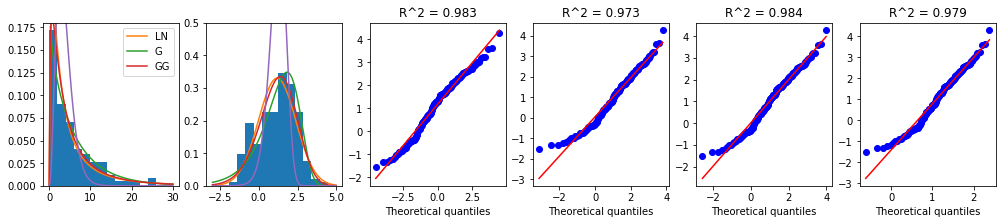

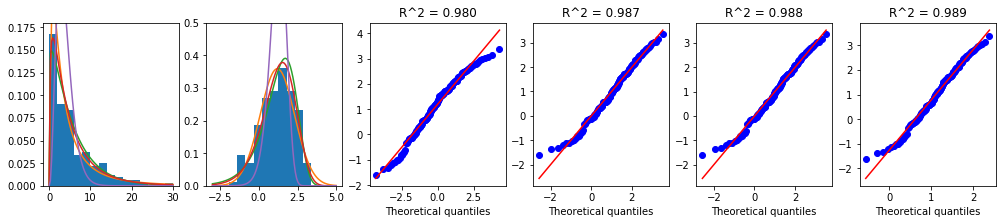

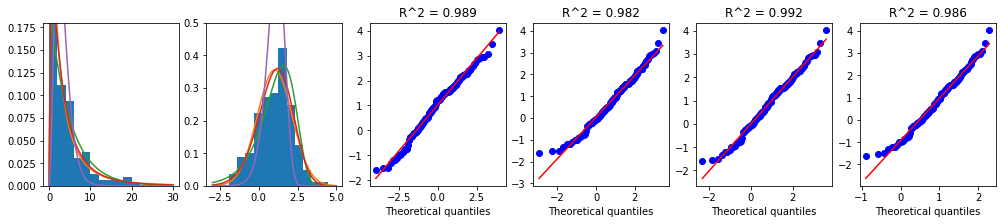

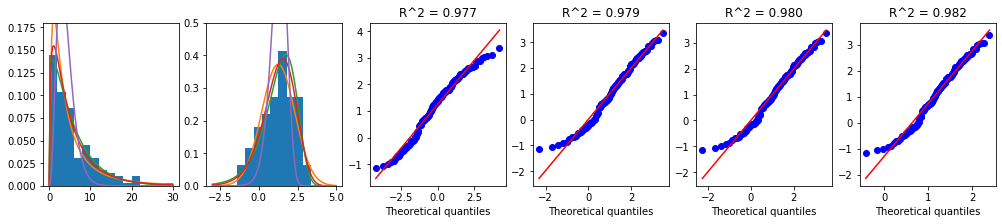

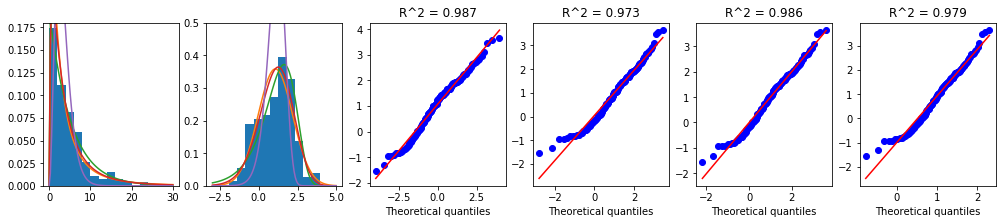

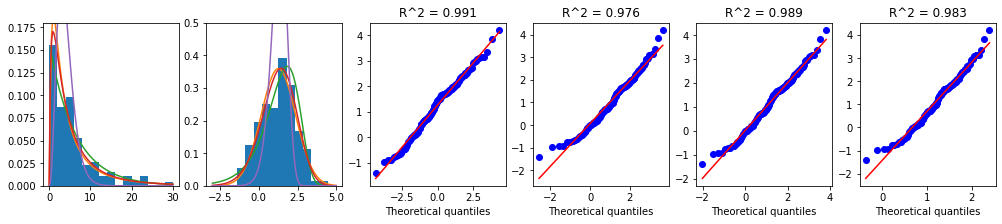

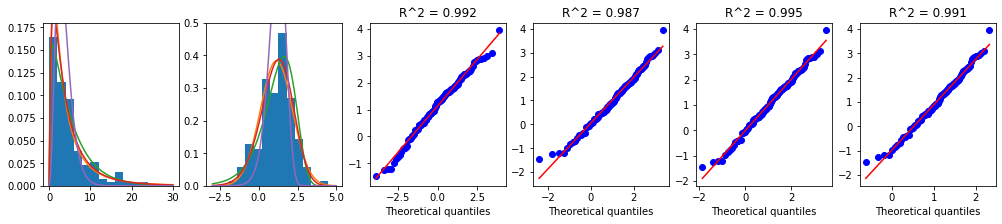

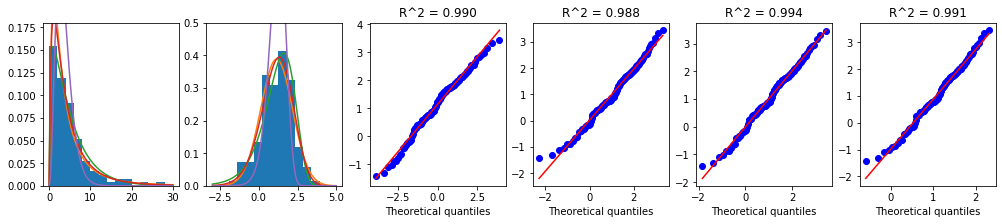

In [13]:
class MyDst():
    def pdf(x):
        pass
    
N=7
for i in range(8):
    plt.figure(figsize=(20,3))
    plt.subplot(1,N,1)
    temp=gm[:,0,:,i].flatten()
    temp=temp[~np.isnan(temp)]
    plt.hist(temp,np.linspace(0,30,16),normed=True);
    x=np.linspace(0,30,101)
    plt.ylim([0,0.18])
    plt.subplot(1,N,2)
    plt.hist(np.log(temp),np.linspace(-3,5,16),normed=True);
    logx=np.linspace(-3,5,101)
    plt.ylim([0,0.5])
    k=0
    for ag in [stats.lognorm,stats.gamma,stats.gengamma,stats.gamma]:
        if k==3: pars=ag.fit(temp,floc=0,fscale=1)
        else: pars=ag.fit(temp,floc=0)
        dst=ag(*pars)
        plt.subplot(1,N,1)
        plt.plot(x,dst.pdf(x))
        plt.subplot(1,N,2)
        plt.plot(logx,dst.pdf(np.exp(logx))*np.exp(logx))
        k+=1
    plt.subplot(1,N,1)
    if not i: plt.legend(['LN','G','GG'])
    
    ''' '''
    plt.subplot(1,N,3)
    pars=stats.norm.fit(np.log(temp),floc=0)
    dst=stats.norm(*pars)
    res=stats.probplot(np.log(temp),dist=dst,plot=plt);
    plt.title('R^2 = %.3f'%res[-1][-1]**2);plt.ylabel('')
    
    plt.subplot(1,N,4)
    pars=stats.loggamma.fit(np.log(temp),floc=0)
    dst=stats.loggamma(*pars)
    res=stats.probplot(np.log(temp),dist=dst,plot=plt);
    plt.title('R^2 = %.3f'%res[-1][-1]**2);plt.ylabel('')
    
    plt.subplot(1,N,5)
    pars=stats.gengamma.fit(temp,floc=0)
    q=pars[1];b=pars[3]
    dsttemp=stats.gengamma(*pars)
    dst=MyDst()
    dst.ppf=lambda x: np.log(dsttemp.ppf(x))
    res=stats.probplot(np.log(temp),dist=dst,plot=plt);
    plt.title('R^2 = %.3f'%res[-1][-1]**2);plt.ylabel('')
    
    plt.subplot(1,N,6)
    pars=stats.loggamma.fit(np.log(temp),floc=0,fscale=1)
    dst=stats.loggamma(*pars)
    res=stats.probplot(np.log(temp),dist=dst,plot=plt);
    plt.title('R^2 = %.3f'%res[-1][-1]**2);plt.ylabel('')
    
    #dst=stats.gengamma(pars[0],1,0,b**q)
    #res=stats.probplot(np.power(temp,q),dist=dst,plot=plt);
    #plt.title('R^2 = %.3f'%res[-1][-1]**2)
    #plt.subplot(1,N,6)
    #dst=stats.loggamma(pars[0],0,b**q)
    #res=stats.probplot(np.log(np.power(temp,q)),dist=dst,plot=plt);
    #plt.title('R^2 = %.3f'%res[-1][-1]**2)
    

    
    

## Gamma Regression: Single link

In [12]:
import pystan
invgammafun='''functions{
    vector invdigamma(vector x){
        vector[num_elements(x)] y; vector[num_elements(x)] L;
        for (i in 1:num_elements(x)){
            if (x[i]==digamma(1)){ 
                y[i]=1;
            }else{ if (x[i]>=-2.22){
                y[i]=(exp(x[i])+0.5);
            }else{
                y[i]=1/(x[i]-digamma(1));
        }}}
        L=digamma(y)-x;
        while (min(L)>10^-12){
            y=y-L ./trigamma(y);
            L=digamma(y)-x;
        }
        return y;}
    real invdigammaR(real x){
        real y; real L;
        if (x==digamma(1)){ 
            y=1;
        }else{ if (x>=-2.22){
            y=(exp(x)+0.5);
        }else{
            y=1/(x-digamma(1));
        }}
        L=digamma(y)-x;
        while (L>10^-12){
            y=y-L ./trigamma(y);
            L=digamma(y)-x;
        }
        return y;
    }} '''
model = """
data {
    int<lower=0> N; //nr subjects
    real<lower=-1> yLT[N,10];
    real<lower=0,upper=1> xIsTest[10];
    int<lower=1,upper=4> xCond[N];
}parameters {
    real<lower=-100,upper=100> bIsTrial;
    real<lower=-100,upper=100> bIsTest[4];
    real<lower=-100,upper=100> bTrialOrder;
    //real<lower=0,upper=1> bSaw[N];
    real kI[N];
}model {
    //int<lower=0,upper=1> saw;
    for (n in 1:N){
        //saw~Bernoulli(bSaw[N]);
    for (t in 0:7){
    if (yLT[n,t+1]>0)
        yLT[n,t+1]~gamma(exp(kI[n]),exp(bIsTrial+bTrialOrder*t+bIsTest[xCond[n]]*xIsTest[t+1]));    
    }}

}
"""
smGammaTrials = pystan.StanModel(model_code=invgammafun+model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e216219e24f8eb95d22552b2cb888fc4 NOW.


In [13]:
dats=[]
for a in range(3):
    yLT=[];xCond=[]
    for c in range(4):
        for r in range(gm.shape[2]):
            if np.sum(np.isnan(gm[c,a,r,:]))>4: continue

            yLT.append(gm[c,a,r,:])
            xCond.append(c)
    xIsTest=np.zeros(10)
    xIsTest[3:]=1
    yLT=np.array(yLT)
    yLT[np.isnan(yLT)]=-1
    dat={'xIsTest':xIsTest,'yLT':yLT,'xCond':np.int32(xCond)+1,'N':len(xCond)}
    dats.append(dat)
    
fit=smGammaTrials.sampling(data=dats[1],chains=6,n_jobs=6,
                seed=1,thin=2,iter=3000,warmup=1000)
print(fit)
assert(np.all(fit.summary()['summary'][:2,-1]<1.05))
w=fit.extract()

Inference for Stan model: anon_model_e216219e24f8eb95d22552b2cb888fc4.
6 chains, each with iter=3000; warmup=1000; thin=2; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

              mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bIsTrial     -1.34     0.1    0.2   -1.84   -1.4  -1.29  -1.21  -1.07      4   1.92
bIsTest[1]   -0.22    0.02   0.21   -0.65  -0.35  -0.21  -0.07   0.18    136   1.04
bIsTest[2]   -0.24  3.7e-3    0.2   -0.64  -0.37  -0.24   -0.1   0.15   2942    1.0
bIsTest[3]   -0.43  6.9e-3    0.2   -0.83  -0.57  -0.44  -0.29  -0.04    855   1.01
bIsTest[4]   -0.14  3.6e-3   0.21   -0.55  -0.28  -0.14 4.2e-3   0.27   3467    1.0
bTrialOrder   0.04  4.7e-4   0.04   -0.03   0.02   0.04   0.06   0.11   5629    1.0
kI[1]         0.69     0.5   0.89   -1.31   0.79   1.04    1.2   1.44      3   4.62
kI[2]         0.25    0.02   0.29   -0.32   0.07   0.25   0.44   0.77    184   1.03
kI[3]         0.29    0.54   0.95   -1.87   0.39   0.66

AssertionError: 

In [108]:
import pystan
model = """
data {
    int<lower=0> N; //nr subjects
    real<lower=-1> yLT[N,8];
    real<lower=1,upper=5> xSN[N,8];
    real<lower=1,upper=4> xSL[N];
    real<lower=0> xAGE[N];
}parameters {
    real bI[N];
    real bSN;
    real bSL;
    real bAGE;
    real bAR;
    real<lower=0> sI[N];
    real<lower=0> y0[N];
}transformed parameters {
    real yPrev[N,8];
    for (n in 1:N){
        yPrev[n,1]=y0[n];
        for (k in 2:8) yPrev[n,k]=yLT[n,k-1];
    }
}model {
    real temp1;
    
    for (n in 1:N){
        for (k in 1:8){
        if (yLT[n,k]>0){
            temp1=bI[n]+bSN*log(xSN[n,k])+bSL*log(xSL[n])+bAGE*log(xAGE[n])+bAR*log(yPrev[n,k]);
            yLT[n,k]~gamma(exp(temp1),sI[n]);
    }}}
}
"""
smGammaK = pystan.StanModel(model_code=model)

In [110]:
xSN=np.zeros((info.shape[0],8))
xSL=np.zeros(info.shape[0],dtype=np.int32)
for k in range(info.shape[0]):
    s=str(info[k,7])
    hab=s[:4]
    test=s[4:8]
    tr=int(s[8])
    lst=list(test)
    temp=min(set(lst), key=lst.count)
    xSL[k]=lst.index(temp)+1
    for i in range(8):
        if i<tr: temp=hab
        else: temp=test
        xSN[k,i]=int(temp[xSL[k]-1])
yLT[np.isnan(yLT)]=-1
dat={'yLT':yLT,'xSN':xSN,'xSL':xSL,'xAGE':info[:,4],'N':info.shape[0]}
fit=smGammaK.sampling(data=dat,chains=6,n_jobs=6,seed=1,iter=200,warmup=50)
print(fit)

Inference for Stan model: anon_model_69172d9f8dcce43e4bc422368b4d9618.
6 chains, each with iter=200; warmup=50; thin=1; 
post-warmup draws per chain=150, total post-warmup draws=900.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bI[0]         -0.48    0.35   0.78  -1.92  -1.16  -0.46   0.22   0.71      5   1.91
bI[1]         -0.68    0.19   0.66  -1.86  -1.19  -0.72  -0.33   0.87     12   1.32
bI[2]          0.07    0.28   0.63  -1.04  -0.48   0.06   0.53   1.35      5    1.7
bI[3]           0.7    0.32   0.72   -0.4   0.21   0.57   1.16   2.13      5   1.88
bI[4]         -0.92    0.33   0.73  -2.48  -1.43  -0.94  -0.33    0.4      5   1.86
bI[5]         -1.15    0.32   0.71  -2.55  -1.69  -1.12  -0.67   0.17      5   1.78
bI[6]         -1.03    0.29   0.64  -2.41  -1.45  -0.96  -0.55   0.02      5   1.63
bI[7]          1.26    0.33   0.74  -0.25   0.71   1.36    1.9   2.32      5   1.84
bI[8]          0.49    0.33   0.74   -0.9  -0.09   0.59    1

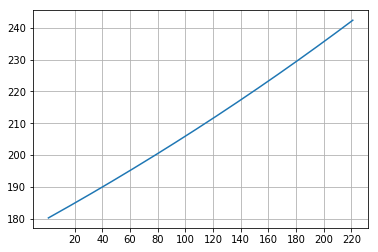

In [89]:
dinc=np.power(1.4,1/250)
t=np.linspace(1,221,220)
plt.plot(t,180*(np.power(dinc,t)))
plt.xticks(np.arange(11)*20+20);
plt.grid()

# Nr Habituation Trials

/usr/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


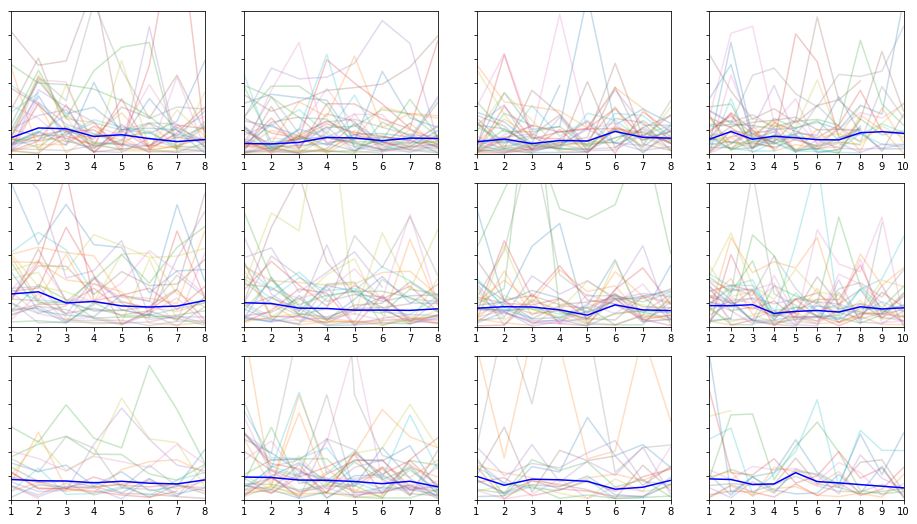

In [3]:
mstr=[133353330,313335330,331333530]
lbls=[]
for m in mstr:
    for j in [1,3,5,7]:
        lbls.append(m+j)
plt.figure(figsize=[16,3*len(mstr)])
gm=np.nan*np.ones((3,4,len(mstr),30,10))
yLT=np.nan*np.zeros((info.shape[0],10))
xLT=-np.ones((info.shape[0],3))
hs=np.zeros((3,4,len(mstr)),dtype=np.int32)
for k in range(len(Dres)):
    if not info[k,7] in lbls: continue
    tr=[1,3,5,7].index(info[k,7]%10)
    fc=mstr.index(floor(info[k,7]/10)*10)
    m=[4,7,10].index(info[k,1])
    ax=plt.subplot(len(mstr),4,fc*4+tr+1)

    temp=Dres[k][2::2]-Dres[k][1::2]
    if temp.size<3:continue
    temp[temp==0]=np.nan
    gm[m,tr,fc,hs[m,tr,fc],:temp.size]=temp
    yLT[k,:temp.size]=temp
    xLT[k,0]=[1,3,5,7][tr]
    xLT[k,1]=fc
    xLT[k,2]=info[k,4]
    #temp=Dlog[k][1,:]
    plt.plot(range(1,11),gm[m,tr,fc,hs[m,tr,fc],:],alpha=0.25)
    #plt.plot(range(4,9),temp[3:],alpha=0.25)
    hs[m,tr,fc]+=1
    ax.set_xticks(range(1,11))
    plt.xlim([[1,8],[1,10]][tr>2])
    
    plt.ylim([0,30])
    if j>0: ax.set_yticklabels([])
    #if i<2: ax.set_xticklabels([])
    #if not j:plt.ylabel(lbls[i])
for i in range(gm.shape[1]):
    for j in range(gm.shape[2]):
        ax=plt.subplot(len(mstr),4,j*4+i+1)
        gml=np.exp(np.nanmean(np.nanmean(np.log(gm[:,i,j,:,:]),axis=0),axis=0))
        if np.ndim(gml)>0: plt.plot(range(1,11),gml,'b')

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


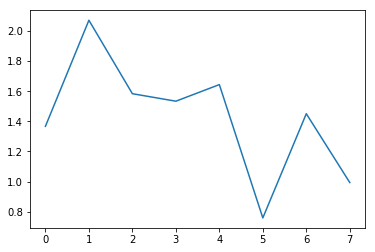

In [77]:
plt.plot(np.log(Elog(gm[2,0,0,:,:],axis=0)))

e0 (1500, 301)


<ipython-input-64-cee4083de101>:36: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.median(z,0),normed=True,bins=bns)
<ipython-input-64-cee4083de101>:43: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.median(z[:,x[:,0]==k],0),normed=True,bins=bns)
<ipython-input-64-cee4083de101>:53: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.median(z[:,x[:,1]==k],0),normed=True,bins=bns)
<ipython-input-64-cee4083de101>:64: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.median(temp,0),bins=bns,normed=True)


ed (1500, 301)
z0 (1500, 301)
zd (1500, 301)


<ipython-input-64-cee4083de101>:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(8,12))
<ipython-input-64-cee4083de101>:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16,12))
<ipython-input-64-cee4083de101>:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipytho

zh (1500, 301)
sigma (1500, 301)


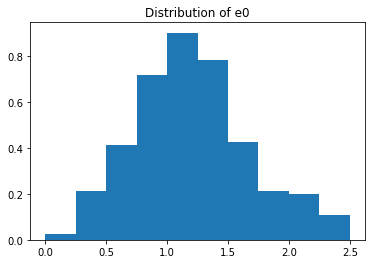

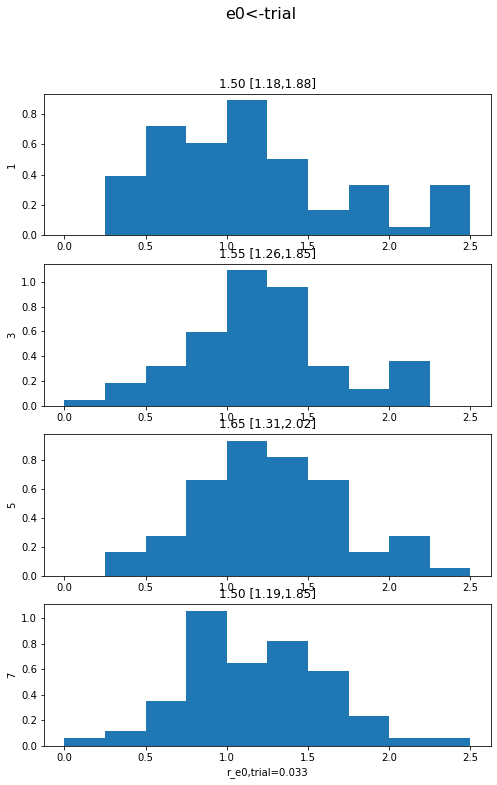

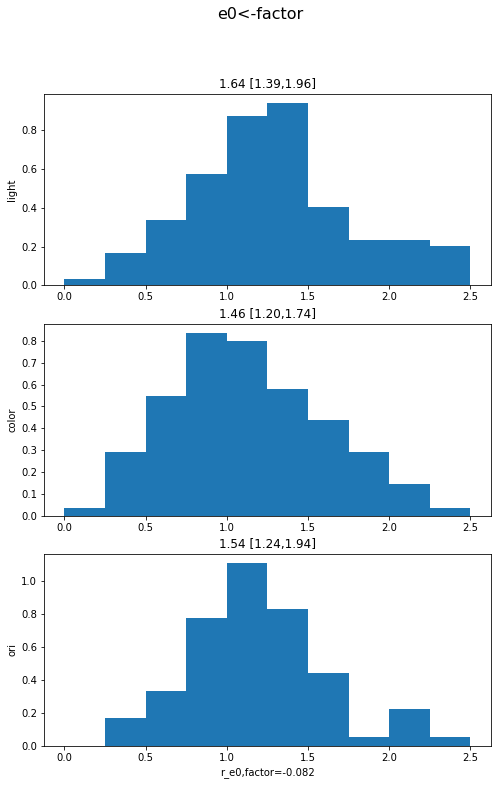

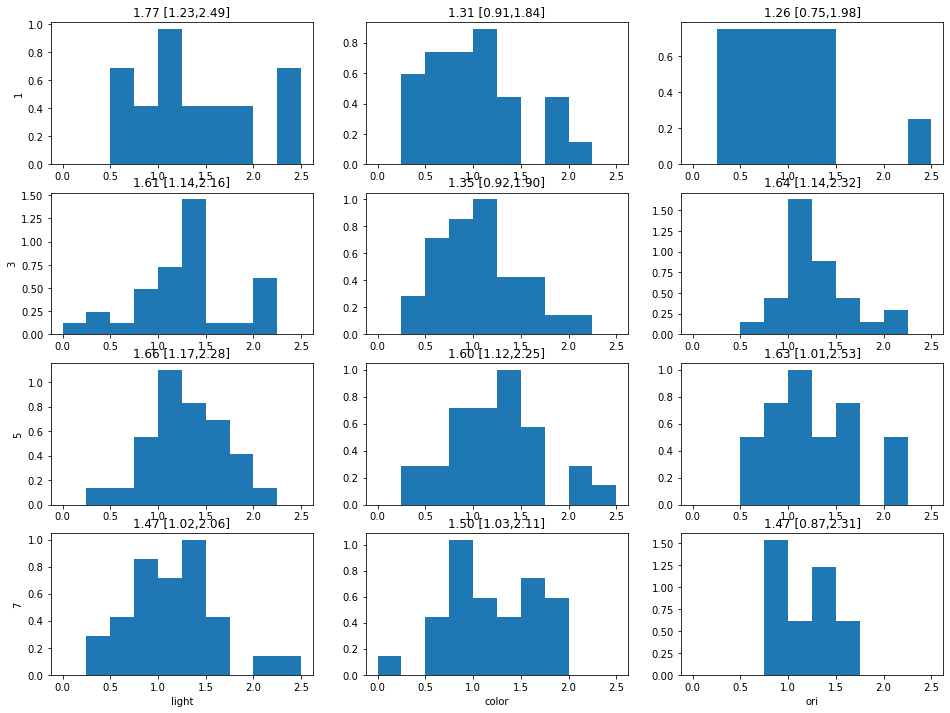

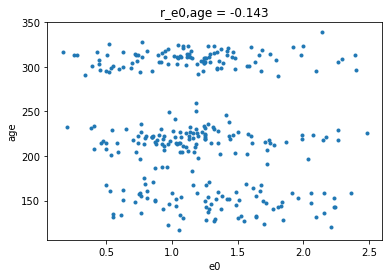

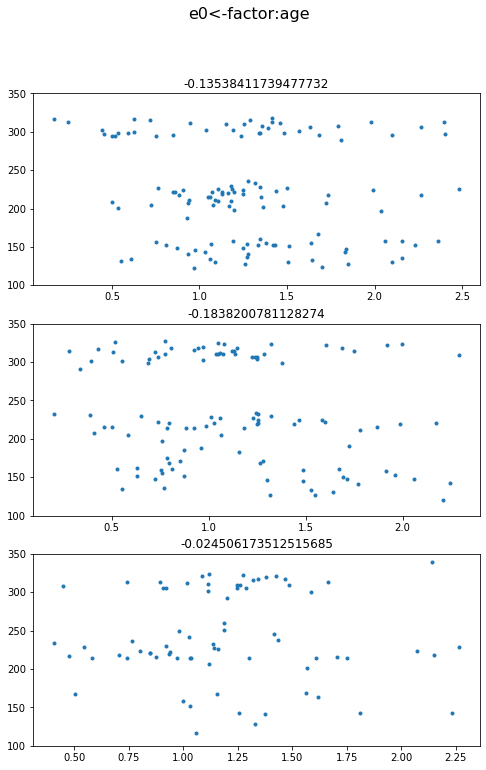

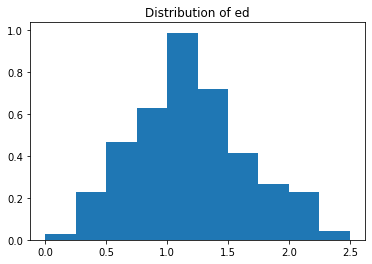

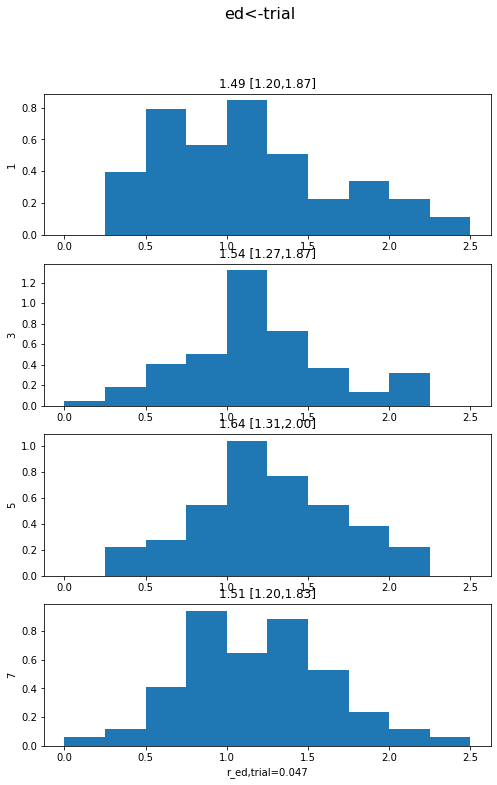

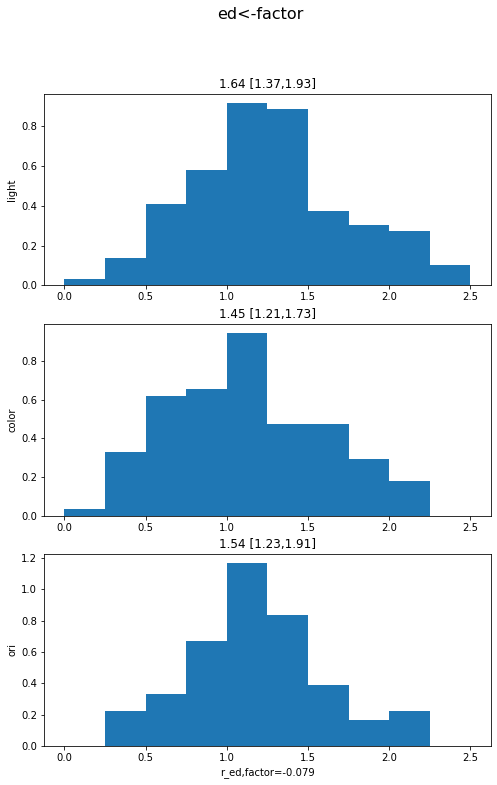

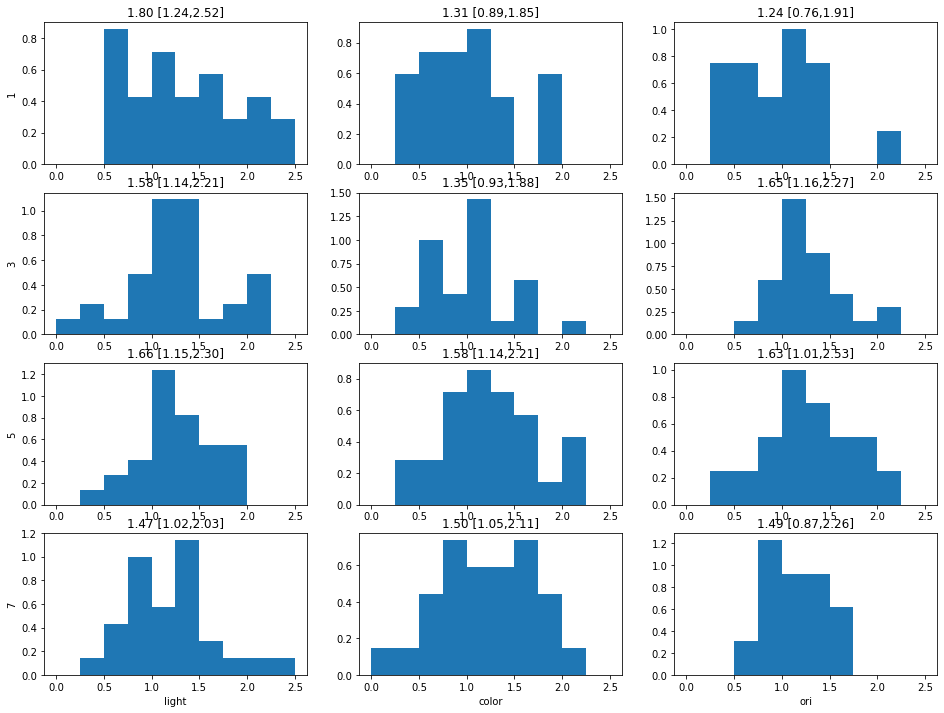

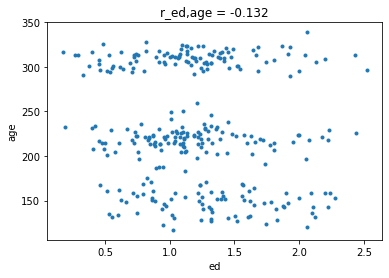

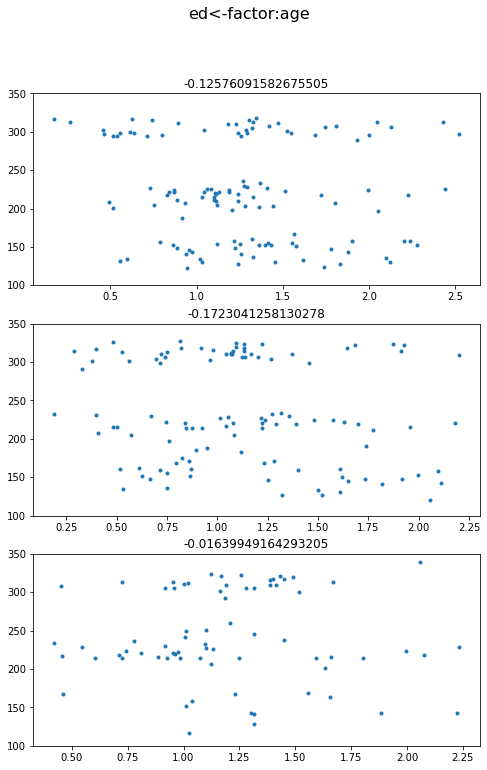

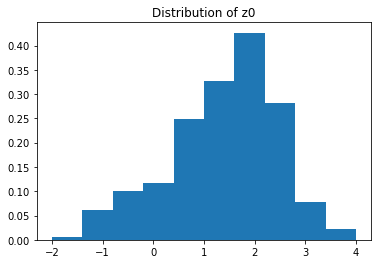

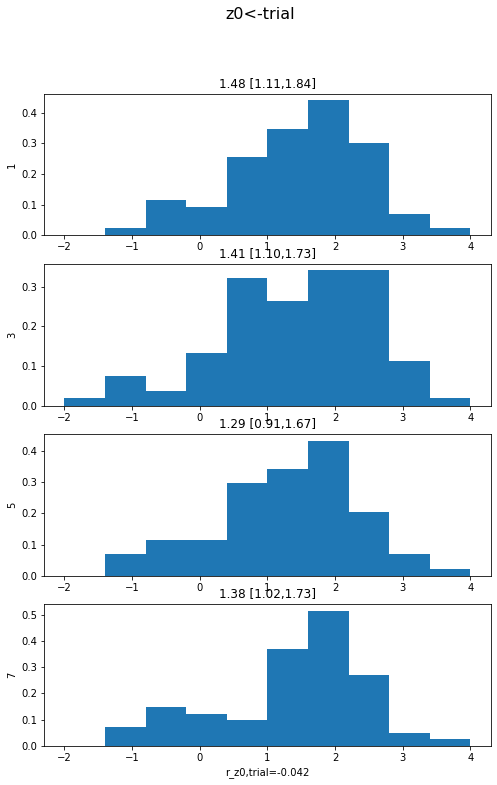

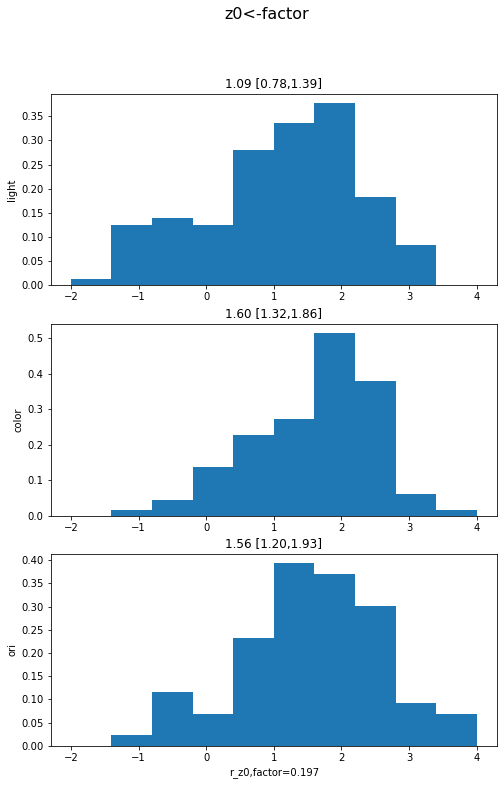

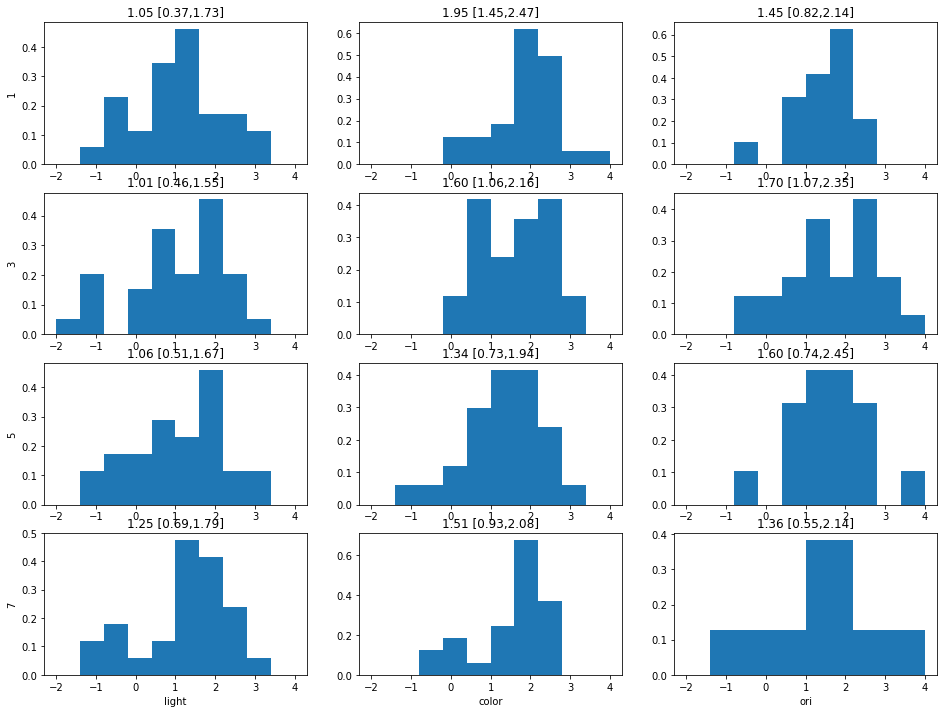

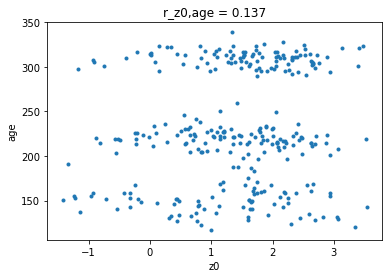

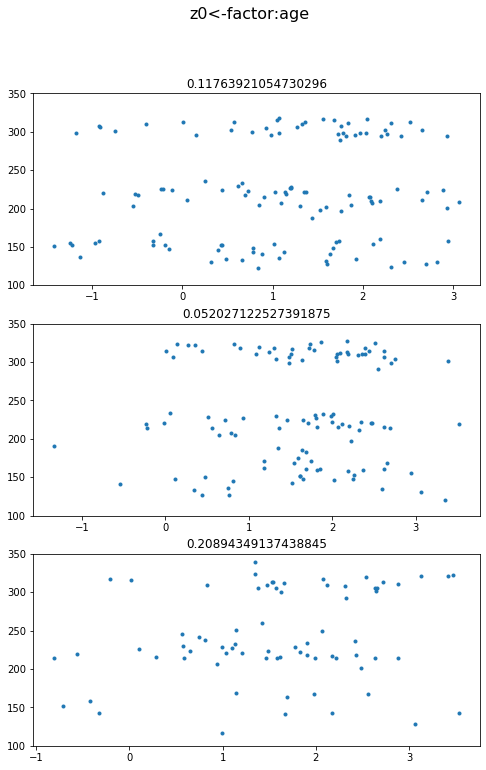

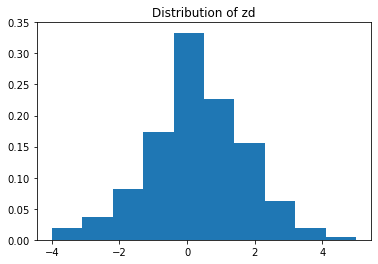

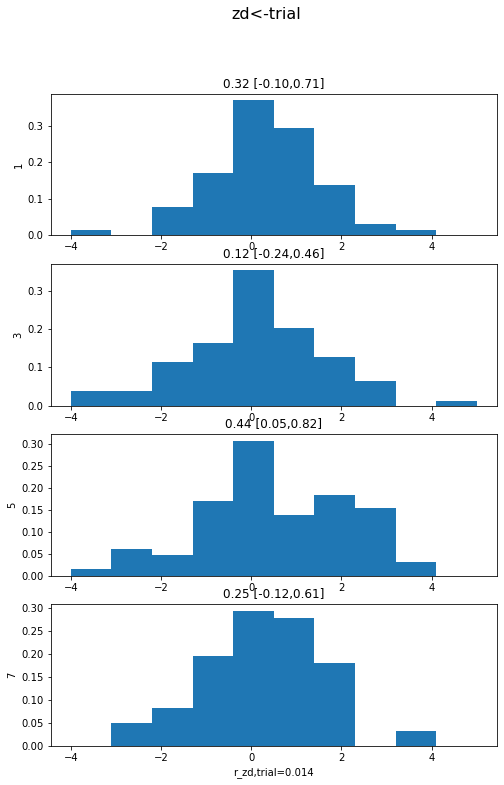

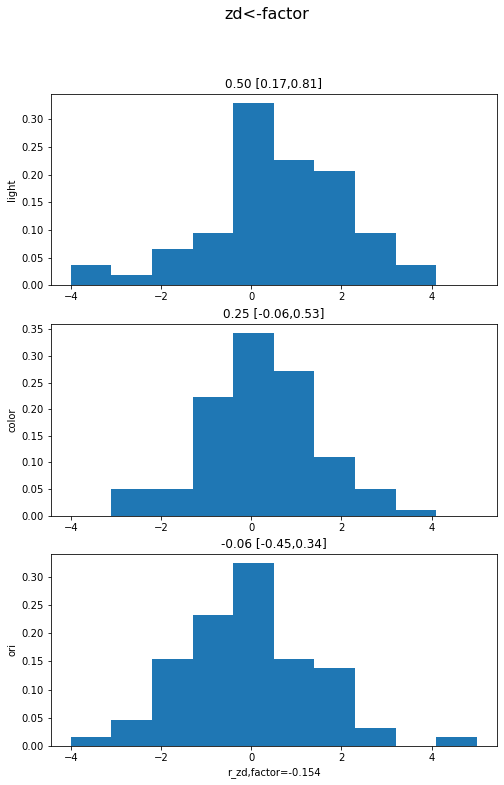

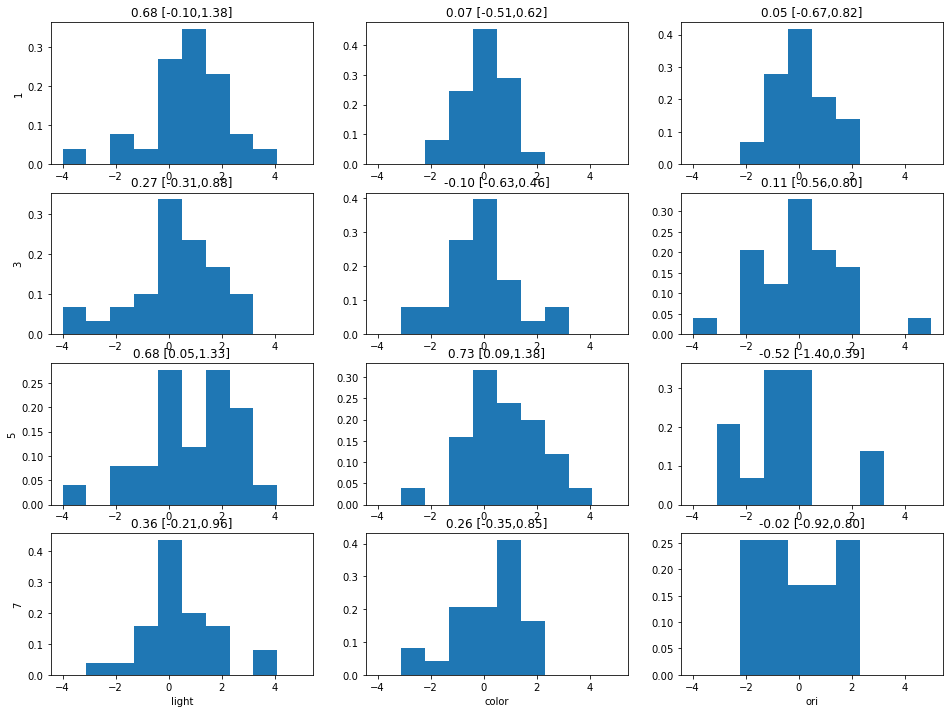

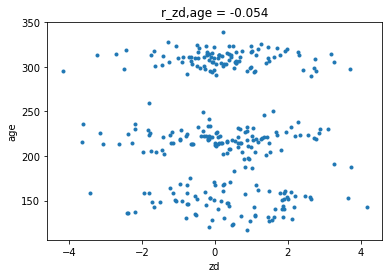

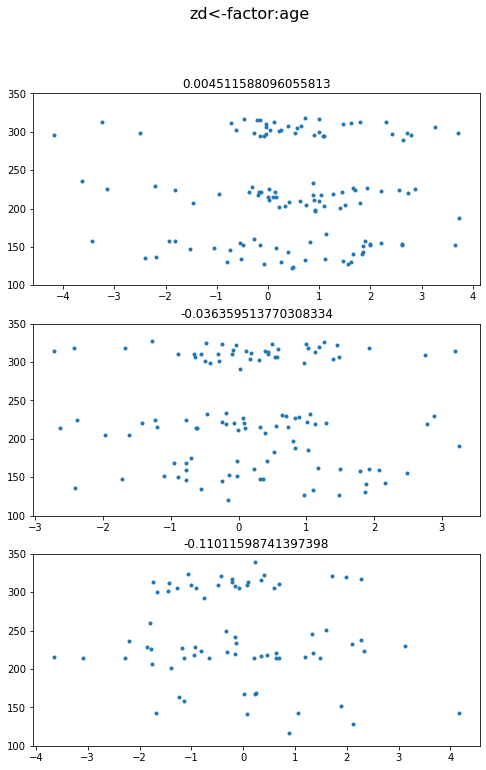

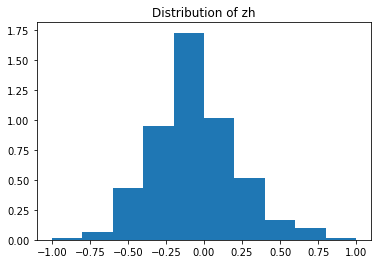

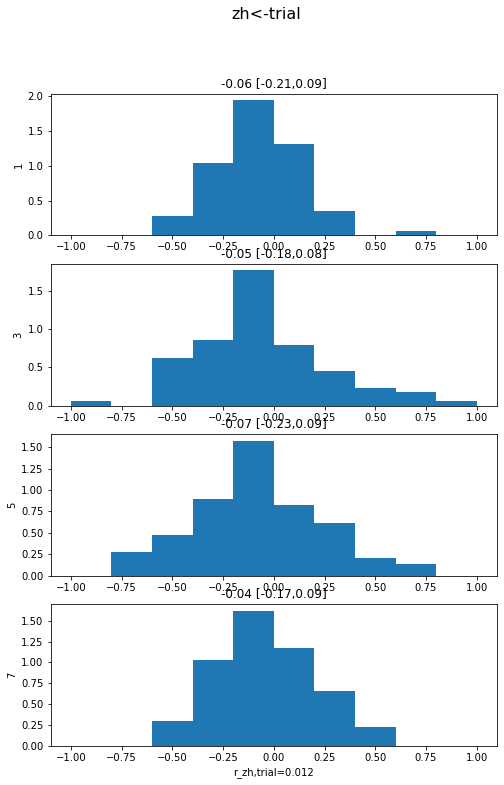

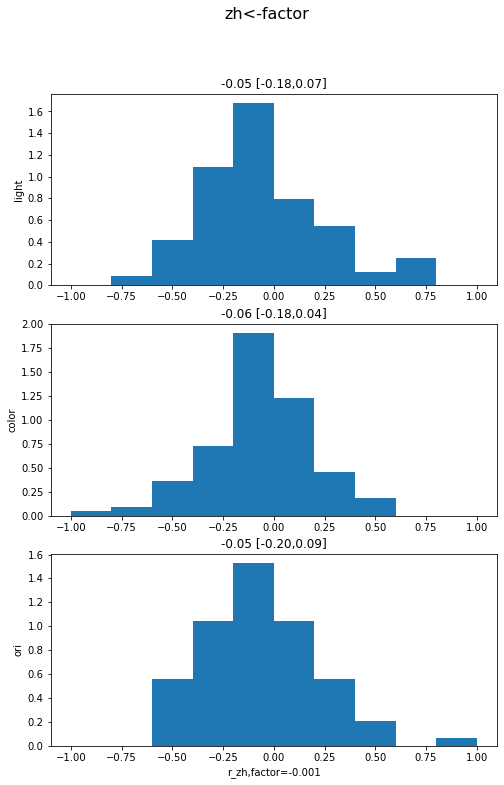

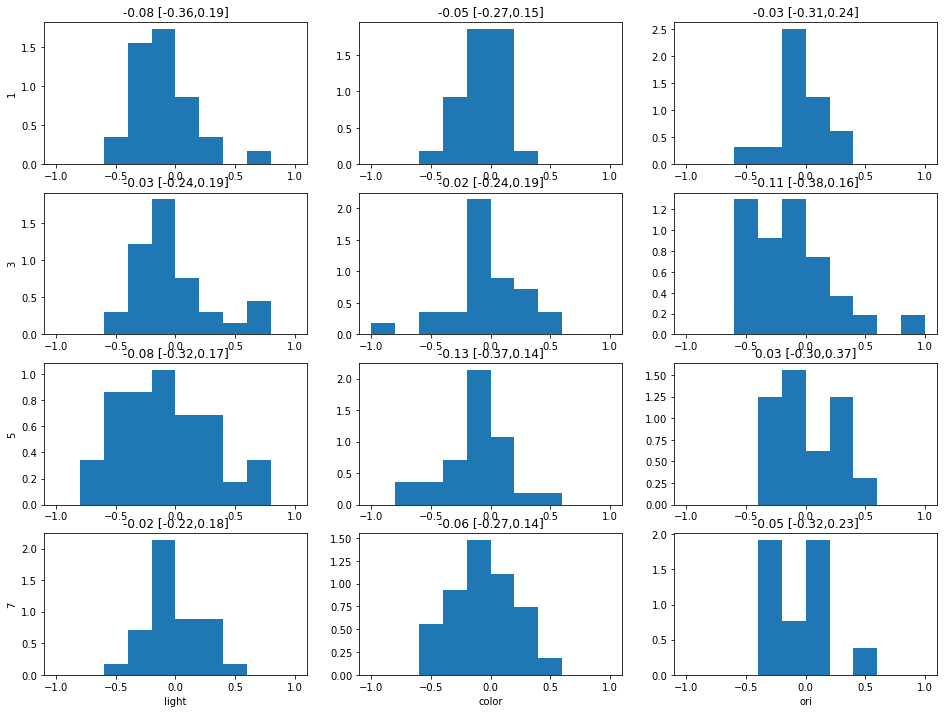

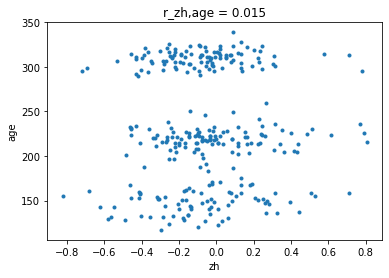

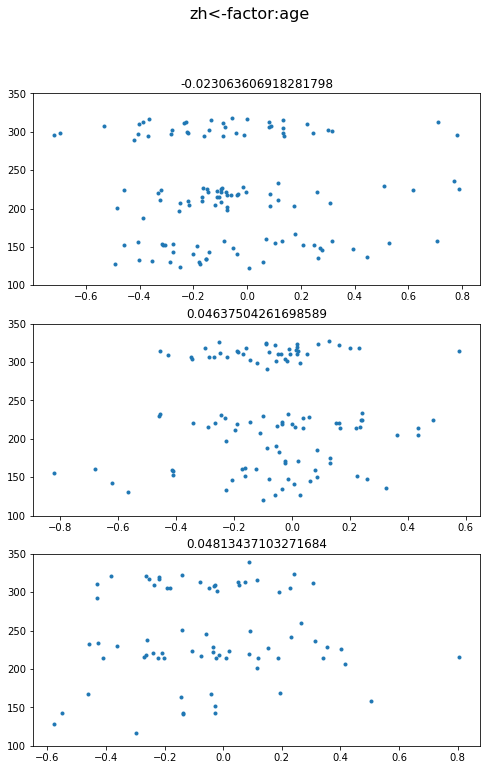

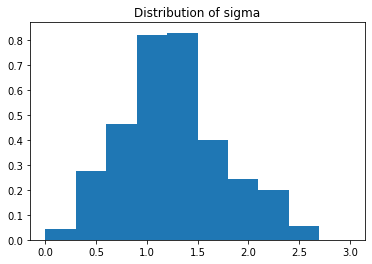

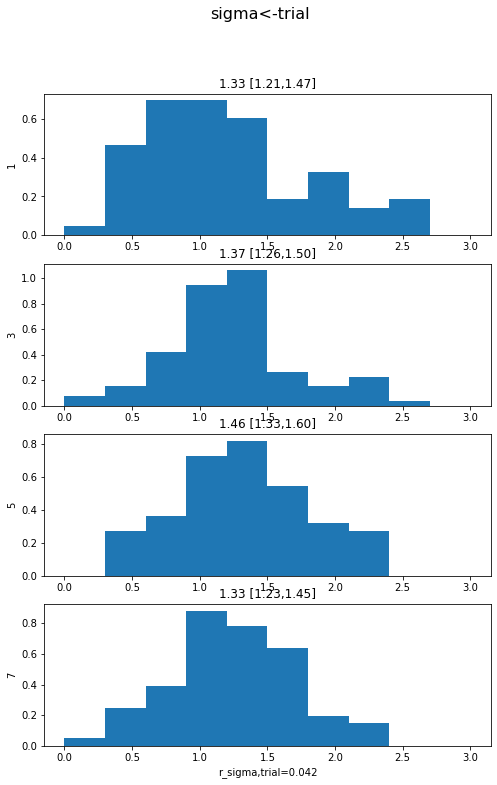

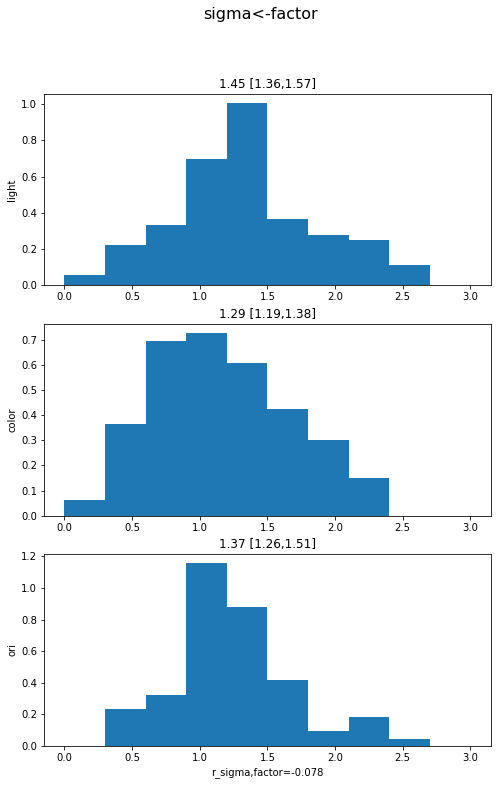

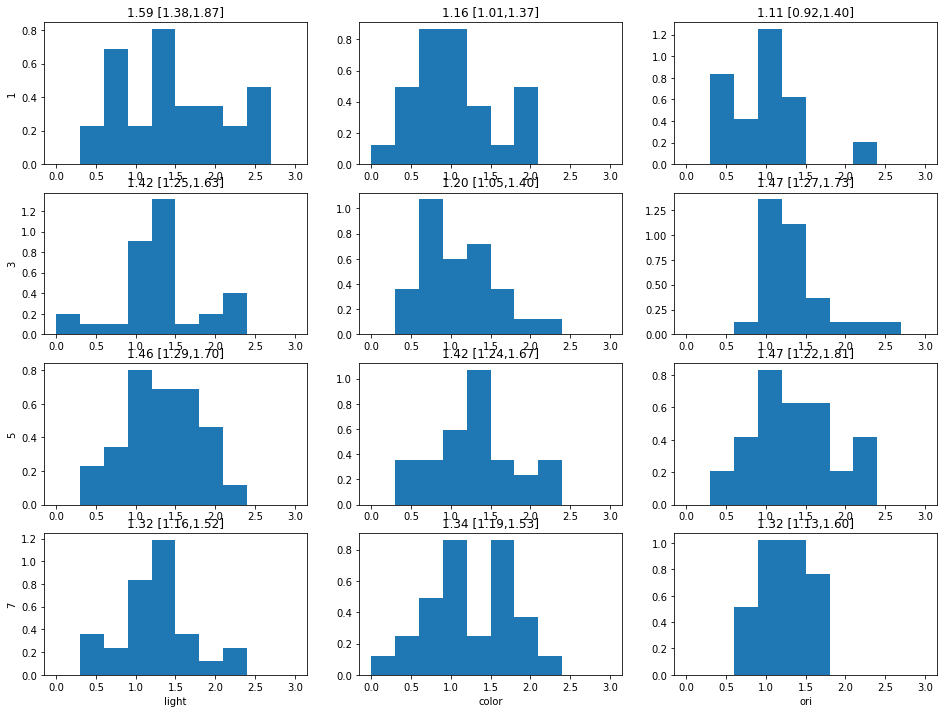

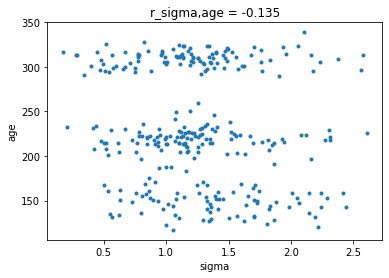

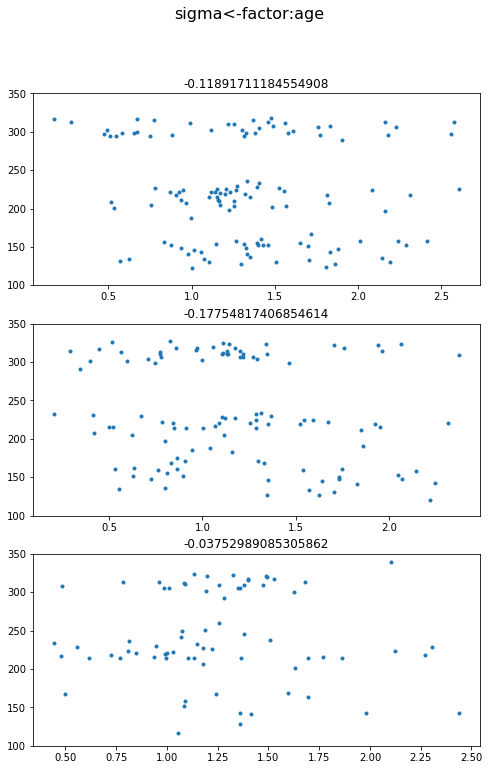

# Lognormal markov model partial pooling

In [77]:


for k in range(3): printCI(ws[k],var='zhm')
for k in range(3): printCI(ws[k],var='zdm')
for k in range(3): printCI(ws[k],var='z0m')

 -0.089 [-0.163,-0.018]
 -0.057 [-0.123,-0.002]
 -0.073 [-0.157,0.017]
 0.551 [0.283,0.778]
 0.116 [-0.079,0.304]
 -0.088 [-0.362,0.174]
 1.396 [1.130,1.618]
 1.845 [1.658,2.012]
 1.736 [1.498,1.993]


e0 (1200, 301)


<ipython-input-64-cee4083de101>:36: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.median(z,0),normed=True,bins=bns)
<ipython-input-64-cee4083de101>:43: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.median(z[:,x[:,0]==k],0),normed=True,bins=bns)
<ipython-input-64-cee4083de101>:53: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.median(z[:,x[:,1]==k],0),normed=True,bins=bns)
<ipython-input-64-cee4083de101>:64: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.median(temp,0),bins=bns,normed=True)


ed (1200, 301)
z0 (1200, 301)
zd (1200, 301)


<ipython-input-64-cee4083de101>:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(8,12))
<ipython-input-64-cee4083de101>:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16,12))
<ipython-input-64-cee4083de101>:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipytho

zh (1200, 301)
sigma (1200, 301)


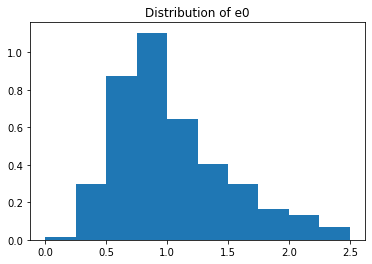

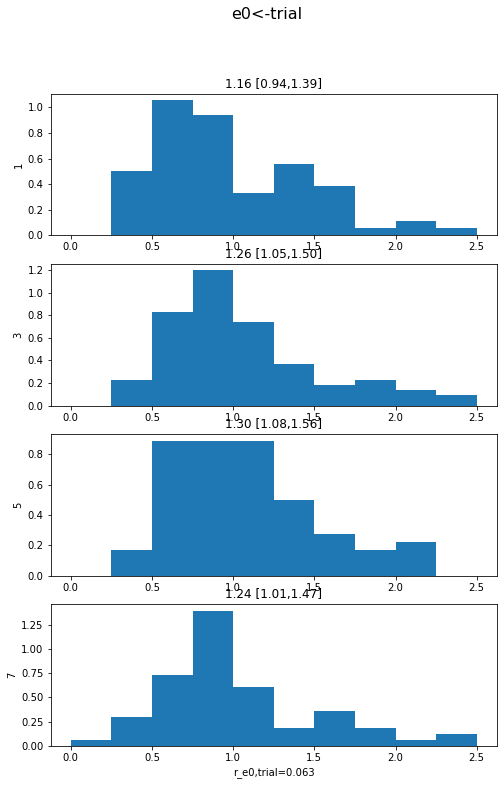

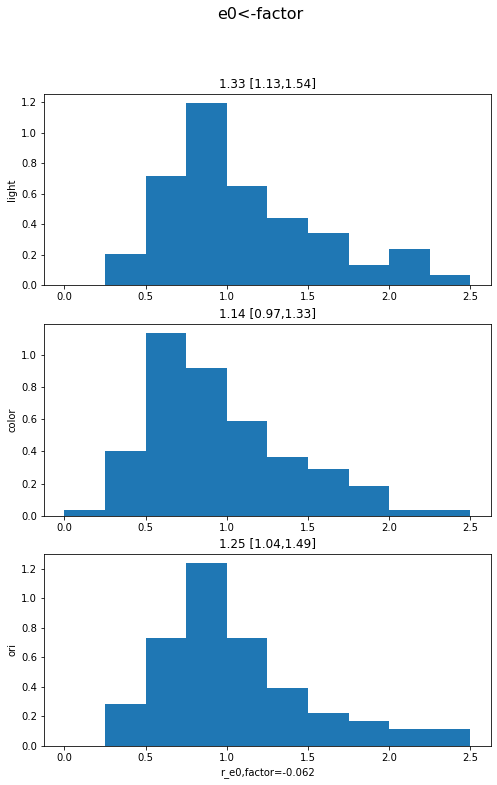

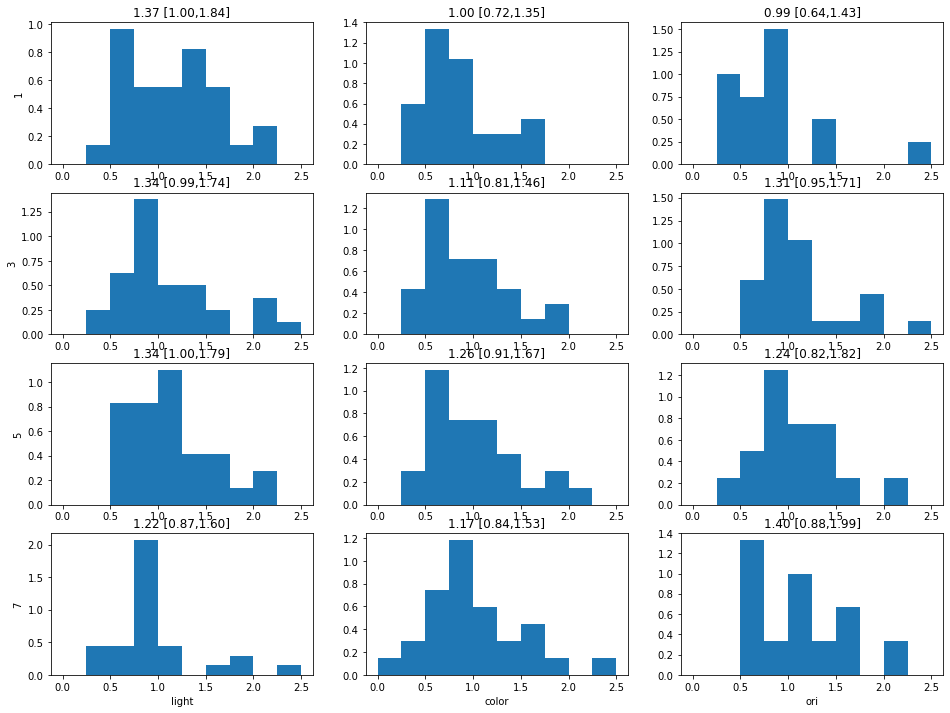

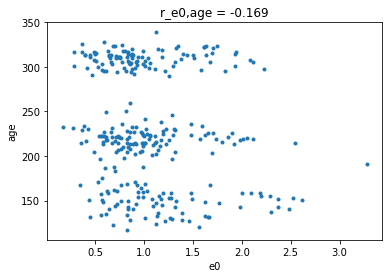

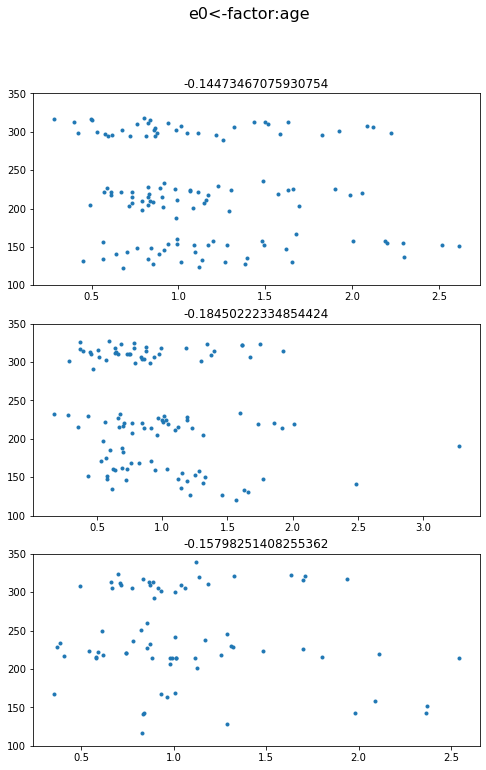

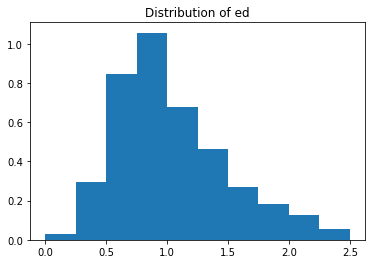

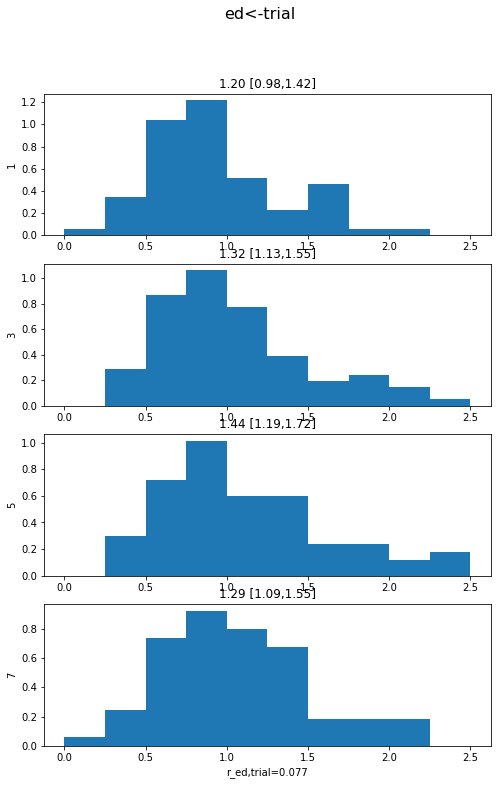

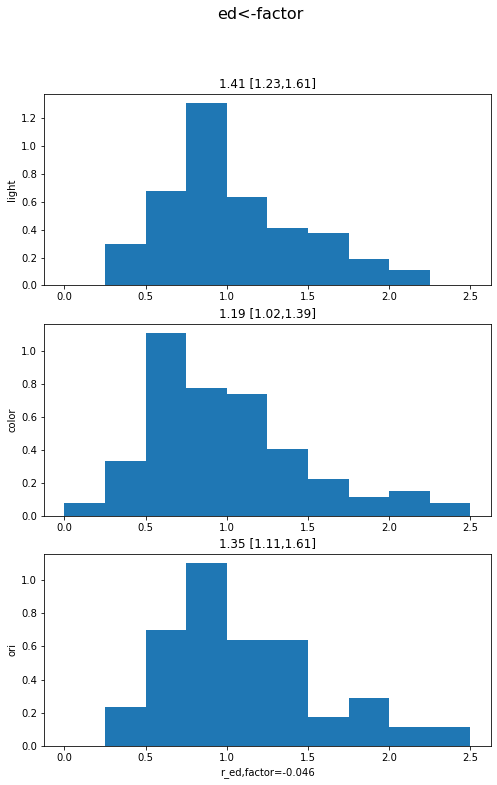

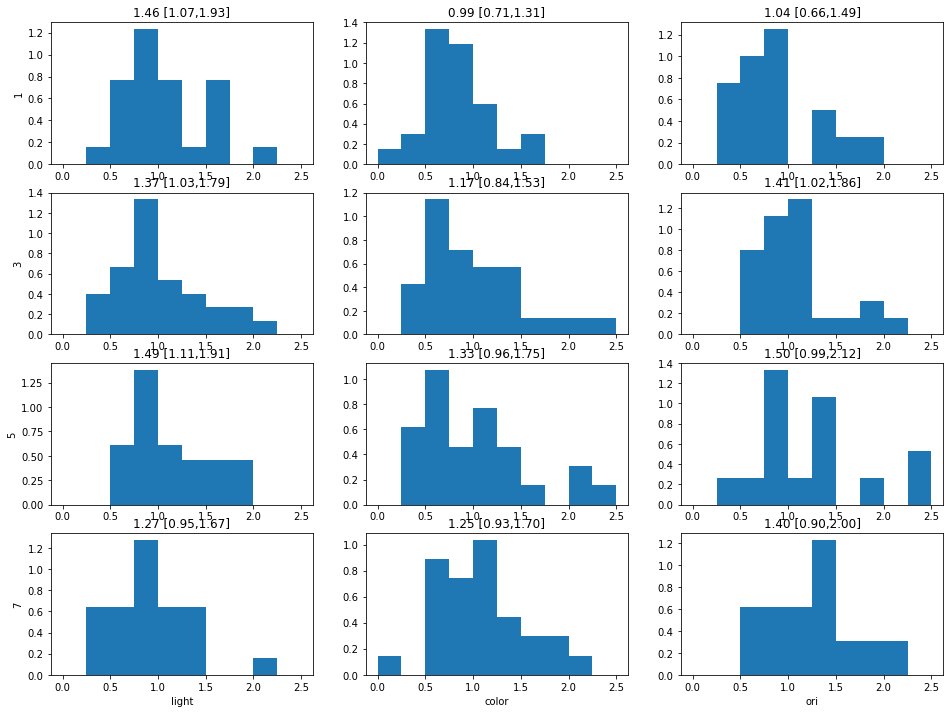

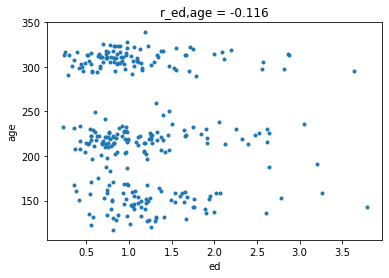

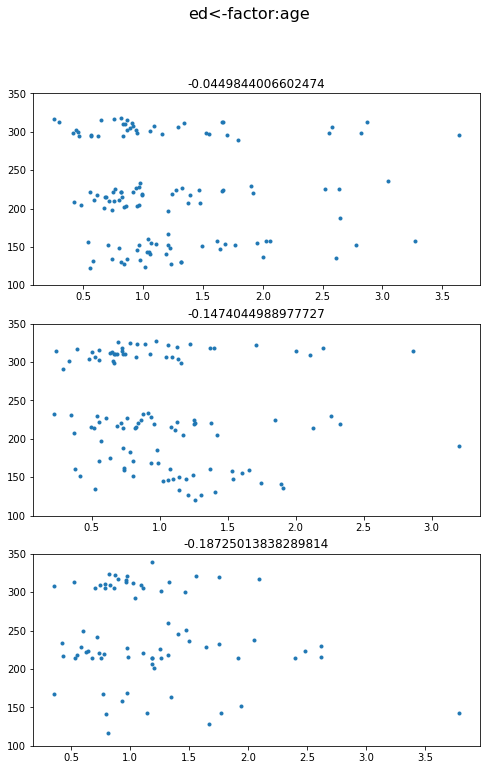

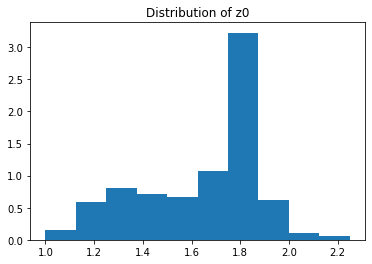

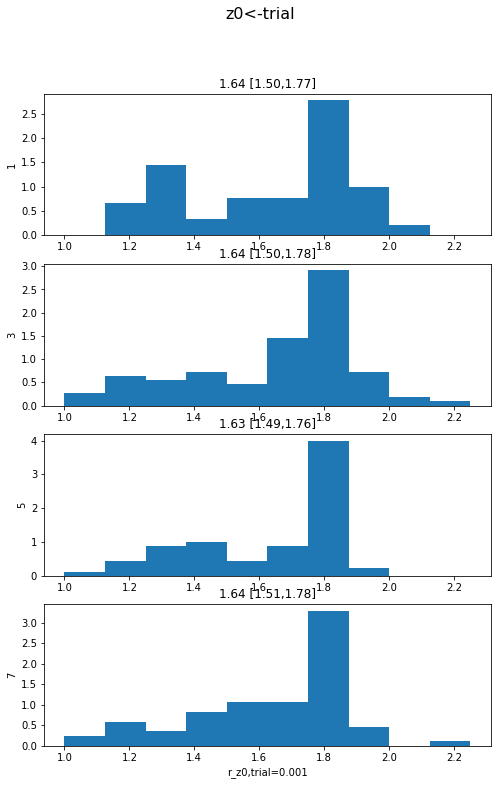

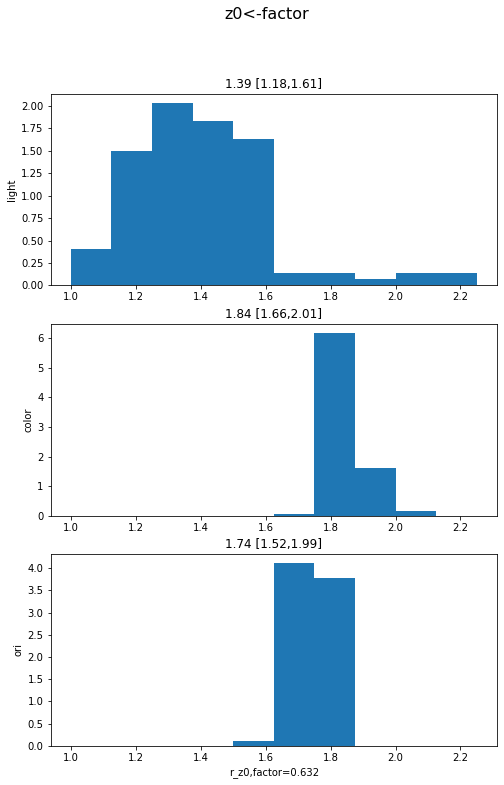

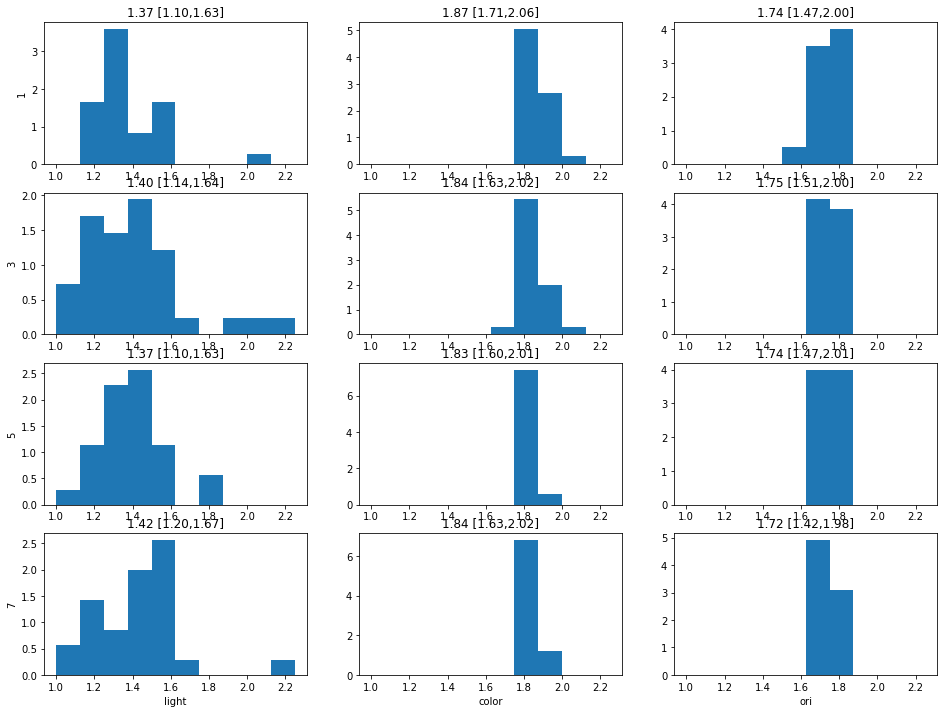

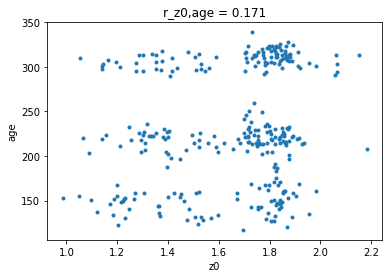

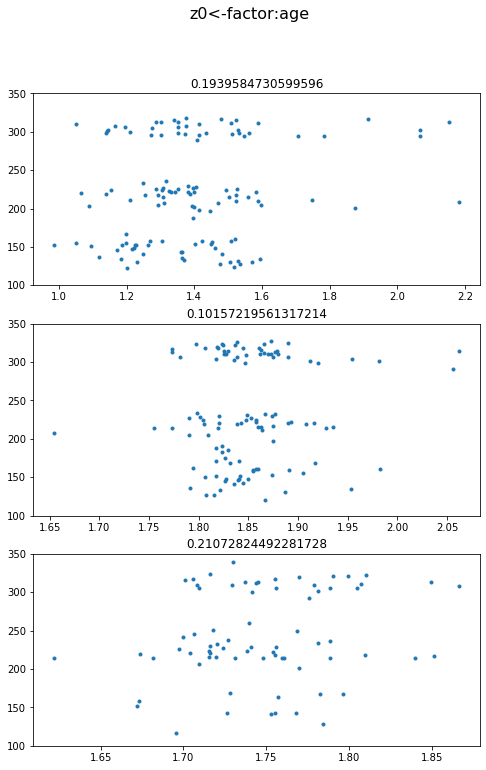

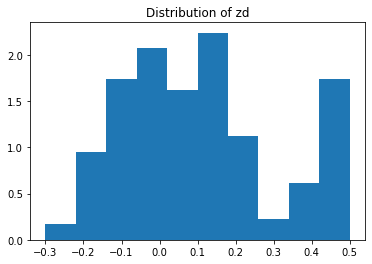

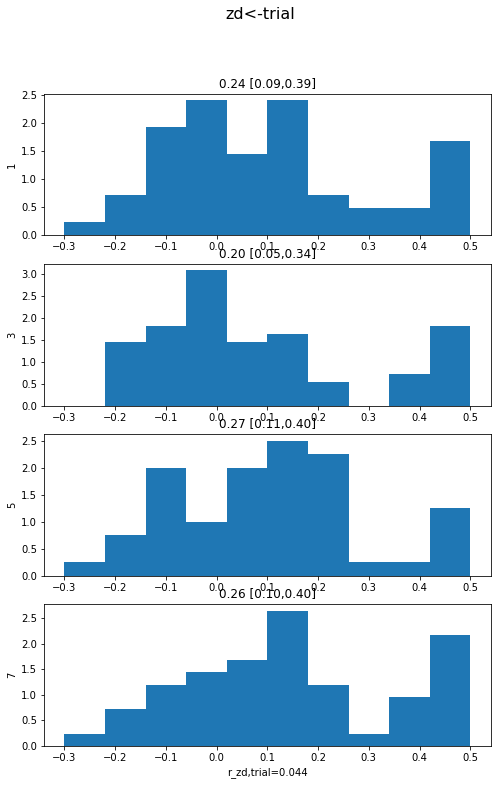

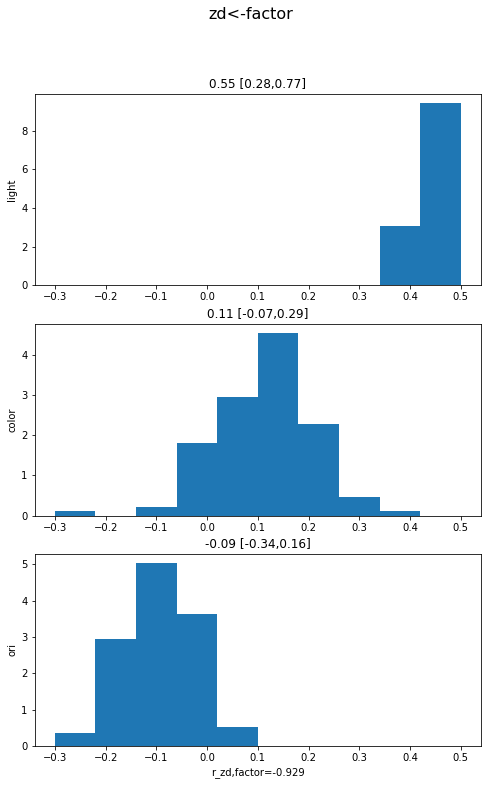

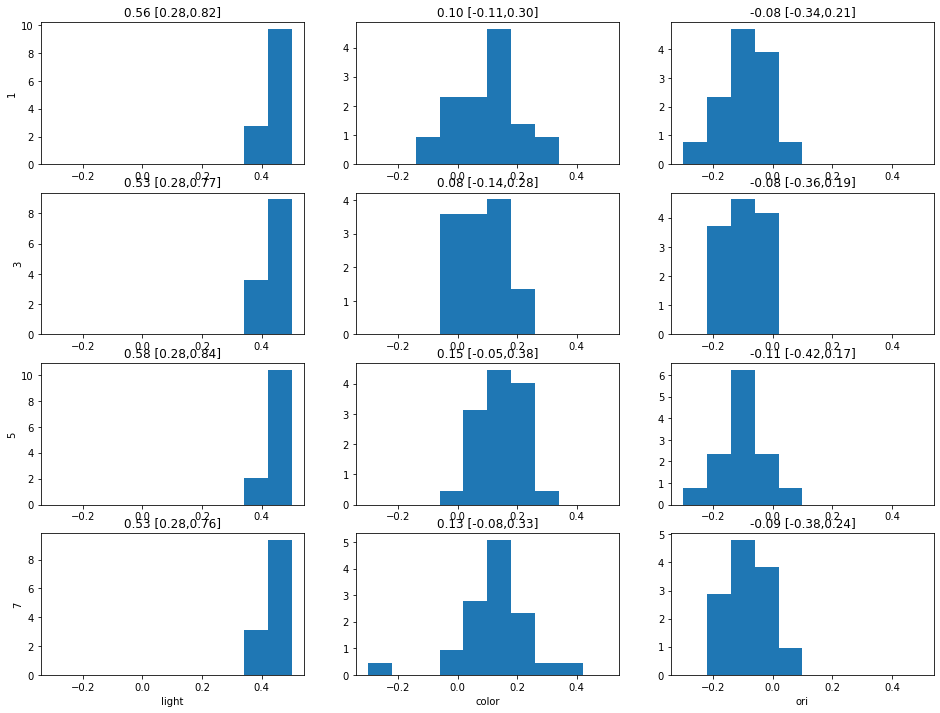

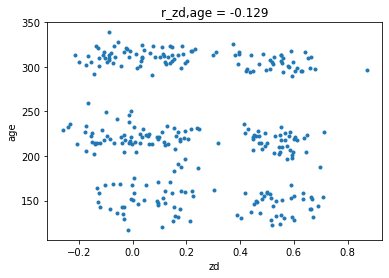

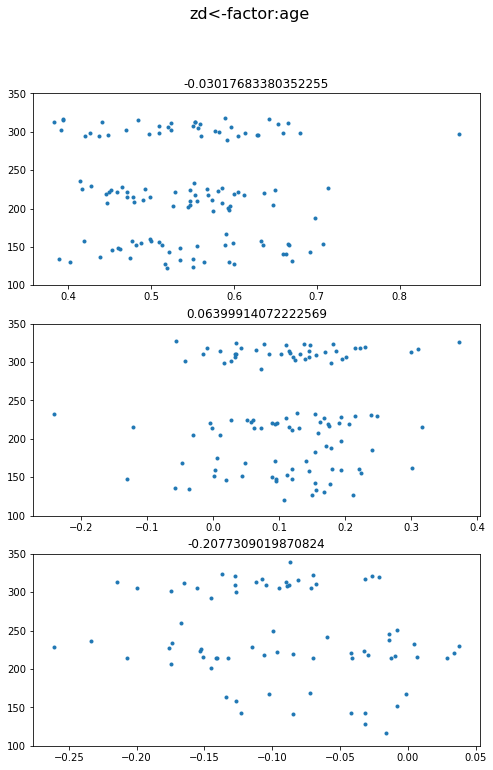

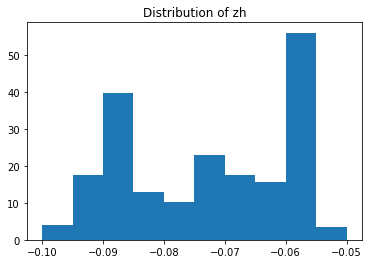

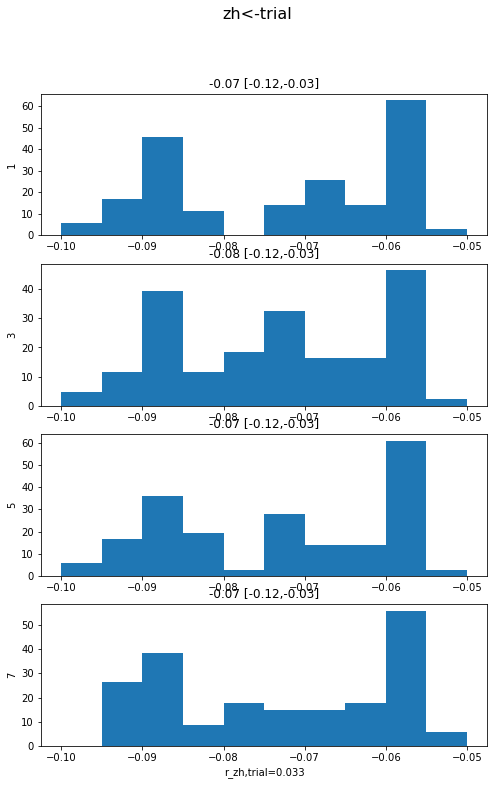

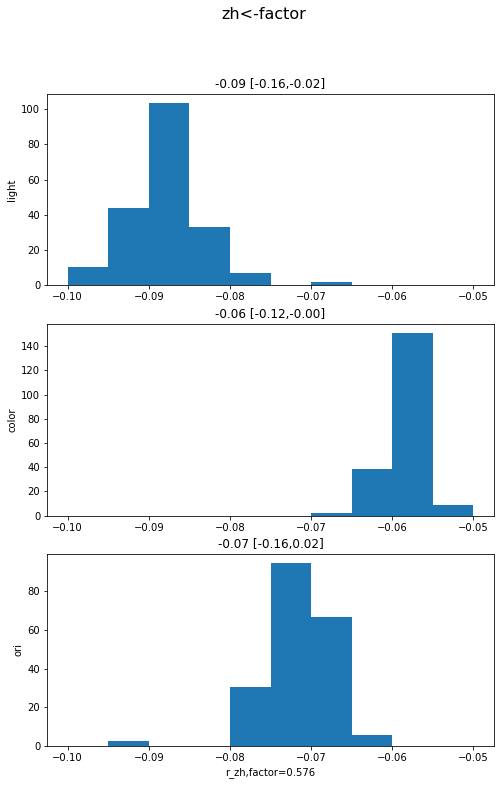

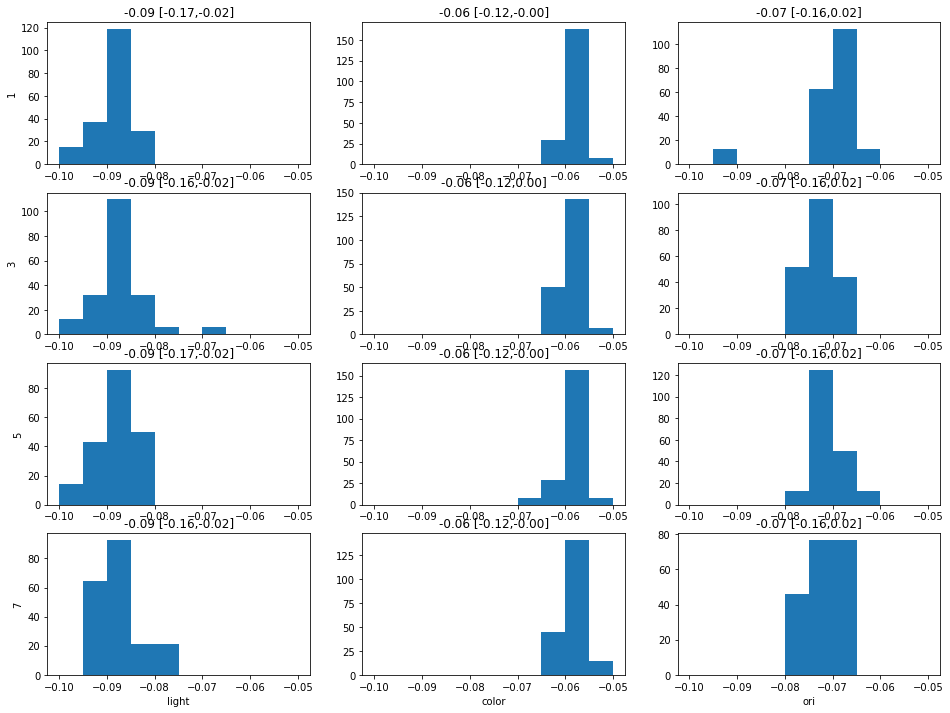

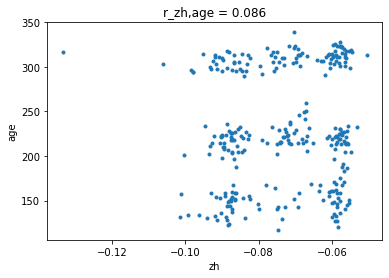

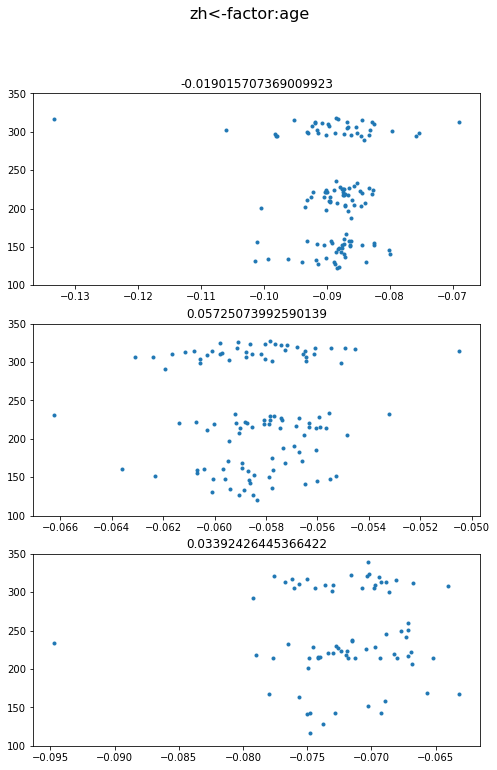

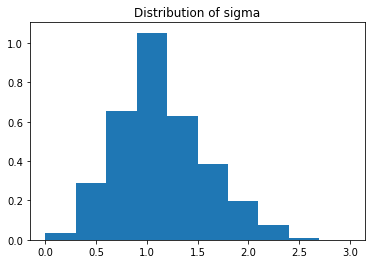

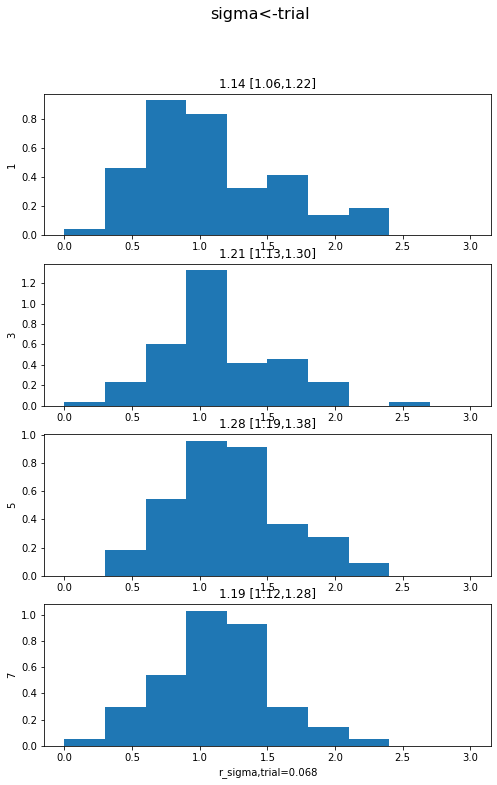

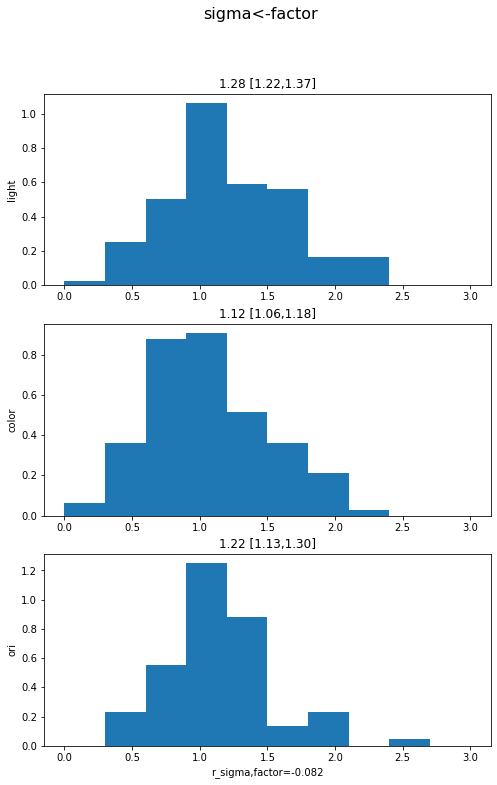

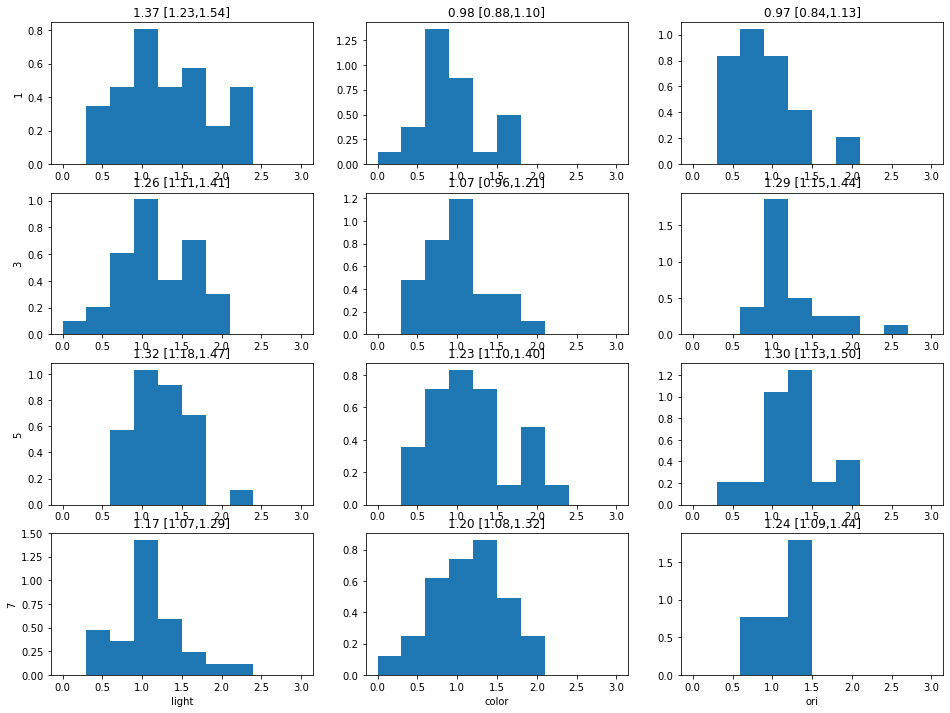

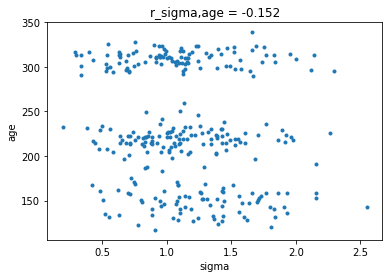

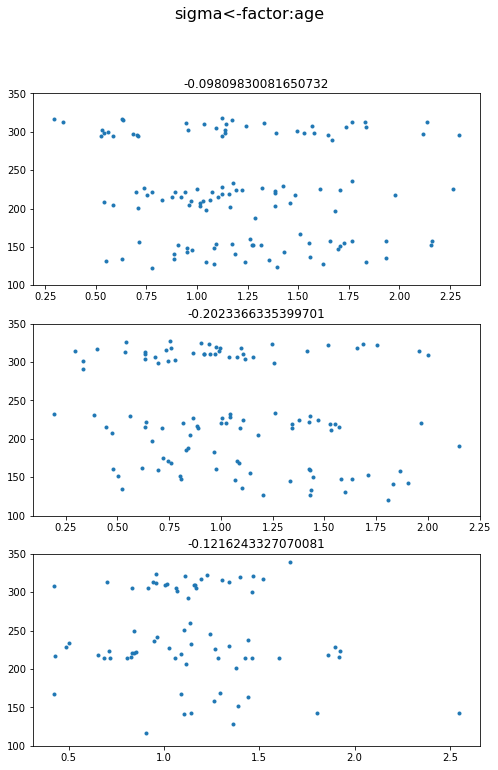

# Lognormal hidden markov partial pooling

In [13]:
for k in range(3): printCI(ws[k],var='z0m')
for k in range(3): printCI(ws[k],var='z0a')
for k in range(3): printCI(ws[k],var='zhm')
print('')
for k in range(3): printCI(ws[k],var='zdm')


 1.255 [1.091,1.401]
 1.673 [1.511,1.785]
 1.491 [1.265,1.700]
 0.087 [0.026,0.152]
 0.046 [-0.004,0.106]
 0.086 [0.002,0.181]
 -0.071 [-0.113,-0.024]
 -0.070 [-0.109,-0.034]
 -0.038 [-0.088,0.011]

 0.467 [0.149,0.795]
 0.357 [0.043,0.641]
 0.680 [0.311,1.044]
 0.475 [0.156,0.794]
 0.097 [-0.204,0.357]
 -0.044 [-0.301,0.220]
 0.376 [0.069,0.603]
 0.233 [-0.117,0.530]
 -0.003 [-0.411,0.316]
 -0.134 [-0.465,0.263]
 -0.218 [-0.651,0.287]
 -0.151 [-0.637,0.372]


In [92]:
import pystan
model = """
data {
    int<lower=0> N; //nr subjects
    real<lower=0> y[N,10];
    int<lower=0,upper=10> xSC[N];
    real xA[N];
}parameters {
    real<lower=0,upper=20> sigmaY[N];
    real<lower=0,upper=20> sigmaZ[N];
    real<lower=0,upper=20> zhs;
    real<lower=0,upper=20> zds;
    real<lower=0,upper=20> z0s;
    real<lower=-100,upper=100> z[N,10];
    real zd[N];
    real zh[N];
    real<lower=-100,upper=100> zhm;
    real<lower=-100,upper=100> zdmd[3];
    real<lower=-100,upper=100> zdt[4];
    real<lower=-100,upper=100> z0m[3];
    real<lower=-100,upper=100> z0a;
} transformed parameters {
    real<lower=-100,upper=100> zdm[3];
    real z0[N];
    zdm[1]=0;
    zdm[2]=zdmd[2]-zdmd[1];
    zdm[3]=zdmd[3]-zdmd[1];
    for (n in 1:N) z0[n]<-z[n,1];
}model{
for (n in 1:N){
    sigmaY[n]~cauchy(0,1);
    sigmaZ[n]~cauchy(0,1);

    zh[n]~normal(zhm,zhs);
    zd[n]~normal(zdmd[xD[n]] +zdt[xSC[n]/2],zds);
    z[n,1]~normal(z0m[xD[n]]+z0a*xA[n],z0s);
    for (t in 1:10){
        if (t>1 && y[n,t]>0) z[n,t]~normal(z[n,t-1]+zh[n]+(xSC[n]==t)*zd[n],sigmaZ[n]);
        if (y[n,t]>0) y[n,t]~lognormal(z[n,t],sigmaY[n]);
    }
}}generated quantities {
real r[N,10];
for (n in 1:N){
    for (t in 1:10)
        r[n,t]=normal_rng(z[n,t],sigmaY[n]);
}}
"""
smLNHP = pystan.StanModel(model_code=model)
with open(DPATH+f'smLNHP.pkl', 'wb') as f: pickle.dump(smLNHP, f)  

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_707227d466aa4023951cd0f11494b4fe NOW.


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
<ipython-input-93-ea7c990a2ed9>:7: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  with open(DPATH+f'smLNHP%d.stanfit'%dim,'wb') as f: pickle.dump(fit,f,protocol=-1)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [9]:
ws=[]
Dall=[]
for dim in [0,1,2]:
    sel=np.logical_and(yLT[:,7]>0,xD==dim)
    temp={'y':yLT[sel,:],'N':sel.sum(),'xSC':np.int32(xSC[sel])+1}
    with open(DPATH+f'smLNHP.pkl', 'rb') as f: smLNHP=pickle.load(f)
    with open(DPATH+f'smLNHP%d.stanfit'%dim,'rb') as f: fit=pickle.load(f)
    ws.append(fit.extract())
    #print(fit)
    Dall.append(np.concatenate([yLT[sel,:],np.array([xSC[sel],xD[sel],xAge[sel]]).T],1))  

<ipython-input-9-c6ee5a284518>:4: RuntimeWarning: invalid value encountered in greater
  sel=np.logical_and(yLT[:,7]>0,xD==dim)
<ipython-input-9-c6ee5a284518>:4: RuntimeWarning: invalid value encountered in greater
  sel=np.logical_and(yLT[:,7]>0,xD==dim)


e0 (1200, 301)


<ipython-input-64-cee4083de101>:36: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.median(z,0),normed=True,bins=bns)
<ipython-input-64-cee4083de101>:43: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.median(z[:,x[:,0]==k],0),normed=True,bins=bns)
<ipython-input-64-cee4083de101>:53: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.median(z[:,x[:,1]==k],0),normed=True,bins=bns)
<ipython-input-64-cee4083de101>:64: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(np.median(temp,0),bins=bns,normed=True)


ed (1200, 301)
z0 (1200, 301)
zd (1200, 301)


<ipython-input-64-cee4083de101>:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(8,12))
<ipython-input-64-cee4083de101>:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16,12))
<ipython-input-64-cee4083de101>:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipytho

zh (1200, 301)
sigmaY (1200, 301)
sigmaZ (1200, 301)


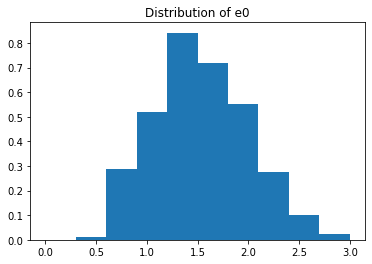

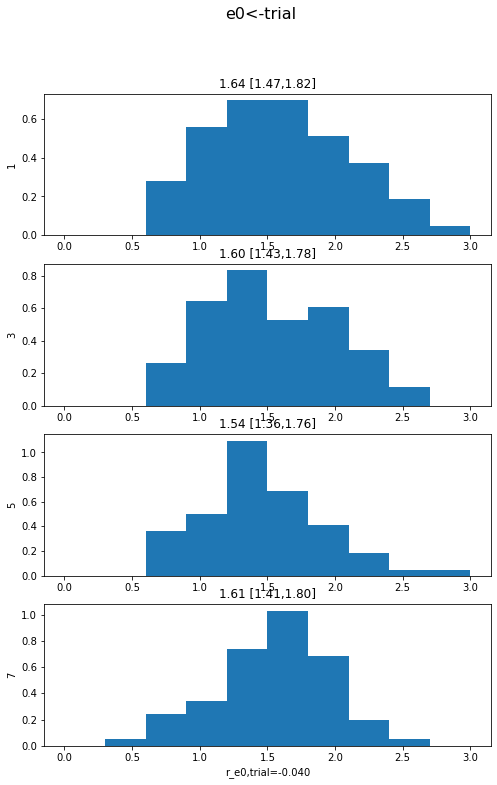

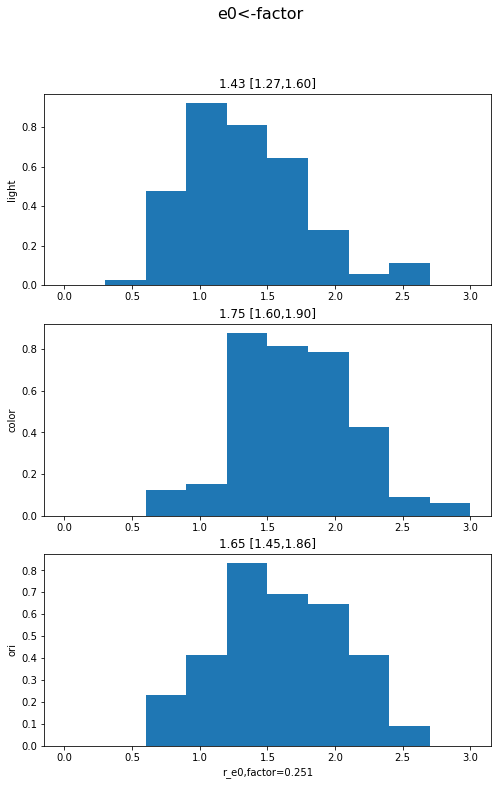

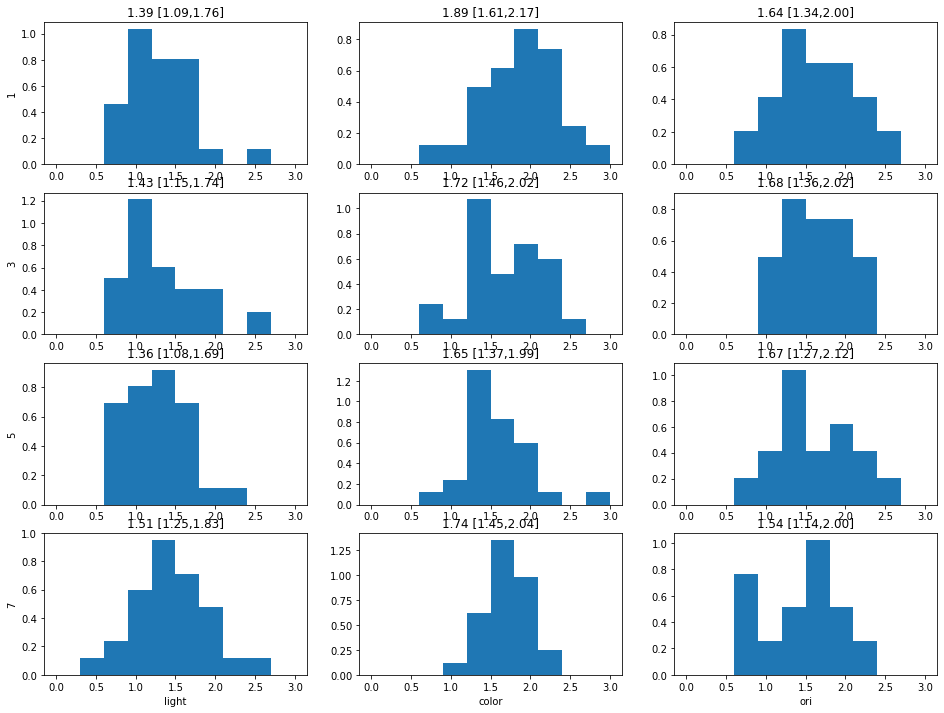

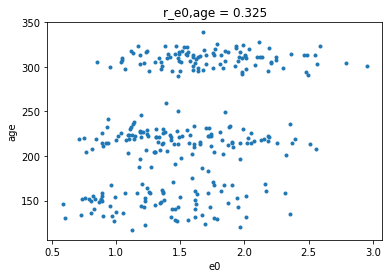

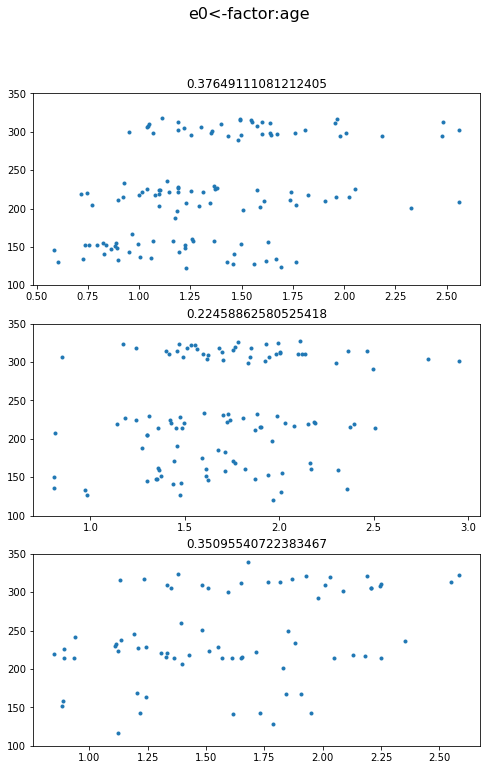

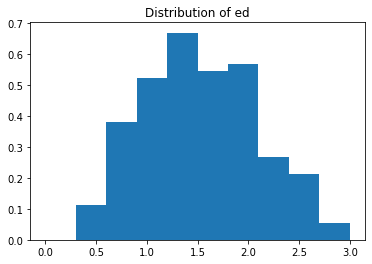

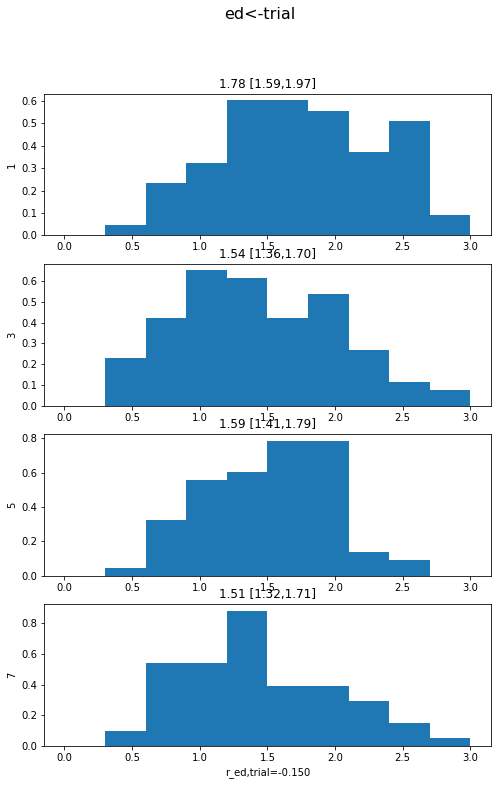

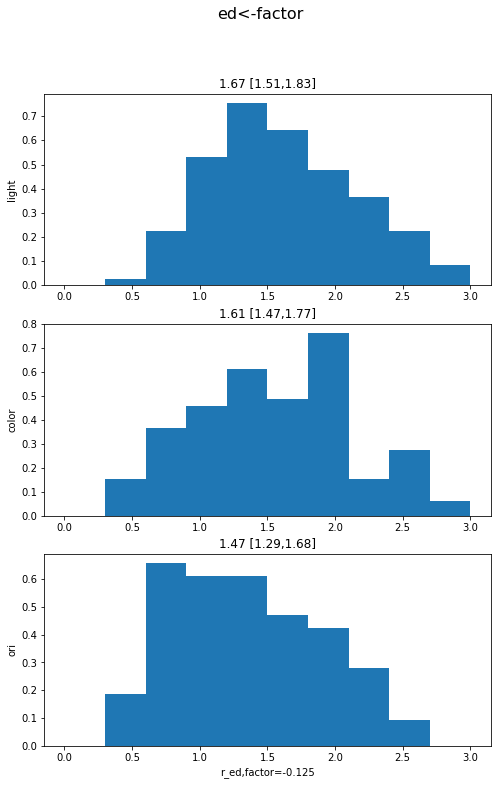

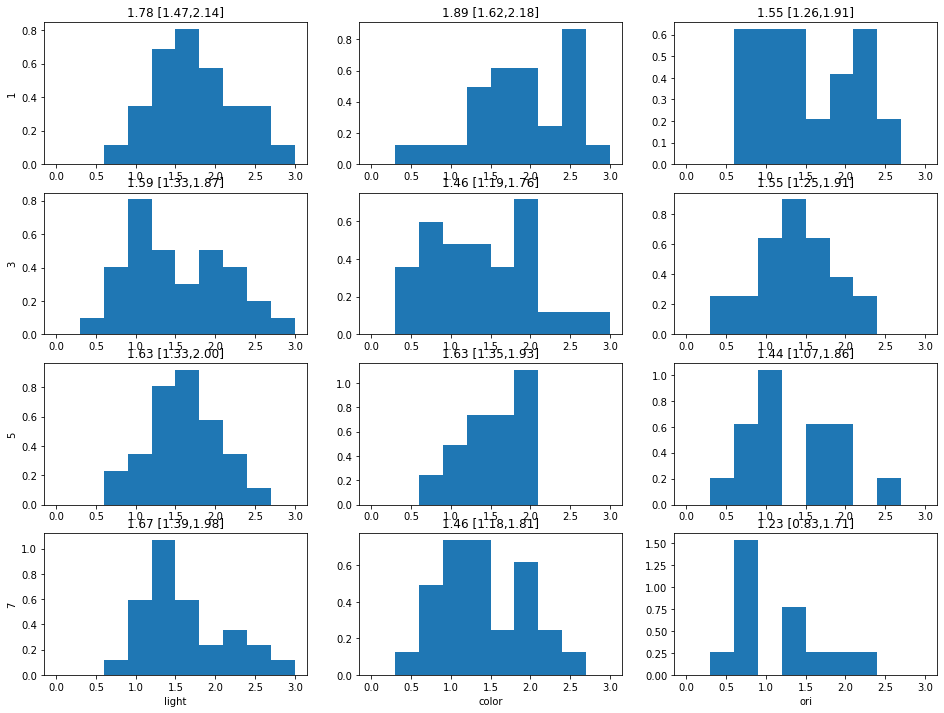

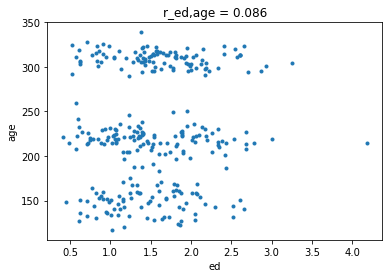

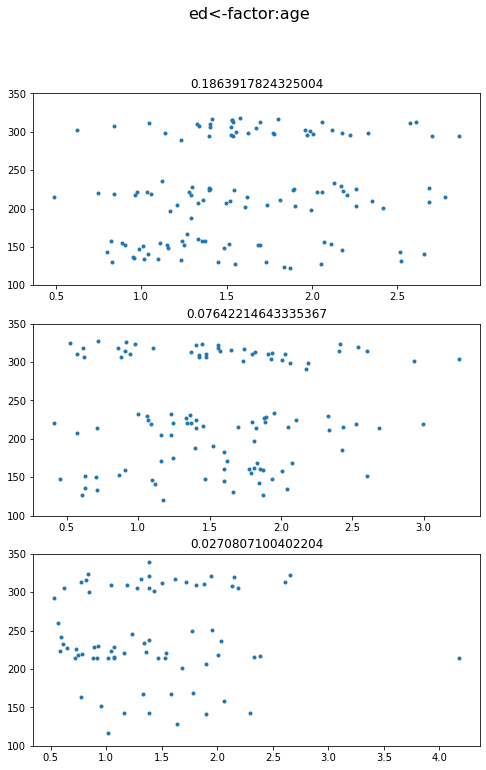

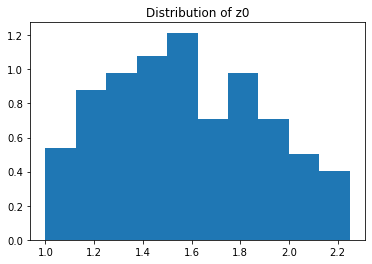

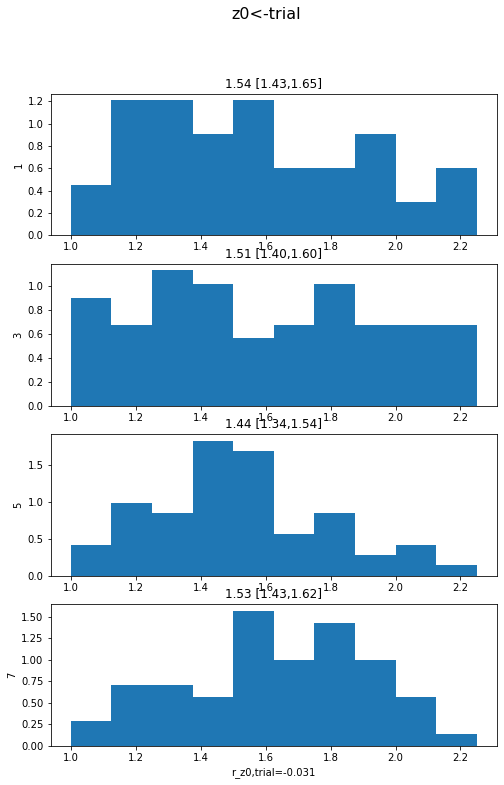

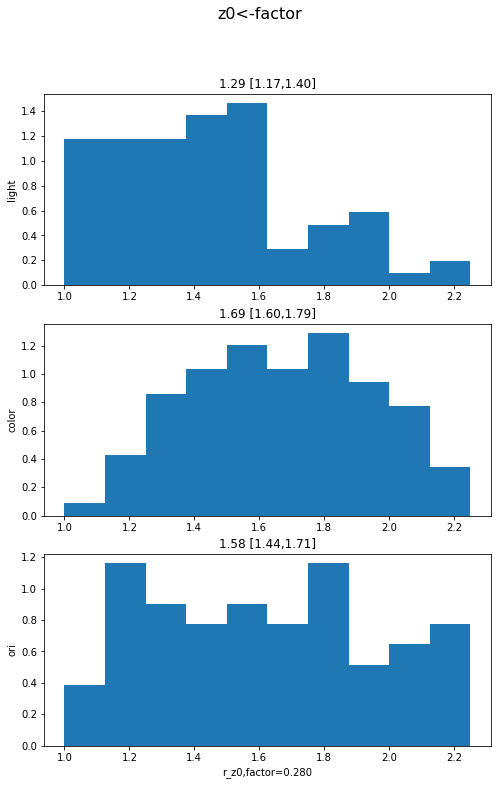

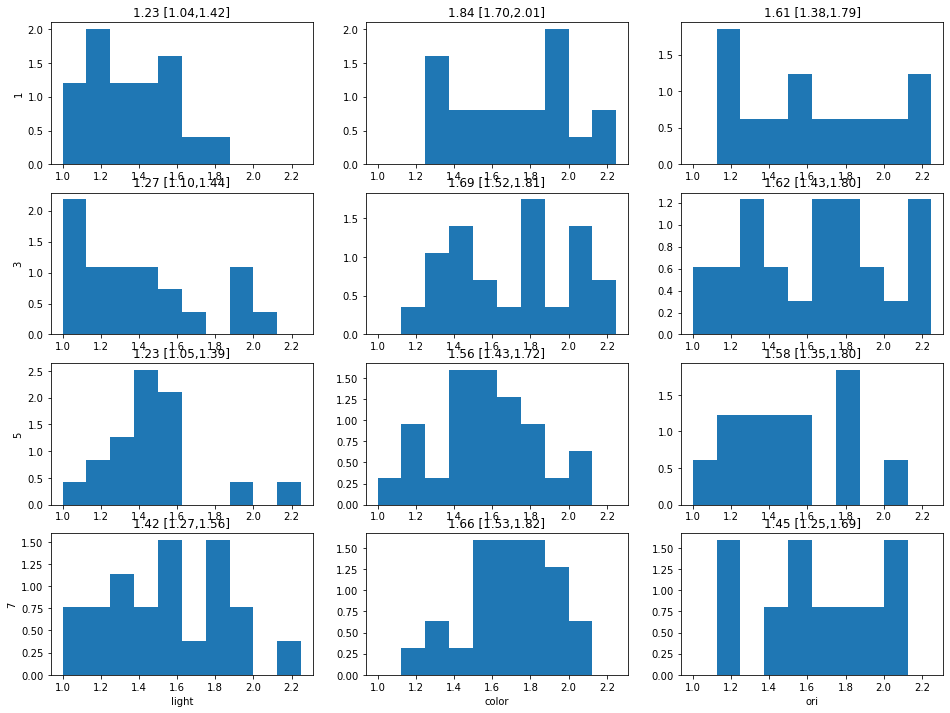

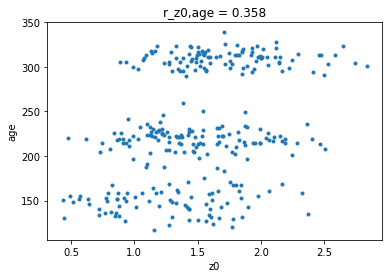

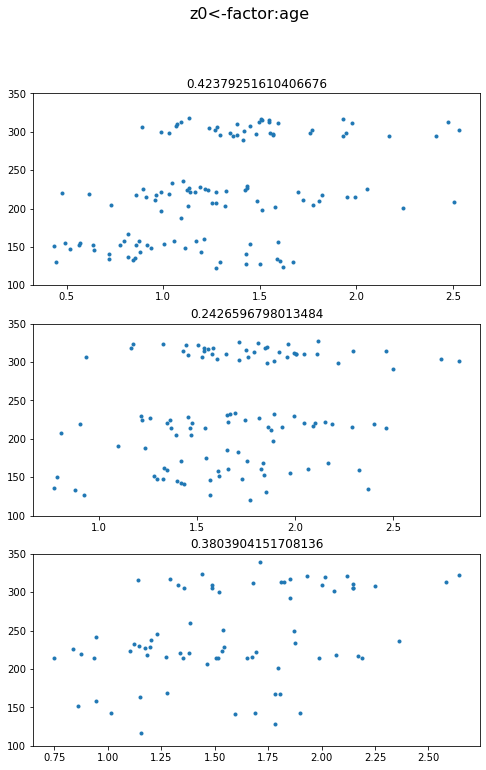

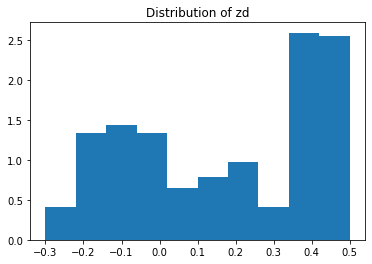

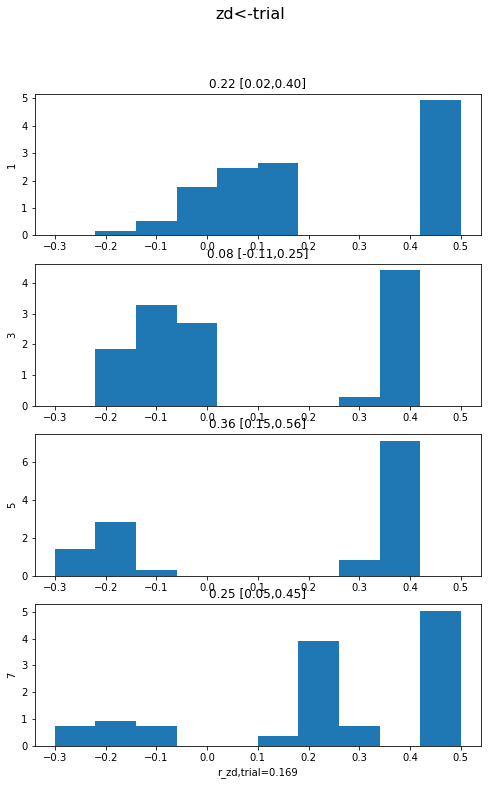

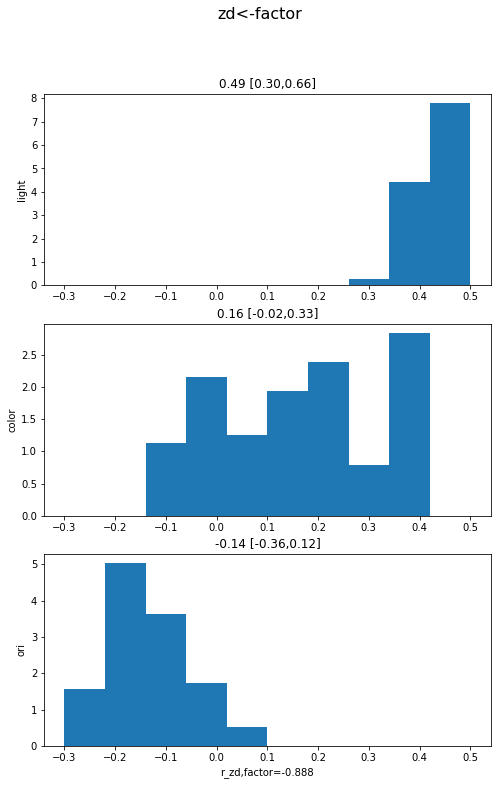

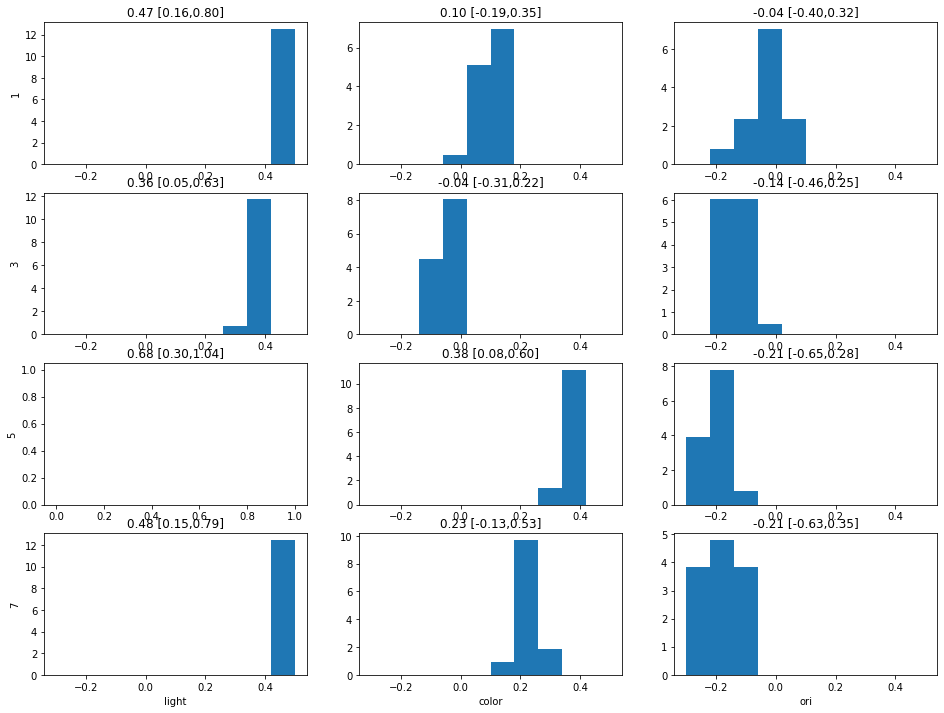

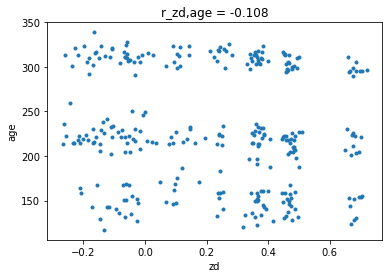

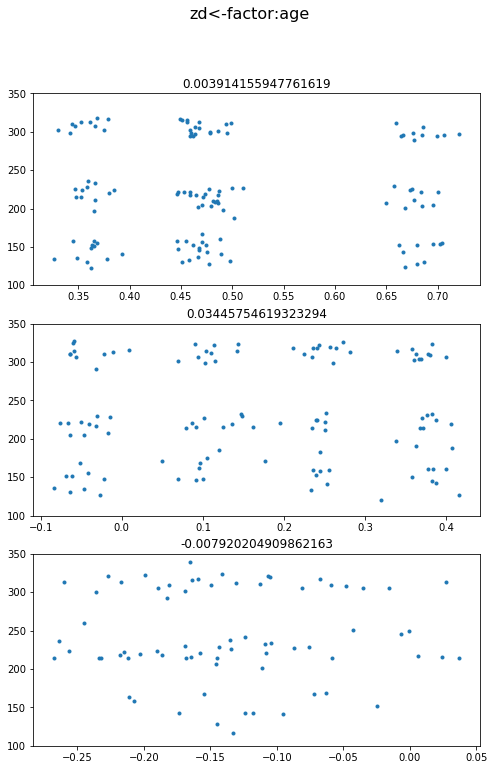

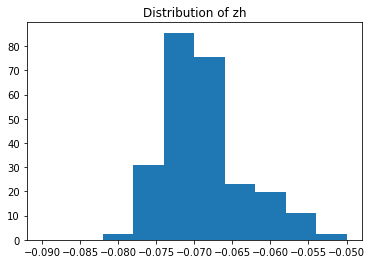

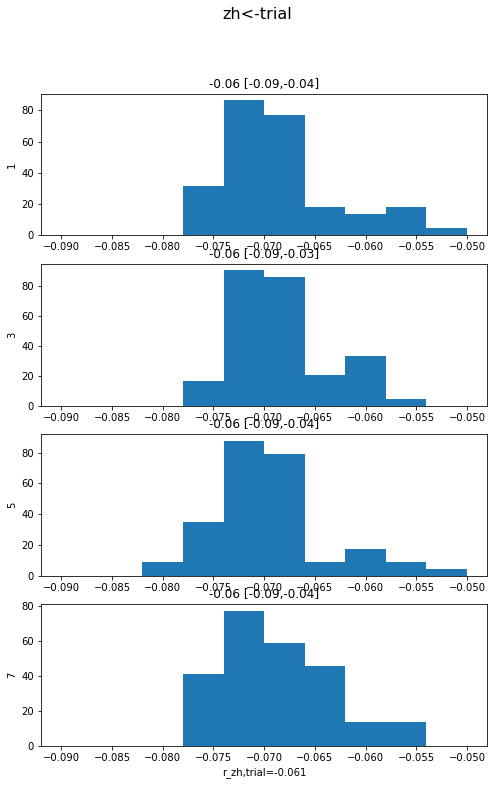

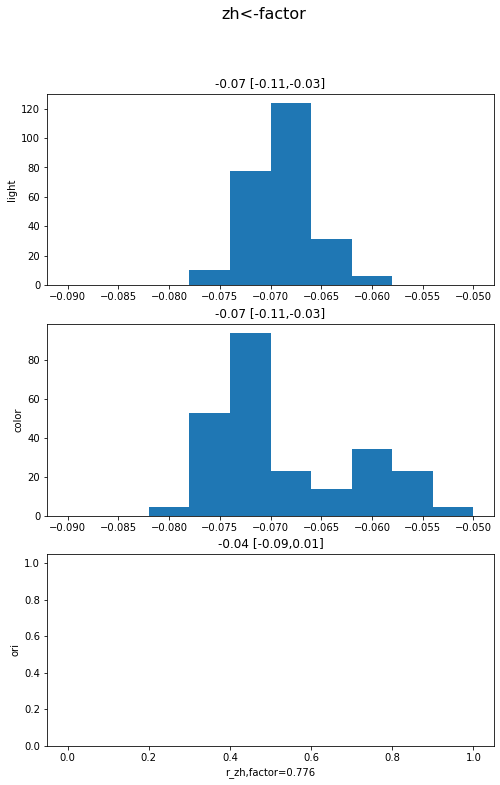

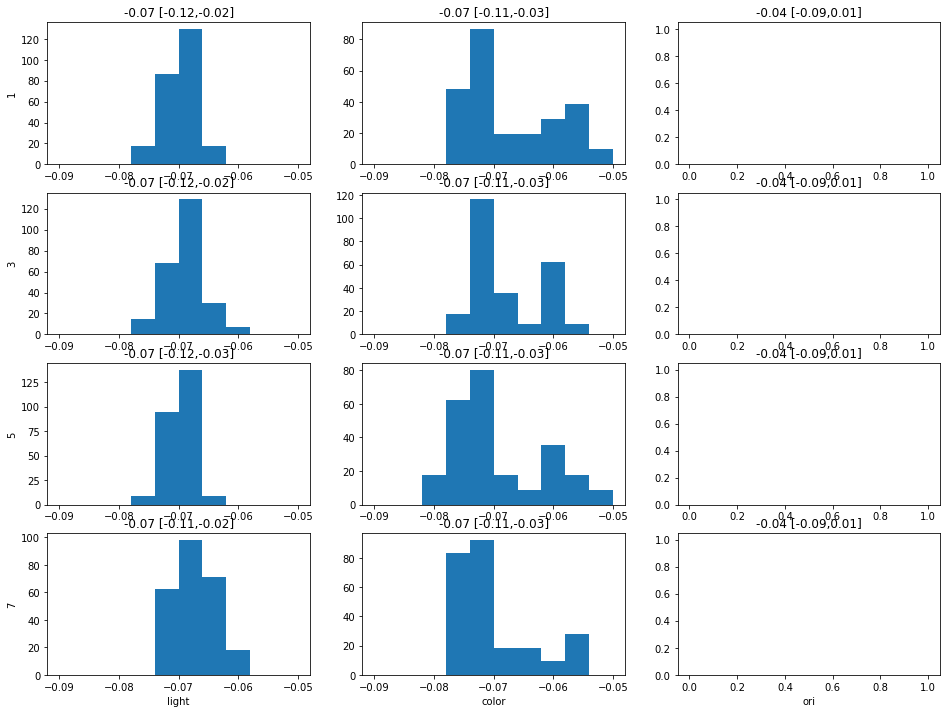

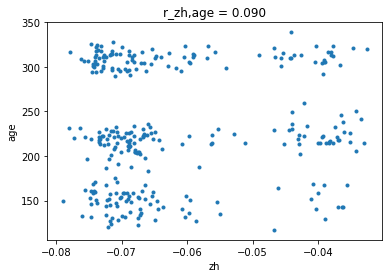

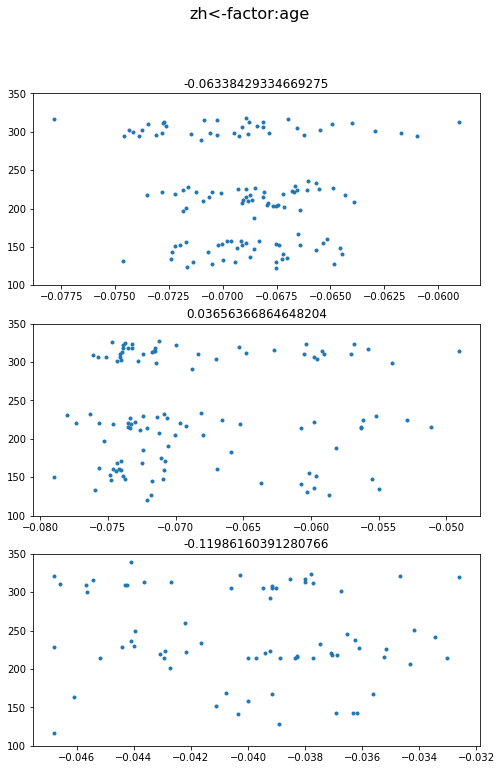

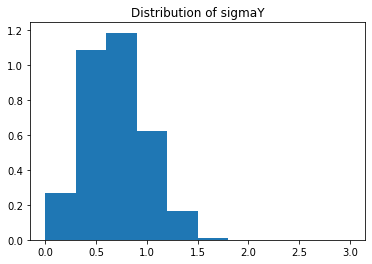

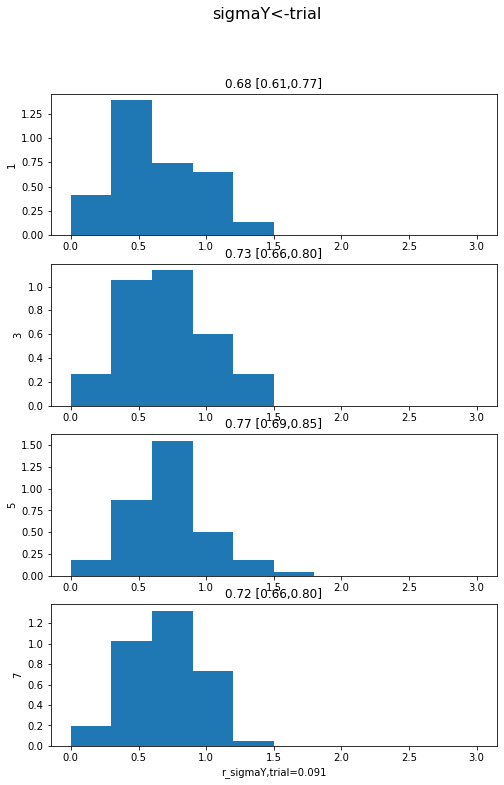

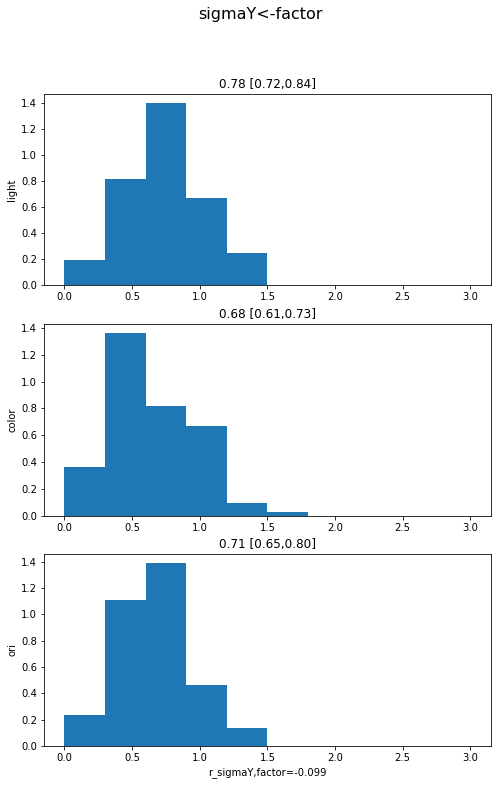

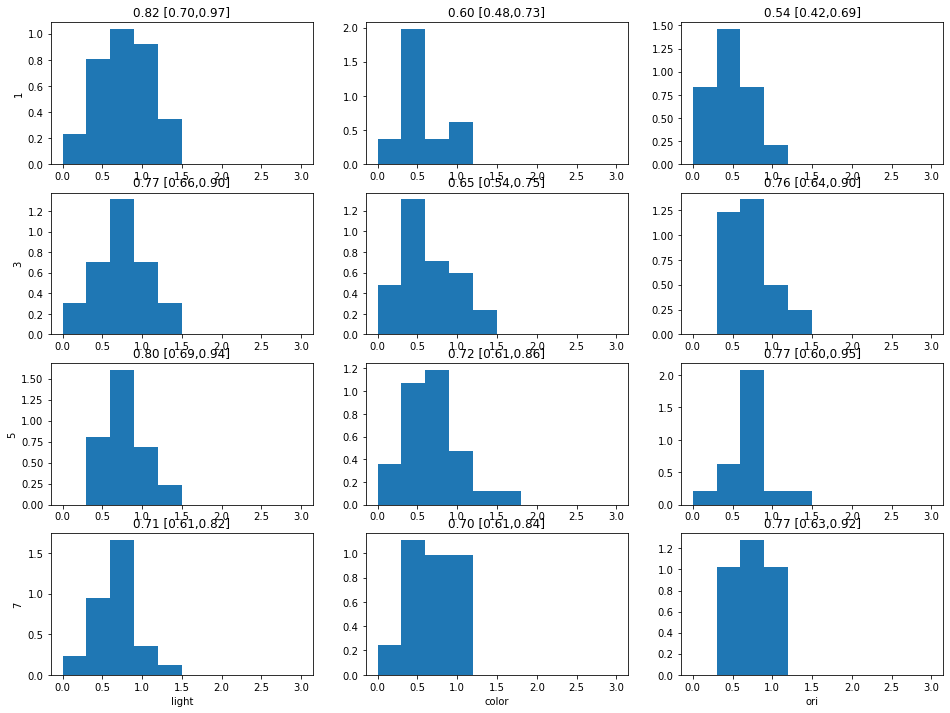

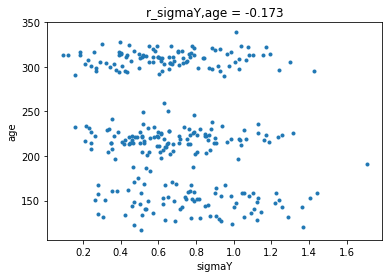

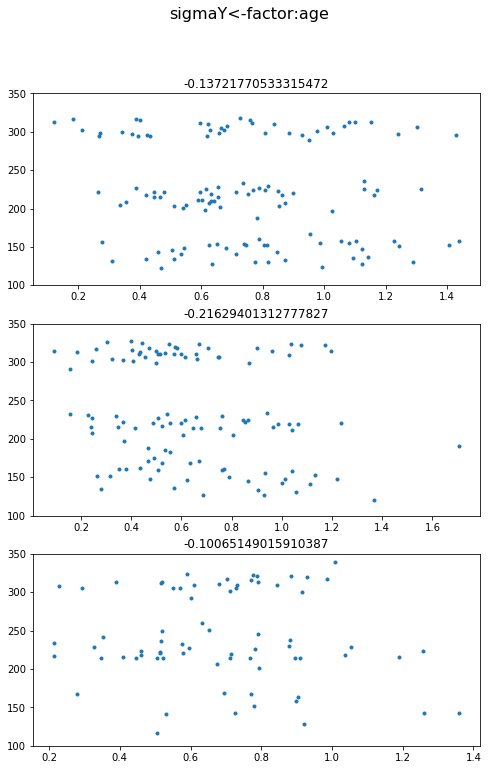

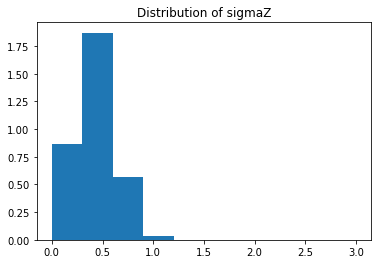

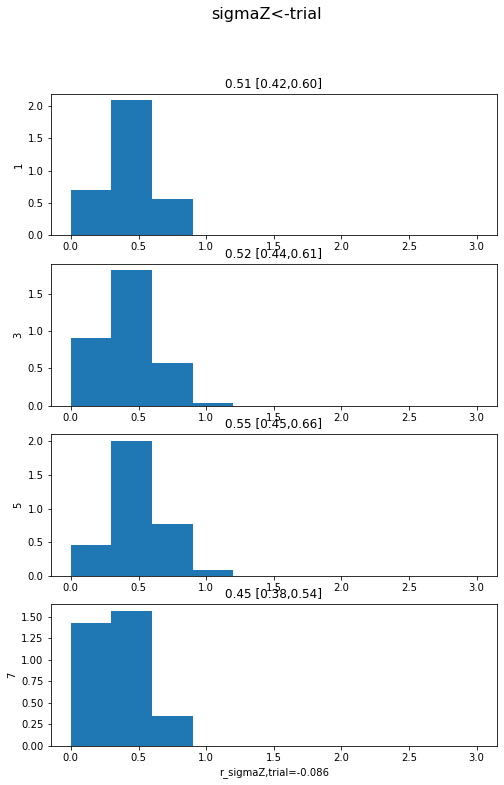

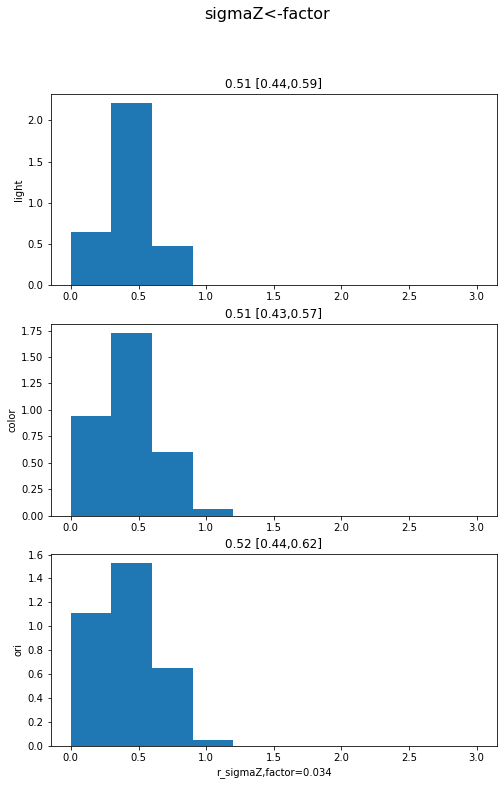

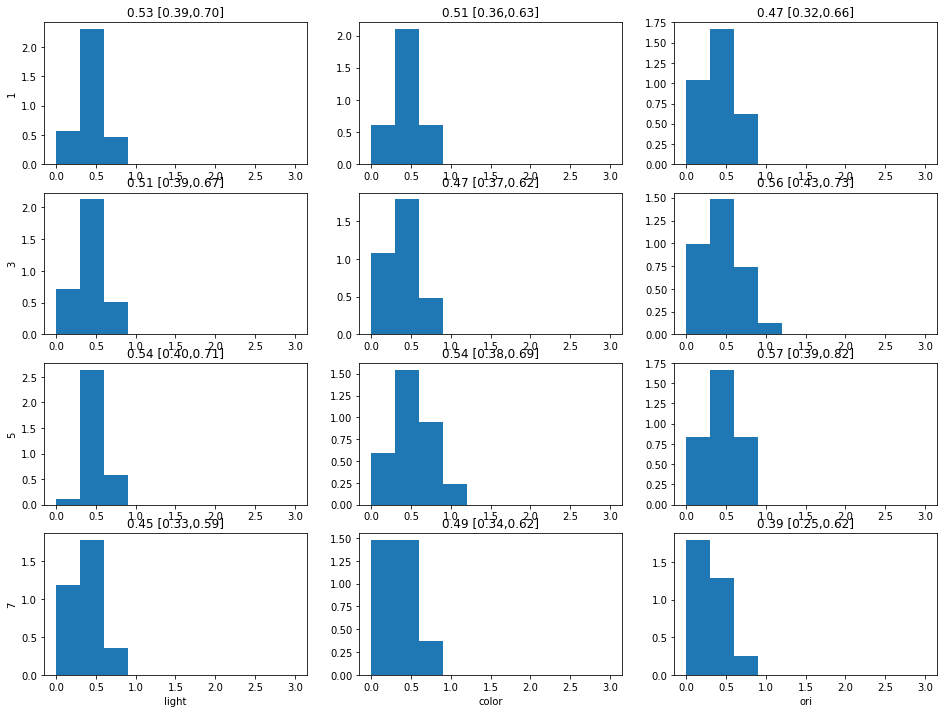

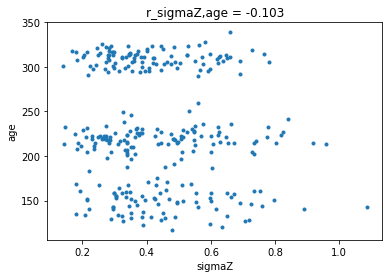

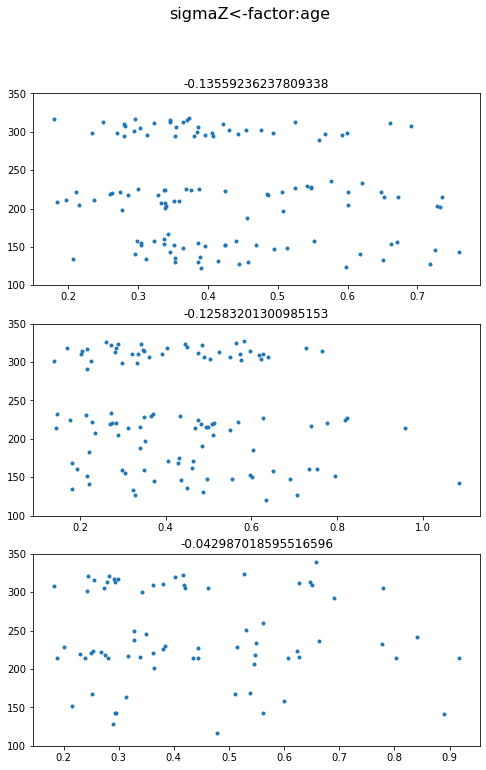

In [95]:
plotResults(ws,np.concatenate(Dall,0),
    zlu=[[0,3],[0,3],[1,2.25],[-0.3,0.5],[-0.09,-0.05],[0,3],[0,3],[0,3]])

# Normal model

In [6]:
import pystan
model = """
data {
    int<lower=0> N; //nr subjects
    real<lower=0> y[N,10];
    int<lower=0,upper=10> x[N];
}parameters {
    real<lower=0> sigma;
    real z0[N];
    real zd[N];
    real zh[N];
}model {
for (n in 1:N){
    y[n,1]~normal(z0[n],sigma);
    for (t in 2:10)
        if (y[n,t]>0)
            y[n,t]~normal(y[n,t-1] +zh[n]+(x[n]==t)*zd[n],sigma);
}}generated quantities {
real r[N,10];
for (n in 1:N){
    r[n,1]=normal_rng(z0[n],sigma)-y[n,1];
    for (t in 2:10)
        if (y[n,t]>0)
            r[n,t]=normal_rng(y[n,t-1]+zh[n]+(x[n]==t)*zd[n],sigma)-y[n,t];
        else
            r[n,t]=0;
}}

"""
smN = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_97b56337ba1dd302c7aa5736fb4c2de4 NOW.


In [7]:
yLT[np.isnan(yLT)]=0
sel=np.logical_and(xLT[:,0]>=0,yLT[:,2]>0)
temp={'y':yLT[sel,:],'N':sel.sum(),'x':np.int32(xLT[sel,0]+1)}
fit=smN.sampling(data=temp,chains=6,n_jobs=6,
        seed=1,thin=1,iter=500,warmup=200)
print(fit)
w=fit.extract()
z0=np.median(w['z0'],0);zd=np.median(w['zd'],0)
zh=np.median(w['zh'],0);res=np.median(w['r'],0)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_97b56337ba1dd302c7aa5736fb4c2de4.
6 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1800.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma       7.37  4.1e-3   0.13   7.13   7.28   7.37   7.46   7.63   1014   1.01
z0[1]      10.47    0.17   7.34   -4.0    5.6  10.47  15.41  24.88   1825    1.0
z0[2]       1.62    0.18   7.52 -13.25   -3.5   1.56   6.71  16.04   1751    1.0
z0[3]       3.41    0.15   7.27 -10.93  -1.72   3.38   8.32   17.6   2343    1.0
z0[4]       1.28    0.17   7.47 -13.42   -3.8   1.35   6.25  15.92   2033    1.0
z0[5]       2.14    0.16   7.25 -12.02  -2.76   2.07   7.27  16.45   1932    1.0
z0[6]       8.05    0.15    7.2  -5.46   3.05   7.95  12.91  22.59   2198    1.0
z0[7]      12.48    0.15   7.32  -2.27    7.7  12.49  17.33  26.38   2409    1.0
z0[8]       3.61    0.17   7.04  -9.94  -0.89   3.59   8.34  17.05   1677    1.0
z0[9

In [28]:
import pystan
invgammafun='''functions{
    vector invdigamma(vector x){
        vector[num_elements(x)] y; vector[num_elements(x)] L;
        for (i in 1:num_elements(x)){
            if (x[i]==digamma(1)){ 
                y[i]=1;
            }else{ if (x[i]>=-2.22){
                y[i]=(exp(x[i])+0.5);
            }else{
                y[i]=-1/(x[i]-digamma(1));
        }}}
        L=digamma(y)-x;
        while (abs(min(L))>10^-12){
            y=y-L ./trigamma(y);
            L=digamma(y)-x;}
        return y;}
    real invdigammaR(real x){
        real y; real L;
        if (x==digamma(1)){ 
            y=1;
        }else{ if (x>=-2.22){
            y=(exp(x)+0.5);
        }else{
            y=-1/(x-digamma(1));
        }}
        L=digamma(y)-x;
        while (abs(L)>10^-8){
            y=y-L ./trigamma(y);
            L=digamma(y)-x;}
        return y;
    }} '''

model = """
data {
    int<lower=0> N; //nr subjects
    real<lower=0> y[N,10];
    int<lower=0,upper=10> x[N];
}parameters {
    //real<lower=-1000,upper=1000> sigma;
    real<lower=-1000,upper=1000> z0[N];
    real<lower=-1000,upper=1000> zd[N];
    real<lower=-1000,upper=1000> zh[N];
}model {
real z[N,10];
for (n in 1:N){
    //z0[n]~normal(0,10);
    //zd[n]~normal(0,10);
    //zh[n]~normal(0,10);
    
    z[n,1]<-z0[n];
    for (t in 2:10)
        z[n,t]<-z[n,t-1] +zh[n]+(x[n]==t)*zd[n];
    for (t in 1:10)
        if (y[n,t]>0)
            y[n,t]~gamma(invdigammaR(z[n,t]-0),exp(0));
}}
"""
smG = pystan.StanModel(model_code=invgammafun+model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b23fe8d3459ffe304350983ac6f8595b NOW.


In [29]:
yLT[np.isnan(yLT)]=0
sel=np.logical_and(xLT[:,0]>=0,yLT[:,2]>0)
sel[:]=False
sel[[5,6]]=True
temp={'y':yLT[sel,:],'N':sel.sum(),'x':np.int32(xLT[sel,0]+1)}
fit=smG.sampling(data=temp,chains=4,n_jobs=4,
        seed=1,thin=2,iter=10000,warmup=5000)
print(fit)
w=fit.extract()
z0=np.median(w['z0'],0);zd=np.median(w['zd'],0)
zh=np.median(w['zh'],0)

Inference for Stan model: anon_model_b23fe8d3459ffe304350983ac6f8595b.
4 chains, each with iter=10000; warmup=5000; thin=2; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
z0[1]  -4.43    6.21 579.29 -955.6 -507.1  -0.58 496.33 953.02   8703    1.0
z0[2]   1.24    6.11 574.66 -945.3 -493.1   5.04 493.78 952.19   8842    1.0
zd[1]  -9.63    6.12 580.49 -955.2 -512.2 -16.64 496.73 946.89   8996    1.0
zd[2]   6.03    6.13 573.88 -947.4 -489.9   4.33 499.78 952.51   8758    1.0
zh[1]  -1.25    6.08  578.2 -944.2 -504.1  -9.93 504.77 951.58   9034    1.0
zh[2]   8.44    6.05 576.17 -945.8 -497.3  18.29 507.56 949.47   9082    1.0
lp__    33.6    0.03   2.08   28.5  32.48  33.97  35.12  36.54   6392    1.0

Samples were drawn using NUTS at Wed Jun 19 13:53:44 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chai

(array([1054.,  976.,  981.,  990., 1037.,  929.,  981., 1015., 1020.,
        1017.]),
 array([-999.6414709 , -799.72705669, -599.81264247, -399.89822826,
        -199.98381404,   -0.06939983,  199.84501439,  399.7594286 ,
         599.67384282,  799.58825703,  999.50267125]),
 <a list of 10 Patch objects>)

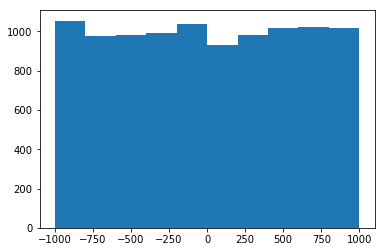

In [27]:
plt.hist(w['z0'][:,0])

In [83]:
invgammafun='''functions{
    vector invdigamma(vector x){
        vector[num_elements(x)] y; vector[num_elements(x)] L;
        for (i in 1:num_elements(x)){
            if (x[i]==digamma(1)){ 
                y[i]=1;
            }else{ if (x[i]>=-2.22){
                y[i]=(exp(x[i])+0.5);
            }else{
                y[i]=-1/(x[i]-digamma(1));
        }}}
        L=digamma(y)-x;
        while (min(abs(L))>10^-12){
            y=y-L ./trigamma(y);
            L=digamma(y)-x;}
        return y;}
    real invdigammaR(real x){
        real y; real L;
        if (x==digamma(1)){ 
            y=1;
        }else{ if (x>=-2.22){
            y=(exp(x)+0.5);
        }else{
            y=-1/(x-digamma(1));
        }}
        L=digamma(y)-x;
        while (abs(L)>10^-10){
            y=y-L ./trigamma(y);
            L=digamma(y)-x;}
        return y;
    }} '''

model=invgammafun+'''
generated quantities{
    real a;
    real g;
    real ra;
    a= uniform_rng(-100,100);
    g=invdigammaR(a);
    ra=digamma(g);
}
'''
sm=pystan.StanModel(model_code=model)
fit=sm.sampling(iter=100, chains=4,thin=2,warmup=50,n_jobs=4,algorithm="Fixed_param")
w=fit.extract()
assert np.allclose(w['ra'],w['a'])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_90bd79cc8c0b87b2d2b83b1a3f591543 NOW.


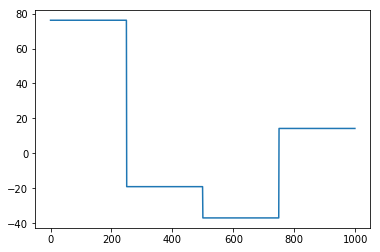

In [18]:
plt.plot(w['z0'][:,0])

In [30]:
def invdigamma(x):
    ''' computes inverse of digamma function
        >>> x=np.linspace(0,10,11)
        >>> plt.plot(x,invdigamma(digamma(x))) '''
    m=x>=-2.22
    y=m*(np.exp(x)+0.5)-(1-m)/(x-digamma(1))
    if type(y) is np.ndarray: y[np.isnan(y)]=1
    elif np.isnan(y): y=1
    L=digamma(y)-x
    while np.abs(np.min(L))>1e-8:
        y=y-L/polygamma(1,y)
        L=digamma(y)-x
    return y

In [63]:
xAll.shape

(359, 4)

In [8]:
import pickle
yLT=np.load('yLT.npy')
xAll=np.load('xAll.npy')
nm='ATP'
with open(DPATH+f'{nm}.sm', 'rb') as f: sm=pickle.load(f)
with open(DPATH+f'{nm}.stanfit','rb') as f: fit=pickle.load(f)
print(fit)

Inference for Stan model: anon_model_5c64ea2bdd0a0992388b61f151de35ec.
6 chains, each with iter=10000; warmup=6000; thin=10; 
post-warmup draws per chain=400, total post-warmup draws=2400.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
z0[1]      -98.12    3.58  40.83 -179.0 -126.6 -99.34 -66.46 -22.39    130   1.06
z0[2]      -103.7     5.4  46.61 -185.1 -142.1 -105.0 -66.35 -20.62     75   1.08
z0[3]      -102.4    4.67  45.02 -191.1 -135.2 -101.8 -69.27 -20.97     93   1.07
z0[4]      -97.81     3.6  40.78 -177.4 -126.1 -98.37 -66.18 -22.68    129   1.06
z0[5]      -102.6    4.64  45.03 -190.9 -134.3 -105.2 -69.14 -20.31     94   1.07
z0[6]      -90.85    5.08   44.4 -180.6 -122.4 -90.43 -58.73 -13.79     76   1.09
z0[7]      -96.95    4.69  43.55 -179.8 -129.3 -98.13 -61.67 -18.35     86   1.09
z0[8]       -95.6    3.16  40.69 -174.5 -123.5 -94.71 -67.53 -18.21    165   1.03
z0[9]      -61.36    2.14   25.0 -100.8 -81.23 -63.59 -42.59 -11.21    1

In [130]:
sel=sumr[:,-1]>1.1
nms[sel]

<ipython-input-130-e0d3c8b3a959>:1: RuntimeWarning: invalid value encountered in greater
  sel=sumr[:,-1]>1.1


array(['lp__'], dtype='<U10')

In [134]:
from matusplotlib import errorbar,pystanErrorbar,figure,subplot
w=fit.extract()

(-1, 10)

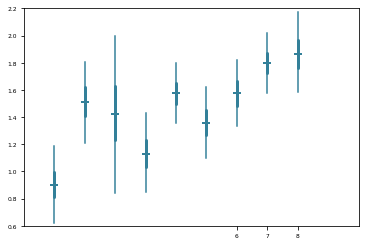

In [135]:
for i in range(3):
    errorbar(w['z0m'][:,:,i],x=np.arange(3)+i*3)
    #plt.gca().set_xticklabels([4,7,10])
    plt.ylim([0.6,2.2])
plt.xlim([-1,10])

(2400, 1)
(2400, 3, 3)


(-1, 15)

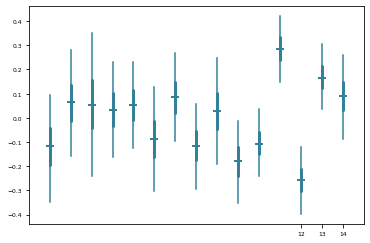

In [136]:
gm=w['z0m'].mean(axis=(1,2))[:,np.newaxis]
print(gm.shape)
med=w['z0m'].mean(2);med=med-gm
mea=w['z0m'].mean(1);mea=mea-gm
me=med[:,:,np.newaxis]+mea[:,np.newaxis,:]
print(me.shape)
for i in range(3):
    errorbar((w['z0m']-me)[:,:,i]-gm,x=np.arange(3)+i*3)
    #plt.gca().set_xticklabels([4,7,10])
    #plt.ylim([0.6,2.2])
errorbar(mea,x=np.arange(3)+3*3)
errorbar(med,x=np.arange(3)+4*3)
plt.xlim([-1,15])

(-1, 10)

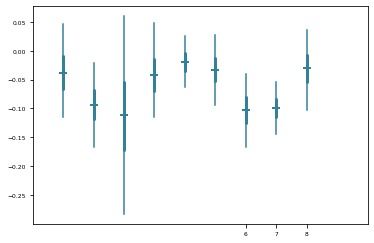

In [137]:
for i in range(3):
    errorbar(w['zhm'][:,:,i],x=np.arange(3)+i*3)
    #plt.gca().set_xticklabels([4,7,10])
    #plt.ylim([0.6,2.2])
plt.xlim([-1,10])

(2400, 1)
(2400, 3, 3)


(-1, 15)

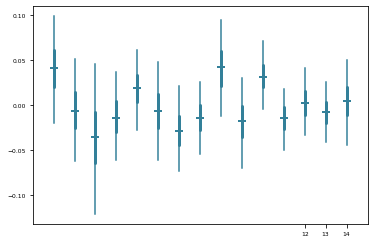

In [138]:
gm=w['zhm'].mean(axis=(1,2))[:,np.newaxis]
print(gm.shape)
med=w['zhm'].mean(2);med=med-gm
mea=w['zhm'].mean(1);mea=mea-gm
me=med[:,:,np.newaxis]+mea[:,np.newaxis,:]
print(me.shape)
for i in range(3):
    errorbar((w['zhm']-me)[:,:,i]-gm,x=np.arange(3)+i*3)
    #plt.gca().set_xticklabels([4,7,10])
    #plt.ylim([0.6,2.2])
errorbar(mea,x=np.arange(3)+3*3)
errorbar(med,x=np.arange(3)+4*3)
plt.xlim([-1,15])

(2400, 3, 3, 4)

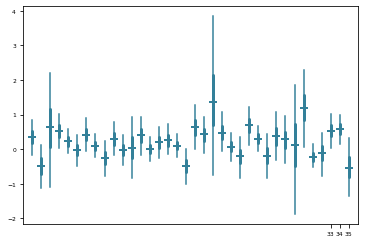

In [144]:
for j in range(3):
    for i in range(4):
        errorbar(w['zdm'][:,:,j,i],x=np.arange(3)+i*9+j*3)
        #plt.gca().set_xticklabels([4,7,10])
        #plt.ylim([0.6,2.2])
    plt.xlim([-1,36])

(2400, 1)
(2400, 3, 3, 4)


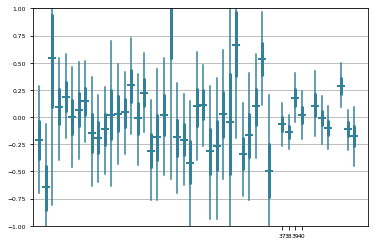

In [161]:
gm=w['zdm'].mean(axis=(1,2,3))[:,np.newaxis]
print(gm.shape)
med=w['zdm'].mean((2,3));med=med-gm
mea=w['zdm'].mean((1,3));mea=mea-gm
mes=w['zdm'].mean((1,2));mes=mes-gm
na=np.newaxis
me=med[:,:,na,na]+mea[:,na,:,na]+mes[:,na,na,:]
print(me.shape)
for j in range(3):
    for i in range(4):
        errorbar((w['zdm']-me)[:,:,j,i]-gm,x=np.arange(3)+i*9+j*3)
        #plt.gca().set_xticklabels([4,7,10])
        #plt.ylim([0.6,2.2])
errorbar(mes,x=np.arange(4)+37)
errorbar(mea,x=np.arange(3)+42)
errorbar(med,x=np.arange(3)+46)

plt.xlim([-1,50])
plt.ylim([-1,1])
plt.grid(True,axis='y')

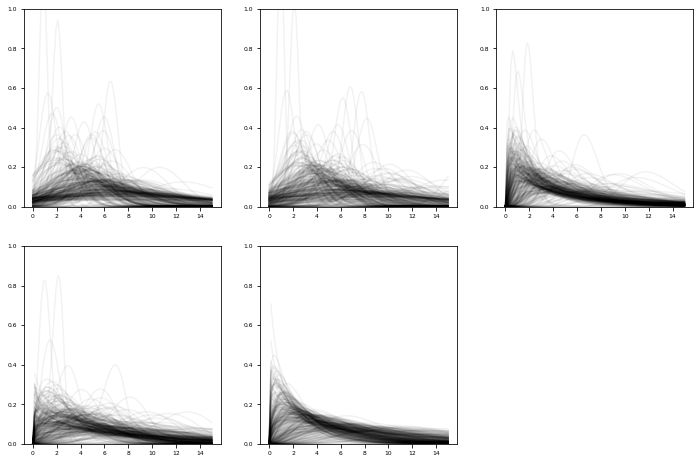

In [87]:
plt.figure(figsize=(12,8))
lg=False;rss=True
yLT=np.load('yLT.npy')
yLT[yLT==0]=np.nan
xAll=np.load('xAll.npy')
DPATH='standata/'
xtl=[]
sel=[]
for i in range(xAll.shape[0]): sel.append(yLT[i,int(xAll[i,0])+1]>0)
sel=np.array(sel)
y=yLT[sel,:]
out=[]
for j in range(5):
    if j==5: nm='GUP'
    else:nm='NXLWG'[j]+'TP'
    with open(DPATH+f'{nm}.sm', 'rb') as f: sm=pickle.load(f)
    with open(DPATH+f'{nm}.stanfit','rb') as f: fit=pickle.load(f)
    w=fit.extract()
    N=1000

    mu=[]
    for t in range(10):
        mu.append(np.median(w['z0'],0)+(t-1)*np.median(w['zh'],0)+np.int32(xAll[sel,0]<=t)*np.median(w['zh'],0))
    mu=np.array(mu).T
    sigma=np.median(w['sigma'],0)[:,na]
    x=np.linspace(0,15,101)[:,na,na]
    if nm[0]=='N':out=stats.truncnorm.pdf(x,-mu/sigma,np.inf,mu,sigma)
    elif nm[0]=='X':out=stats.truncnorm.pdf(x,-np.exp(mu)/sigma,np.inf,np.exp(mu),sigma)
    elif nm[0]=='L':out=stats.lognorm.pdf(x,sigma,scale=np.exp(mu))
    elif nm[0]=='W':out=stats.weibull_min.pdf(x,sigma,scale=np.exp(-mu))
    elif nm[0]=='G':out=stats.gamma.pdf(x,sigma,scale=np.exp(-mu))
    plt.subplot(2,3,j+1)
    plt.plot(x[:,0,0],out[:,:,0],'k',alpha=0.05);
    plt.ylim([0,1])

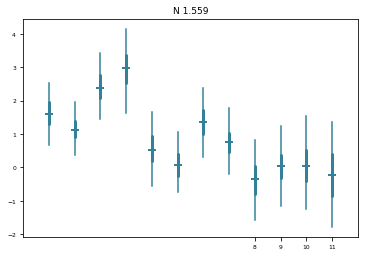

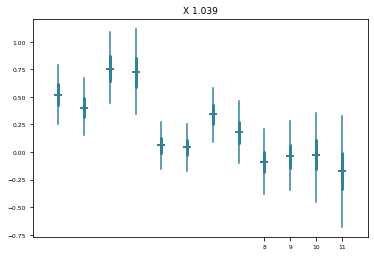

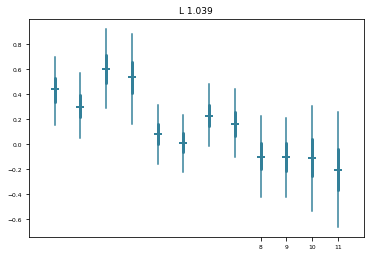

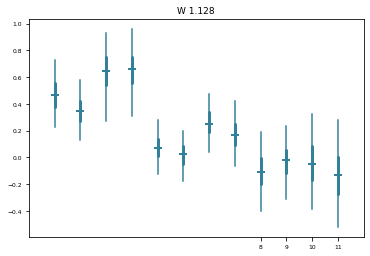

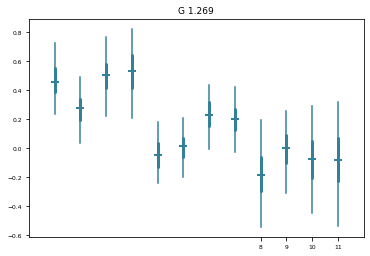

In [41]:
for nm in 'NXLWG':
    plt.figure()
    with open(f'standata/{nm}TU.sm', 'rb') as f: sm=pickle.load(f)
    with open(f'standata/{nm}TU.stanfit','rb') as f: fit=pickle.load(f)
    w=fit.extract()
    zd=w['zdm']
    if nm=='W' or nm=='G':sgn=-1
    else: sgn=1
    for i in range(3): errorbar(sgn*zd[:,i,:],x=np.arange(4)+i*4)
    plt.xlim([-1,12])
    sumr=fit.summary()
    plt.title(nm+' %.3f'%np.nanmax(sumr['summary'][:-1,-1]))

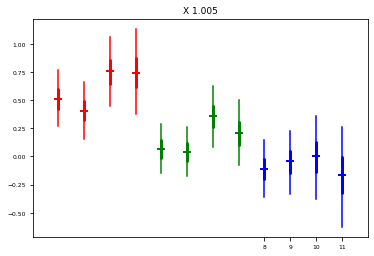

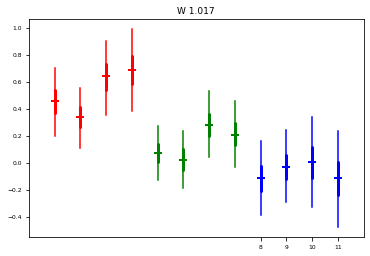

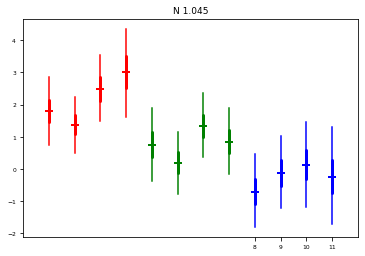

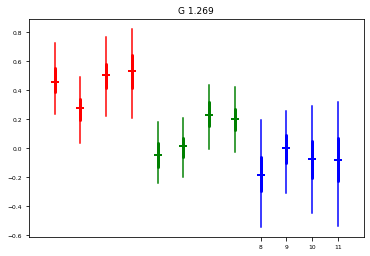

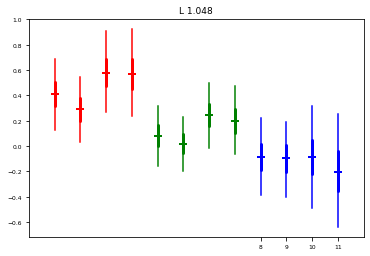

In [62]:
for nm in 'XWNGL':
    plt.figure()
    with open(f'standata/{nm}TU.sm', 'rb') as f: sm=pickle.load(f)
    with open(f'standata/{nm}TU.stanfit','rb') as f: fit=pickle.load(f)
    w=fit.extract()
    zd=w['zdm']
    if nm=='W' or nm=='G':sgn=-1
    else: sgn=1
    for i in range(3): errorbar(sgn*zd[:,i,:],x=np.arange(4)+i*4,clr='rgb'[i])
    plt.xlim([-1,12])
    sumr=fit.summary()
    plt.title(nm+' %.3f'%np.nanmax(sumr['summary'][:-1,-1]))

In [60]:
from matusplotlib import _errorbar

In [50]:
from scipy.stats import scoreatpercentile as sap

In [11]:
with open('standata/NMN.sm', 'rb') as f: sm=pickle.load(f)
with open('standata/NMN.stanfit','rb') as f: fit=pickle.load(f)
w=fit.extract()
sumr=fit.summary()
print(np.nanmax(sumr['summary'][:-1,-1]))
z0=np.median(w['z0'],0)[:,np.newaxis]
zd=np.median(w['zd'],0)[:,np.newaxis]
zh=np.median(w['zh'],0)[:,np.newaxis]
yLT=np.load('yLT.npy')
yLT[yLT==0]=np.nan
xAll=np.load('xAll.npy')
sel=[]
for i in range(xAll.shape[0]): sel.append(yLT[i,int(xAll[i,0])+1]>0)
sel=np.array(sel)
df=pd.DataFrame(np.concatenate([z0,zd,zh,xAll[sel,:]],axis=1),
    columns=['z0','zd','zh','t','d','age','c'])
for f in ['z0 ~ C(d)*C(c)*C(t)','zh ~ C(d)*C(c)*C(t)','zd ~ C(d)*C(c)*C(t)']: 
    model=sf.ols(f,df).fit()
    res=st.stats.anova_lm(model, typ=2)
    print(res)
    #if f[1]=='d': sig=res.to_numpy()[:-1,-1][[0,1,3,2,4,5,6]]<0.05
    #else: sig=res.to_numpy()[:-1,-1]<0.05
    #out[-1].extend(np.array(['','$\star$'])[np.int32(sig)])

1.004534252667989
                     sum_sq     df         F    PR(>F)
C(d)             420.353821    2.0  5.903002  0.003103
C(c)             243.456939    2.0  3.418850  0.034201
C(t)             108.254089    3.0  1.013470  0.387207
C(d):C(c)        129.519528    4.0  0.909417  0.458903
C(d):C(t)        268.333904    6.0  1.256065  0.278142
C(c):C(t)        100.694974    6.0  0.471351  0.829340
C(d):C(c):C(t)   532.231829   12.0  1.245683  0.251781
Residual        9435.348394  265.0       NaN       NaN
                     sum_sq     df         F    PR(>F)
C(d)              18.894877    2.0  0.730135  0.482811
C(c)              62.876621    2.0  2.429674  0.090025
C(t)              23.973705    3.0  0.617594  0.604156
C(d):C(c)         20.211294    4.0  0.390502  0.815375
C(d):C(t)         75.829920    6.0  0.976738  0.441336
C(c):C(t)         42.793726    6.0  0.551211  0.768854
C(d):C(c):C(t)   141.377428   12.0  0.910516  0.536869
Residual        3428.917293  265.0       NaN   

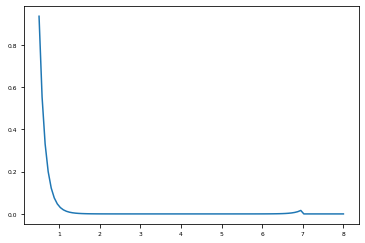

In [51]:
dd=7
sll=xAll[sel,0]==dd
t=np.linspace(0.5,8,101)
y=np.exp(np.median(z0[sll])+np.square(t-np.median(zh[sll]))+np.int32(dd<=t)*np.median(zd[sll]) )
plt.plot(t,y)

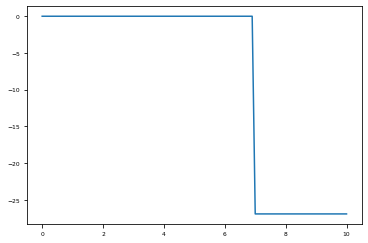

In [41]:
plt.plot(t,np.int32(dd<=t)*np.median(zd[sll]))

In [2]:
LLN=[-7407.20550493, np.nan ,-5919.49599364, np.nan, -9032.02034341]
LMN=[-50515.46065389 , nan,  -7587.83497186 -56772.69394456,-50714.69642137]

In [ ]:
TNo  [-1055.7305073             nan  -922.18461858 -1905.61586771,-1038.77077253]
[[        nan         nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan]
 [ 7.78152086  6.21195039 11.33081769  7.23818434  8.57450501]
 [ 6.02594475  5.25320572  6.93652309  5.72628736  6.31786192]
 [ 5.92146047  5.17222253  6.91747012  5.62162428  6.23179937]]


\begin{table}
\centering
\begin{tabular}{|l|c|c|c|c|c|c|c||}
\hline
  &   & $r_{z_0,\sigma}$ & $r_{z_h,\sigma}$ & $r_{z_d,\sigma}$ & $r_{z_0,z_h}$ & $r_{z_0,z_d}$ & $r_{z_h,z_d}$ \\
\hline
N & NP &  0.57 & -0.17 &  0.12 & -0.46 &  0.06 & -0.82 \\
L & NP & -0.25 &  0.03 &  0.02 & -0.40 & -0.08 & -0.74 \\
W & NP &  0.16 & -0.07 & -0.01 & -0.38 & -0.08 & -0.75 \\
G & NP & -0.42 & -0.06 & -0.01 & -0.30 & -0.05 & -0.75 \\
\hline
N & PP &  0.52 &  0.14 &  0.09 & -0.22 & -0.08 & -0.35 \\
X & PP &  0.42 &  0.29 &  0.03 &  0.10 & -0.30 & -0.14 \\
L & PP & -0.37 & -0.04 &  0.09 &  0.08 & -0.29 &  0.11 \\
W & PP &  0.19 & -0.03 & -0.15 &  0.19 & -0.25 & -0.17 \\
G & PP & -0.15 & -0.09 & -0.17 &  0.09 & -0.14 & -0.04 \\
\hline
\end{tabular}
\end{table}


In [2]:
d=np.array([[6,15.52,12.32,9.48,8.72,6.44,5.56,4.57,11.98],
    [7,13.45,10.25,10.42,8.28,7.26,7.58,5.04,14.68],
    [8,12.85,9.72,9.85,6.58,5.68,6.42,4.93,14.64],
    [9,11.70,9.02,8.60,6.14,5.89,4.94,5.22,19.02],
    [10,7.44,6.95,7.39,8.08,6.42,5.13,4.88,17.84],
    [11,9.78,7.95,9.40,7.68,5.55,4.82,4.24,16.92],
    [12,8.62,8.56,7.25,7.36,6.14,4.85,3.80,19.09]])

In [14]:
np.power(d[:,-2]/d[:,2],1/7)-1

array([-0.13209495, -0.09643771, -0.09242411, -0.07516069, -0.04925917,
       -0.08588714, -0.10953739])

In [16]:
d[:,2]

array([12.32, 10.25,  9.72,  9.02,  6.95,  7.95,  8.56])

In [17]:
d[:,-1]/d[:,-2]

array([2.6214442 , 2.91269841, 2.96957404, 3.64367816, 3.6557377 ,
       3.99056604, 5.02368421])

In [5]:
np.median(w['sigma'])

2.10032605159662

In [2]:
w=np.load('data/GTPsf.npy',allow_pickle=True).tolist()

In [29]:
w['nms'][(w['rhat'][0][:-1]>1.1).nonzero()[0]]

<ipython-input-29-d84cc6309783>:1: RuntimeWarning: invalid value encountered in greater
  w['nms'][(w['rhat'][0][:-1]>1.1).nonzero()[0]]


array(['zd[42]', 'sigma[43]', 'sigma[173]', 'sigma[184]', 'sigma[281]',
       'zhs', 'zds', 'z0s'], dtype='<U10')

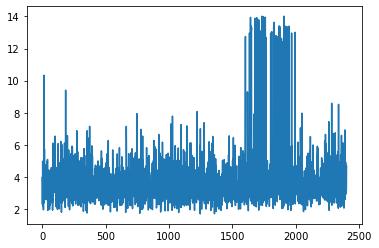

In [22]:
plt.plot(w['sigma'][:,262])

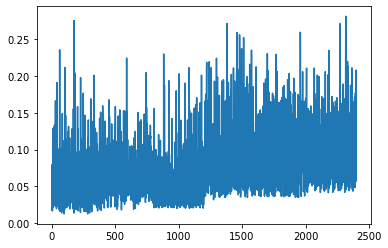

In [23]:
plt.plot(w['zhs'])

(5, 101, 301, 10)

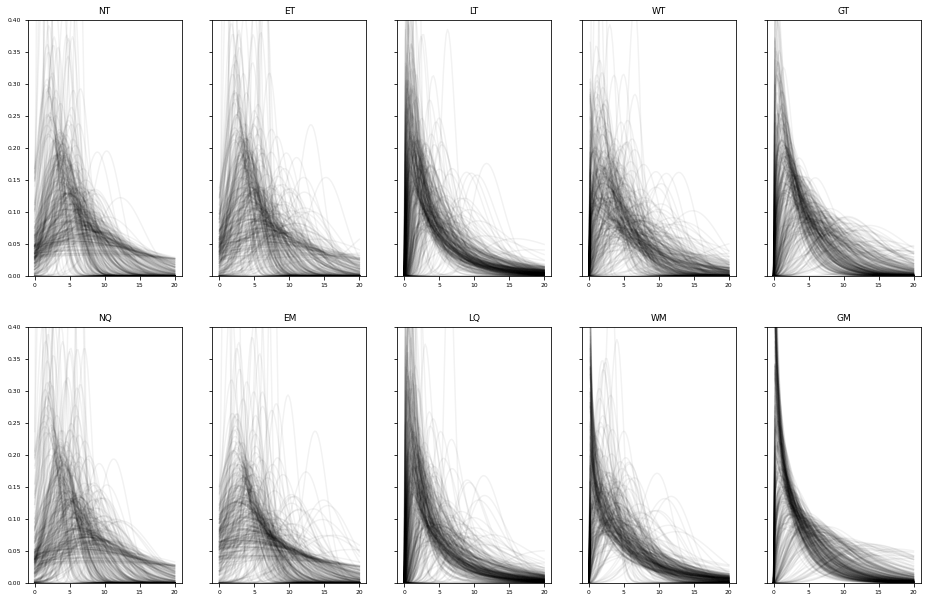

In [7]:
n=301
r=np.linspace(0,1,6)
np.tanh(np.arctanh(r)+1.96/np.sqrt(n-3))-r

<ipython-input-7-587037213d4e>:3: RuntimeWarning: divide by zero encountered in arctanh
  np.tanh(np.arctanh(r)+1.96/np.sqrt(n-3))-r


array([0.11305436, 0.10613244, 0.09085696, 0.06775855, 0.03732387,
       0.        ])

In [8]:
r

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])